코드 출처 : https://github.com/rickiepark/handson-ml

스터디 발표를 위해 역자 코드를 바탕으로 내용을 추가하였습니다.

In [31]:
%load_ext watermark
%watermark -v -p numpy,sklearn,scipy,matplotlib,tensorflow

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.6.4
IPython 6.2.1

numpy 1.14.0
sklearn 0.19.1
scipy 1.0.0
matplotlib 2.1.2
tensorflow 1.5.0


**11장 – 심층 신경망 훈련**

_이 노트북은 11장에 있는 연습문제 해답을 가지고 있습니다._

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [32]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [33]:
import tensorflow as tf

# 연습문제 해답

## 1. to 7.

부록 A 참조.

## 8. 딥러닝

### 8.1.

_문제: He 초기화와 ELU 활성화 함수를 사용하여 각각 뉴런이 100개인 은닉층 다섯 개를 가진 DNN을 만드세요._

다음 연습문제도 비슷한 모델을 만들어야하므로 여기서 DNN을 구성하는 함수를 만들겠습니다:

In [34]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [35]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

### 8.2.

_문제: Adam 최적화와 조기 종료를 사용하여 MNIST 데이터셋에 훈련시키되 0에서 4까지의 숫자만 사용하세요. 다음 연습문제에서 5에서 9까지의 숫자에 대해 전이 학습을 사용할 것입니다. 출력층은 다섯 개의 뉴런에 소프트맥스 함수를 사용합니다. 나중에 재사용할 수 있도록 항상 일정한 간격으로 체크포인트와 최종 모델을 저장하세요._

비용 함수, 훈련 연산과 다른 필요한 구성 요소를 만듭니다:

In [36]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

MNIST 데이터셋을 로드합니다:

주의: `tf.examples.tutorials.mnist`은 삭제될 예정이므로 대신 `tf.keras.datasets.mnist`를 사용하겠습니다.

In [37]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

훈련 세트, 검증 세트, 테스트 세트를 만듭니다(검증 세트는 조기 종료에 사용합니다):

In [38]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [39]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

0	검증 세트 손실: 0.142523	최선의 손실: 0.142523	정확도: 96.87%
1	검증 세트 손실: 1.206604	최선의 손실: 0.142523	정확도: 42.03%
2	검증 세트 손실: 0.271909	최선의 손실: 0.142523	정확도: 95.58%
3	검증 세트 손실: 0.269873	최선의 손실: 0.142523	정확도: 94.53%
4	검증 세트 손실: 0.196974	최선의 손실: 0.142523	정확도: 95.97%
5	검증 세트 손실: 0.167328	최선의 손실: 0.142523	정확도: 97.26%
6	검증 세트 손실: 0.202854	최선의 손실: 0.142523	정확도: 94.68%
7	검증 세트 손실: 0.291291	최선의 손실: 0.142523	정확도: 95.70%
8	검증 세트 손실: 0.186152	최선의 손실: 0.142523	정확도: 97.73%
9	검증 세트 손실: 0.948319	최선의 손실: 0.142523	정확도: 69.66%
10	검증 세트 손실: 0.329804	최선의 손실: 0.142523	정확도: 93.78%
11	검증 세트 손실: 0.162550	최선의 손실: 0.142523	정확도: 97.07%
12	검증 세트 손실: 0.138445	최선의 손실: 0.138445	정확도: 96.79%
13	검증 세트 손실: 0.216108	최선의 손실: 0.138445	정확도: 96.29%
14	검증 세트 손실: 0.170976	최선의 손실: 0.138445	정확도: 95.50%
15	검증 세트 손실: 0.183409	최선의 손실: 0.138445	정확도: 96.64%
16	검증 세트 손실: 0.201099	최선의 손실: 0.138445	정확도: 97.42%
17	검증 세트 손실: 0.188710	최선의 손실: 0.138445	정확도: 95.86%
18	검증 세트 손실: 0.170321	최선의 손실: 0.138445	정확도: 97.65%
19	검증 세트 손실: 0.146281	최선의 손실: 0.138445	정확

아주 나쁘지는 않지만 하이퍼파라미터를 튜닝하여 더 개선할 수 있을지 보겠습니다.

### 8.3.

_문제: 교차 검증을 사용하여 하이퍼파라미터를 튜닝하고 얼마의 성능을 달성할 수 있는지 확인해보세요._

하이퍼파라미터 튜닝을 하기 위해 사이킷런의 `RandomizedSearchCV` 클래스와 호환되는 `DNNClassifier` 클래스를 만듭니다. 이 클래스의 핵심은 다음과 같습니다:
* `__init__()` 메서드(생성자)는 각 하이퍼파라미터에 대한 인스턴스 변수를 만듭니다.
* `fit()` 메서드는 그래프를 만들고 세션을 시작해 모델을 훈련시킵니다:
  * `_build_graph()` 메서드를 호출해 그래프를 만듭니다(앞서 만든 그래프와 비슷합니다). 그래프가 만들어지면 다른 메서드에서 접근할 수 있도록 중요한 연산은 모두 인스턴스 변수로 저장합니다.
  * `_dnn()` 메서드는 위의 `dnn()` 함수와 비슷하게 은닉층을 만들고 배치 정규화와 드롭아웃을 추가합니다(다음 연습문제를 위해).
  * `fit()` 메서드에는 검증 세트(`X_valid`와 `y_valid`)가 주어지면 조기 종료를 실행합니다. 여기에서는 디스키 대신 메모리에 최상의 모델을 저장합니다. 이 함수는 그래프의 모든 변수와 값을 가져오기 위해 `_get_model_params()` 함수를 사용하고 (최상의 모델에서) 변수 값을 복원하기 위해 `_restore_model_params()` 함수를 사용합니다. 이런 방식은 훈련 속도를 높여 줍니다.
  * `fit()` 메서드가 모델 훈련을 마치면 예측을 만들기 위해 모델을 저장하고 복원하는 대신에 빠르게 예측을 만들기 위해 그대로 세션을 열어 둡니다. `close_session()` 메서드를 호출해 세션을 닫을 수 있습니다.
  * `predict_proba()` 메서드는 훈련 모델을 사용해 클래스 확률을 예측합니다.
  * `predict()` 메서드는 `predict_proba()`를 호출해 각 샘플에 대해 가장 높은 확률을 가진 클래스를 반환합니다.

In [40]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """모든 하이퍼파파미터를 저장하는 것으로 DNNClassifier를 초기화합니다."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """배치 정규화와 드롭아웃 기능을 넣어 은닉층을 구성합니다."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """이전과 동일한 모델을 만듭니다."""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # 중요한 연산은 인스턴스 변수로 저장하여 참조하기 쉽게 합니다.
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """모든 변수 값을 가져옵니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """모든 변수를 주어진 값으로 설정합니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """훈련 세트에 모델을 훈련시킵니다. X_valid와 y_valid가 주어지면 조기 종료를 적용합니다."""
        self.close_session()

        # 훈련 세트로부터 n_inputs와 n_outputs를 구합니다.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # 레이블 벡터를 정렬된 클래스 인덱스 벡터로 변환합니다.
        # 0부터 n_outputs - 1까지의 정수를 담고 있게 됩니다.
        # 예를 들어, y가 [8, 8, 9, 5, 7, 6, 6, 6]이면 
        # 정렬된 클래스 레이블(self.classes_)은 [5, 6, 7, 8, 9]가 되고
        # 레이블 벡터는 [3, 3, 4, 0, 2, 1, 1, 1]로 변환됩니다.
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # 배치 정규화를 위한 추가 연산
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # 조기 종료를 위해
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # 이제 모델을 훈련합니다!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("조기 종료!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\t마지막 훈련 배치 손실: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # 조기 종료를 사용하면 이전의 최상의 모델로 되돌립니다.
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("%s 객체가 아직 훈련되지 않았습니다" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

이 클래스를 사용하여 이전과 비슷한 정확도가 나오는지 확인해 보죠(드롭아웃과 배치 정규화는 사용하지 않습니다):

In [41]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.142523	최선의 손실: 0.142523	정확도: 96.87%
1	검증 세트 손실: 1.206604	최선의 손실: 0.142523	정확도: 42.03%
2	검증 세트 손실: 0.271909	최선의 손실: 0.142523	정확도: 95.58%
3	검증 세트 손실: 0.269873	최선의 손실: 0.142523	정확도: 94.53%
4	검증 세트 손실: 0.196974	최선의 손실: 0.142523	정확도: 95.97%
5	검증 세트 손실: 0.167328	최선의 손실: 0.142523	정확도: 97.26%
6	검증 세트 손실: 0.202854	최선의 손실: 0.142523	정확도: 94.68%
7	검증 세트 손실: 0.291291	최선의 손실: 0.142523	정확도: 95.70%
8	검증 세트 손실: 0.186152	최선의 손실: 0.142523	정확도: 97.73%
9	검증 세트 손실: 0.948319	최선의 손실: 0.142523	정확도: 69.66%
10	검증 세트 손실: 0.329804	최선의 손실: 0.142523	정확도: 93.78%
11	검증 세트 손실: 0.162550	최선의 손실: 0.142523	정확도: 97.07%
12	검증 세트 손실: 0.138445	최선의 손실: 0.138445	정확도: 96.79%
13	검증 세트 손실: 0.216108	최선의 손실: 0.138445	정확도: 96.29%
14	검증 세트 손실: 0.170976	최선의 손실: 0.138445	정확도: 95.50%
15	검증 세트 손실: 0.183409	최선의 손실: 0.138445	정확도: 96.64%
16	검증 세트 손실: 0.201099	최선의 손실: 0.138445	정확도: 97.42%
17	검증 세트 손실: 0.188710	최선의 손실: 0.138445	정확도: 95.86%
18	검증 세트 손실: 0.170321	최선의 손실: 0.138445	정확도: 97.65%
19	검증 세트 손실: 0.146281	최선의 손실: 0.138445	정확

DNNClassifier(activation=<function elu at 0x10a842ae8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x11ac25f28>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

모델 훈련이 완료되면 이전과 비슷한 정확도가 나오는지 확인해 보겠습니다:

In [42]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.974508659272232

좋네요! 잘 작동합니다. 이제 사이킷런의 `RandomizedSearchCV` 클래스를 사용해서 더 나은 하이퍼파라미터를 찾아보겠습니다(시스템에 따라 이 작업은 한 시간 이상 걸릴지 모릅니다):

In [43]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # 은닉층의 수나 옵티마이저 등을 달리하여 탐색해 볼 수 있습니다.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

# 생성자에 넘겨주는 fit_params 매개변수는 사이킷런 0.19 버전부터 경고가 발생하고 0.21 버전에서 사라지므로
# 대신 fit() 메서드에 매개변수로 전달해야 합니다.:
rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function elu at 0x10a842ae8> 
0	검증 세트 손실: 0.145078	최선의 손실: 0.145078	정확도: 96.64%
1	검증 세트 손실: 0.173971	최선의 손실: 0.145078	정확도: 95.19%
2	검증 세트 손실: 0.157920	최선의 손실: 0.145078	정확도: 96.40%
3	검증 세트 손실: 0.148727	최선의 손실: 0.145078	정확도: 96.48%
4	검증 세트 손실: 0.137161	최선의 손실: 0.137161	정확도: 96.72%
5	검증 세트 손실: 0.118723	최선의 손실: 0.118723	정확도: 96.64%
6	검증 세트 손실: 0.111457	최선의 손실: 0.111457	정확도: 96.56%
7	검증 세트 손실: 0.125656	최선의 손실: 0.111457	정확도: 96.91%
8	검증 세트 손실: 1.649478	최선의 손실: 0.111457	정확도: 22.01%
9	검증 세트 손실: 1.573059	최선의 손실: 0.111457	정확도: 23.26%
10	검증 세트 손실: 1.571778	최선의 손실: 0.111457	정확도: 23.26%
11	검증 세트 손실: 1.580718	최선의 손실: 0.111457	정확도: 21.42%
12	검증 세트 손실: 1.591989	최선의 손실: 0.111457	정확도: 21.42%
13	검증 세트 손실: 1.586365	최선의 손실: 0.111457	정확도: 21.07%
14	검증 세트 손실: 1.586736	최선의 손실: 0.111457	정확도: 21.07%
15	검증 세트 손실: 1.573506	최선의 손실: 0.111457	정확도: 22.01%
16	검증 세트 손실: 1.572849	최선의 손실: 0.111

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


0	검증 세트 손실: 0.132567	최선의 손실: 0.132567	정확도: 96.64%
1	검증 세트 손실: 0.140460	최선의 손실: 0.132567	정확도: 96.48%
2	검증 세트 손실: 0.140922	최선의 손실: 0.132567	정확도: 96.48%
3	검증 세트 손실: 0.303073	최선의 손실: 0.132567	정확도: 95.43%
4	검증 세트 손실: 0.324907	최선의 손실: 0.132567	정확도: 93.86%
5	검증 세트 손실: 0.271279	최선의 손실: 0.132567	정확도: 94.21%
6	검증 세트 손실: 0.205956	최선의 손실: 0.132567	정확도: 94.80%
7	검증 세트 손실: 0.169514	최선의 손실: 0.132567	정확도: 96.21%
8	검증 세트 손실: 0.293873	최선의 손실: 0.132567	정확도: 93.55%
9	검증 세트 손실: 0.191498	최선의 손실: 0.132567	정확도: 95.04%
10	검증 세트 손실: 0.215853	최선의 손실: 0.132567	정확도: 94.53%
11	검증 세트 손실: 0.251179	최선의 손실: 0.132567	정확도: 92.42%
12	검증 세트 손실: 0.187263	최선의 손실: 0.132567	정확도: 95.31%
13	검증 세트 손실: 0.187945	최선의 손실: 0.132567	정확도: 95.47%
14	검증 세트 손실: 0.379301	최선의 손실: 0.132567	정확도: 86.94%
15	검증 세트 손실: 0.336114	최선의 손실: 0.132567	정확도: 91.87%
16	검증 세트 손실: 0.577157	최선의 손실: 0.132567	정확도: 73.46%
17	검증 세트 손실: 0.614491	최선의 손실: 0.132567	정확도: 75.25%
18	검증 세트 손실: 0.516692	최선의 손실: 0.132567	정확도: 75.06%
19	검증 세트 손실: 0.504678	최선의 손실: 0.132567	정확

0	검증 세트 손실: 39.380558	최선의 손실: 39.380558	정확도: 28.77%
1	검증 세트 손실: 11.570292	최선의 손실: 11.570292	정확도: 40.73%
2	검증 세트 손실: 2548.848877	최선의 손실: 11.570292	정확도: 20.09%
3	검증 세트 손실: 373.418579	최선의 손실: 11.570292	정확도: 63.02%
4	검증 세트 손실: 397.213013	최선의 손실: 11.570292	정확도: 58.76%
5	검증 세트 손실: 480.434326	최선의 손실: 11.570292	정확도: 62.00%
6	검증 세트 손실: 236.977966	최선의 손실: 11.570292	정확도: 67.98%
7	검증 세트 손실: 380.898590	최선의 손실: 11.570292	정확도: 64.82%
8	검증 세트 손실: 191.740097	최선의 손실: 11.570292	정확도: 72.20%
9	검증 세트 손실: 264.550568	최선의 손실: 11.570292	정확도: 58.05%
10	검증 세트 손실: 222.660446	최선의 손실: 11.570292	정확도: 64.31%
11	검증 세트 손실: 311.316010	최선의 손실: 11.570292	정확도: 75.25%
12	검증 세트 손실: 584.060242	최선의 손실: 11.570292	정확도: 88.31%
13	검증 세트 손실: 60.794495	최선의 손실: 11.570292	정확도: 84.91%
14	검증 세트 손실: 55.055706	최선의 손실: 11.570292	정확도: 89.52%
15	검증 세트 손실: 69.678535	최선의 손실: 11.570292	정확도: 86.36%
16	검증 세트 손실: 46995.539062	최선의 손실: 11.570292	정확도: 18.73%
17	검증 세트 손실: 1104.038208	최선의 손실: 11.570292	정확도: 51.13%
18	검증 세트 손실: 233.719681	최선의 손실: 11.5702

23	검증 세트 손실: 108290.304688	최선의 손실: 5.751077	정확도: 93.39%
24	검증 세트 손실: 53918.410156	최선의 손실: 5.751077	정확도: 96.33%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.1, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x105c4dc80>, total=  18.2s
[CV] n_neurons=70, learning_rate=0.1, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x105c4dc80> 
0	검증 세트 손실: 730.446167	최선의 손실: 730.446167	정확도: 76.70%
1	검증 세트 손실: 264.334015	최선의 손실: 264.334015	정확도: 85.46%
2	검증 세트 손실: 187.733673	최선의 손실: 187.733673	정확도: 90.27%
3	검증 세트 손실: 77.327103	최선의 손실: 77.327103	정확도: 95.27%
4	검증 세트 손실: 129.192871	최선의 손실: 77.327103	정확도: 93.75%
5	검증 세트 손실: 49.199871	최선의 손실: 49.199871	정확도: 96.05%
6	검증 세트 손실: 65.060493	최선의 손실: 49.199871	정확도: 95.43%
7	검증 세트 손실: 49.172379	최선의 손실: 49.172379	정확도: 96.99%
8	검증 세트 손실: 401.186340	최선의 손실: 49.172379	정확도: 92.49%
9	검증 세트 손실: 277979.593750	최선의 손실: 49.172379	정확도: 77.40%
10	검증 세트 손실: 58960.351562	최선의 손실: 49.172379	정확도: 89.56%
11	검증 세트 

9	검증 세트 손실: 0.061877	최선의 손실: 0.041472	정확도: 98.63%
10	검증 세트 손실: 0.084304	최선의 손실: 0.041472	정확도: 98.55%
11	검증 세트 손실: 0.082655	최선의 손실: 0.041472	정확도: 98.16%
12	검증 세트 손실: 0.059508	최선의 손실: 0.041472	정확도: 98.55%
13	검증 세트 손실: 0.067644	최선의 손실: 0.041472	정확도: 98.71%
14	검증 세트 손실: 0.049003	최선의 손실: 0.041472	정확도: 98.91%
15	검증 세트 손실: 0.088914	최선의 손실: 0.041472	정확도: 98.44%
16	검증 세트 손실: 0.061374	최선의 손실: 0.041472	정확도: 98.94%
17	검증 세트 손실: 0.061538	최선의 손실: 0.041472	정확도: 98.91%
18	검증 세트 손실: 0.062615	최선의 손실: 0.041472	정확도: 98.83%
19	검증 세트 손실: 0.065299	최선의 손실: 0.041472	정확도: 98.87%
20	검증 세트 손실: 0.059910	최선의 손실: 0.041472	정확도: 98.75%
21	검증 세트 손실: 0.088192	최선의 손실: 0.041472	정확도: 98.63%
22	검증 세트 손실: 0.066206	최선의 손실: 0.041472	정확도: 98.94%
23	검증 세트 손실: 0.074085	최선의 손실: 0.041472	정확도: 98.51%
24	검증 세트 손실: 0.061096	최선의 손실: 0.041472	정확도: 98.79%
25	검증 세트 손실: 0.059104	최선의 손실: 0.041472	정확도: 98.75%
26	검증 세트 손실: 0.069336	최선의 손실: 0.041472	정확도: 98.75%
27	검증 세트 손실: 0.072562	최선의 손실: 0.041472	정확도: 98.79%
28	검증 세트 손실: 0.075016	최선의 손실: 0.

12	검증 세트 손실: 0.043155	최선의 손실: 0.043155	정확도: 99.02%
13	검증 세트 손실: 0.048998	최선의 손실: 0.043155	정확도: 98.79%
14	검증 세트 손실: 0.058145	최선의 손실: 0.043155	정확도: 98.91%
15	검증 세트 손실: 0.073840	최선의 손실: 0.043155	정확도: 98.36%
16	검증 세트 손실: 0.066197	최선의 손실: 0.043155	정확도: 98.63%
17	검증 세트 손실: 0.054387	최선의 손실: 0.043155	정확도: 98.91%
18	검증 세트 손실: 0.051473	최선의 손실: 0.043155	정확도: 98.83%
19	검증 세트 손실: 0.051254	최선의 손실: 0.043155	정확도: 98.75%
20	검증 세트 손실: 0.055856	최선의 손실: 0.043155	정확도: 99.10%
21	검증 세트 손실: 0.056403	최선의 손실: 0.043155	정확도: 98.91%
22	검증 세트 손실: 0.056785	최선의 손실: 0.043155	정확도: 98.79%
23	검증 세트 손실: 0.060307	최선의 손실: 0.043155	정확도: 98.63%
24	검증 세트 손실: 0.080154	최선의 손실: 0.043155	정확도: 98.91%
25	검증 세트 손실: 0.074093	최선의 손실: 0.043155	정확도: 98.79%
26	검증 세트 손실: 0.058842	최선의 손실: 0.043155	정확도: 98.83%
27	검증 세트 손실: 0.073931	최선의 손실: 0.043155	정확도: 98.79%
28	검증 세트 손실: 0.071651	최선의 손실: 0.043155	정확도: 98.79%
29	검증 세트 손실: 0.063792	최선의 손실: 0.043155	정확도: 98.79%
30	검증 세트 손실: 0.106530	최선의 손실: 0.043155	정확도: 98.55%
31	검증 세트 손실: 0.071836	최선의 손실: 0

56	검증 세트 손실: 1.669471	최선의 손실: 1.607883	정확도: 19.08%
57	검증 세트 손실: 1.619669	최선의 손실: 1.607883	정확도: 18.73%
58	검증 세트 손실: 1.612549	최선의 손실: 1.607883	정확도: 22.01%
59	검증 세트 손실: 1.619514	최선의 손실: 1.607883	정확도: 22.01%
60	검증 세트 손실: 1.635963	최선의 손실: 1.607883	정확도: 18.73%
61	검증 세트 손실: 1.627401	최선의 손실: 1.607883	정확도: 22.01%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.1, batch_size=10, activation=<function relu at 0x10a8778c8>, total= 1.4min
[CV] n_neurons=50, learning_rate=0.1, batch_size=10, activation=<function relu at 0x10a8778c8> 
0	검증 세트 손실: 1.644704	최선의 손실: 1.644704	정확도: 19.27%
1	검증 세트 손실: 1.624599	최선의 손실: 1.624599	정확도: 19.27%
2	검증 세트 손실: 1.614158	최선의 손실: 1.614158	정확도: 19.27%
3	검증 세트 손실: 1.616997	최선의 손실: 1.614158	정확도: 19.27%
4	검증 세트 손실: 1.614500	최선의 손실: 1.614158	정확도: 22.01%
5	검증 세트 손실: 1.627706	최선의 손실: 1.614158	정확도: 22.01%
6	검증 세트 손실: 1.648677	최선의 손실: 1.614158	정확도: 19.27%
7	검증 세트 손실: 1.627603	최선의 손실: 1.614158	정확도: 18.73%
8	검증 세트 손실: 1.625684	최선의 손실: 1.614158	정확도: 22.01%
9	검증 세트 손실: 1.615558	최선의 손실: 1

29	검증 세트 손실: 0.074789	최선의 손실: 0.053878	정확도: 98.48%
30	검증 세트 손실: 0.065659	최선의 손실: 0.053878	정확도: 98.51%
31	검증 세트 손실: 0.060367	최선의 손실: 0.053878	정확도: 98.32%
32	검증 세트 손실: 0.055344	최선의 손실: 0.053878	정확도: 98.32%
33	검증 세트 손실: 0.068653	최선의 손실: 0.053878	정확도: 98.51%
34	검증 세트 손실: 0.080840	최선의 손실: 0.053878	정확도: 98.55%
35	검증 세트 손실: 0.093383	최선의 손실: 0.053878	정확도: 97.19%
36	검증 세트 손실: 0.078422	최선의 손실: 0.053878	정확도: 98.48%
37	검증 세트 손실: 0.073297	최선의 손실: 0.053878	정확도: 98.44%
38	검증 세트 손실: 0.088264	최선의 손실: 0.053878	정확도: 98.51%
39	검증 세트 손실: 0.075295	최선의 손실: 0.053878	정확도: 98.63%
40	검증 세트 손실: 0.093779	최선의 손실: 0.053878	정확도: 98.36%
41	검증 세트 손실: 0.085175	최선의 손실: 0.053878	정확도: 98.48%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function relu at 0x10a8778c8>, total=   9.5s
[CV] n_neurons=50, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x117a2df28> 
0	검증 세트 손실: 0.261468	최선의 손실: 0.261468	정확도: 94.84%
1	검증 세트 손실: 6.619938	최선의 손실: 0

5	검증 세트 손실: 0.074897	최선의 손실: 0.072252	정확도: 98.08%
6	검증 세트 손실: 0.087163	최선의 손실: 0.072252	정확도: 97.81%
7	검증 세트 손실: 0.060664	최선의 손실: 0.060664	정확도: 98.51%
8	검증 세트 손실: 0.411405	최선의 손실: 0.060664	정확도: 95.78%
9	검증 세트 손실: 0.075673	최선의 손실: 0.060664	정확도: 98.12%
10	검증 세트 손실: 0.069127	최선의 손실: 0.060664	정확도: 98.08%
11	검증 세트 손실: 0.068463	최선의 손실: 0.060664	정확도: 98.24%
12	검증 세트 손실: 0.100240	최선의 손실: 0.060664	정확도: 97.85%
13	검증 세트 손실: 0.094389	최선의 손실: 0.060664	정확도: 98.28%
14	검증 세트 손실: 0.105768	최선의 손실: 0.060664	정확도: 97.65%
15	검증 세트 손실: 0.102092	최선의 손실: 0.060664	정확도: 97.69%
16	검증 세트 손실: 0.121252	최선의 손실: 0.060664	정확도: 97.62%
17	검증 세트 손실: 0.367553	최선의 손실: 0.060664	정확도: 95.43%
18	검증 세트 손실: 0.169425	최선의 손실: 0.060664	정확도: 96.95%
19	검증 세트 손실: 0.195703	최선의 손실: 0.060664	정확도: 97.38%
20	검증 세트 손실: 0.191162	최선의 손실: 0.060664	정확도: 97.85%
21	검증 세트 손실: 0.201148	최선의 손실: 0.060664	정확도: 97.34%
22	검증 세트 손실: 0.158451	최선의 손실: 0.060664	정확도: 98.01%
23	검증 세트 손실: 0.172159	최선의 손실: 0.060664	정확도: 98.08%
24	검증 세트 손실: 0.249060	최선의 손실: 0.0606

8	검증 세트 손실: 999.278137	최선의 손실: 65.528786	정확도: 95.93%
9	검증 세트 손실: 650.877747	최선의 손실: 65.528786	정확도: 93.90%
10	검증 세트 손실: 1147.189941	최선의 손실: 65.528786	정확도: 97.38%
11	검증 세트 손실: 897.728088	최선의 손실: 65.528786	정확도: 94.57%
12	검증 세트 손실: 3584.111816	최선의 손실: 65.528786	정확도: 96.09%
13	검증 세트 손실: 1574.163452	최선의 손실: 65.528786	정확도: 95.62%
14	검증 세트 손실: 1527.068970	최선의 손실: 65.528786	정확도: 95.43%
15	검증 세트 손실: 1891.392700	최선의 손실: 65.528786	정확도: 96.68%
16	검증 세트 손실: 11885.347656	최선의 손실: 65.528786	정확도: 94.92%
17	검증 세트 손실: 3100.018555	최선의 손실: 65.528786	정확도: 97.46%
18	검증 세트 손실: 12445.739258	최선의 손실: 65.528786	정확도: 97.19%
19	검증 세트 손실: 4499.134277	최선의 손실: 65.528786	정확도: 96.52%
20	검증 세트 손실: 4314.158691	최선의 손실: 65.528786	정확도: 97.15%
21	검증 세트 손실: 3330.312744	최선의 손실: 65.528786	정확도: 95.54%
22	검증 세트 손실: 8837.387695	최선의 손실: 65.528786	정확도: 97.34%
23	검증 세트 손실: 7496.547363	최선의 손실: 65.528786	정확도: 97.97%
24	검증 세트 손실: 4023.383545	최선의 손실: 65.528786	정확도: 96.79%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.02, batch_size=10, activ

44	검증 세트 손실: 0.099798	최선의 손실: 0.087838	정확도: 97.46%
45	검증 세트 손실: 0.109114	최선의 손실: 0.087838	정확도: 97.69%
46	검증 세트 손실: 0.111205	최선의 손실: 0.087838	정확도: 97.69%
47	검증 세트 손실: 0.158684	최선의 손실: 0.087838	정확도: 97.69%
48	검증 세트 손실: 0.127365	최선의 손실: 0.087838	정확도: 97.46%
49	검증 세트 손실: 0.140393	최선의 손실: 0.087838	정확도: 97.42%
50	검증 세트 손실: 0.124031	최선의 손실: 0.087838	정확도: 97.65%
51	검증 세트 손실: 0.157955	최선의 손실: 0.087838	정확도: 97.50%
52	검증 세트 손실: 0.152942	최선의 손실: 0.087838	정확도: 97.30%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.1, batch_size=500, activation=<function elu at 0x10a842ae8>, total=   9.7s
[CV] n_neurons=100, learning_rate=0.1, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x117a2df28> 
0	검증 세트 손실: 0.801671	최선의 손실: 0.801671	정확도: 70.13%
1	검증 세트 손실: 0.633018	최선의 손실: 0.633018	정확도: 74.63%
2	검증 세트 손실: 5029.771484	최선의 손실: 0.633018	정확도: 33.58%
3	검증 세트 손실: 50404.132812	최선의 손실: 0.633018	정확도: 19.08%
4	검증 세트 손실: 3403.206787	최선의 손실: 0.633018	정확도: 50.20%
5	검증 세트 손실: 2464.380371	최선의

10	검증 세트 손실: 0.224530	최선의 손실: 0.157787	정확도: 96.72%
11	검증 세트 손실: 32243.853516	최선의 손실: 0.157787	정확도: 68.84%
12	검증 세트 손실: 12877.103516	최선의 손실: 0.157787	정확도: 78.19%
13	검증 세트 손실: 5056.875000	최선의 손실: 0.157787	정확도: 87.14%
14	검증 세트 손실: 23714.101562	최선의 손실: 0.157787	정확도: 76.82%
15	검증 세트 손실: 6623.552734	최선의 손실: 0.157787	정확도: 80.38%
16	검증 세트 손실: 7234.698242	최선의 손실: 0.157787	정확도: 85.69%
17	검증 세트 손실: 3711.300537	최선의 손실: 0.157787	정확도: 92.06%
18	검증 세트 손실: 2709.922119	최선의 손실: 0.157787	정확도: 94.06%
19	검증 세트 손실: 2160.011475	최선의 손실: 0.157787	정확도: 94.06%
20	검증 세트 손실: 3181.030762	최선의 손실: 0.157787	정확도: 93.12%
21	검증 세트 손실: 1995.648560	최선의 손실: 0.157787	정확도: 95.15%
22	검증 세트 손실: 2926.686523	최선의 손실: 0.157787	정확도: 92.92%
23	검증 세트 손실: 2233.809570	최선의 손실: 0.157787	정확도: 93.04%
24	검증 세트 손실: 3060.357666	최선의 손실: 0.157787	정확도: 93.39%
25	검증 세트 손실: 2095.545654	최선의 손실: 0.157787	정확도: 93.24%
26	검증 세트 손실: 1877.210327	최선의 손실: 0.157787	정확도: 94.68%
27	검증 세트 손실: 1849.542603	최선의 손실: 0.157787	정확도: 94.92%
조기 종료!
[CV]  n_neurons=70, l

12	검증 세트 손실: 2.091017	최선의 손실: 1.700591	정확도: 20.91%
13	검증 세트 손실: 3.280359	최선의 손실: 1.700591	정확도: 19.08%
14	검증 세트 손실: 2.147485	최선의 손실: 1.700591	정확도: 19.08%
15	검증 세트 손실: 1.816312	최선의 손실: 1.700591	정확도: 19.27%
16	검증 세트 손실: 1.802169	최선의 손실: 1.700591	정확도: 18.73%
17	검증 세트 손실: 2.435368	최선의 손실: 1.700591	정확도: 20.91%
18	검증 세트 손실: 1.970480	최선의 손실: 1.700591	정확도: 19.27%
19	검증 세트 손실: 2.368717	최선의 손실: 1.700591	정확도: 22.01%
20	검증 세트 손실: 2.211073	최선의 손실: 1.700591	정확도: 19.27%
21	검증 세트 손실: 2.549937	최선의 손실: 1.700591	정확도: 22.01%
22	검증 세트 손실: 1.926548	최선의 손실: 1.700591	정확도: 19.27%
23	검증 세트 손실: 2.675553	최선의 손실: 1.700591	정확도: 19.08%
24	검증 세트 손실: 2.478772	최선의 손실: 1.700591	정확도: 19.27%
25	검증 세트 손실: 1.703387	최선의 손실: 1.700591	정확도: 22.01%
26	검증 세트 손실: 2.281172	최선의 손실: 1.700591	정확도: 18.73%
27	검증 세트 손실: 1.997713	최선의 손실: 1.700591	정확도: 18.73%
28	검증 세트 손실: 2.451590	최선의 손실: 1.700591	정확도: 19.08%
29	검증 세트 손실: 2.782325	최선의 손실: 1.700591	정확도: 20.91%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.05, batch_size=10, activation=<functio

5	검증 세트 손실: 0.439794	최선의 손실: 0.388895	정확도: 78.85%
6	검증 세트 손실: 0.596766	최선의 손실: 0.388895	정확도: 72.32%
7	검증 세트 손실: 0.411604	최선의 손실: 0.388895	정확도: 78.77%
8	검증 세트 손실: 0.497986	최선의 손실: 0.388895	정확도: 77.60%
9	검증 세트 손실: 0.475577	최선의 손실: 0.388895	정확도: 77.13%
10	검증 세트 손실: 0.456736	최선의 손실: 0.388895	정확도: 74.12%
11	검증 세트 손실: 0.397922	최선의 손실: 0.388895	정확도: 82.29%
12	검증 세트 손실: 0.671153	최선의 손실: 0.388895	정확도: 69.43%
13	검증 세트 손실: 0.683313	최선의 손실: 0.388895	정확도: 67.40%
14	검증 세트 손실: 0.771480	최선의 손실: 0.388895	정확도: 71.66%
15	검증 세트 손실: 0.505225	최선의 손실: 0.388895	정확도: 85.07%
16	검증 세트 손실: 0.440531	최선의 손실: 0.388895	정확도: 85.89%
17	검증 세트 손실: 0.403251	최선의 손실: 0.388895	정확도: 87.26%
18	검증 세트 손실: 0.490558	최선의 손실: 0.388895	정확도: 86.12%
19	검증 세트 손실: 0.435413	최선의 손실: 0.388895	정확도: 87.29%
20	검증 세트 손실: 0.549540	최선의 손실: 0.388895	정확도: 86.63%
21	검증 세트 손실: 0.402396	최선의 손실: 0.388895	정확도: 88.66%
22	검증 세트 손실: 0.484371	최선의 손실: 0.388895	정확도: 82.10%
23	검증 세트 손실: 0.443575	최선의 손실: 0.388895	정확도: 87.18%
24	검증 세트 손실: 0.494358	최선의 손실: 0.3888

24	검증 세트 손실: 0.421233	최선의 손실: 0.115582	정확도: 93.43%
25	검증 세트 손실: 0.205030	최선의 손실: 0.115582	정확도: 96.05%
26	검증 세트 손실: 0.582888	최선의 손실: 0.115582	정확도: 72.99%
27	검증 세트 손실: 0.521755	최선의 손실: 0.115582	정확도: 74.35%
28	검증 세트 손실: 0.301118	최선의 손실: 0.115582	정확도: 95.86%
29	검증 세트 손실: 0.255127	최선의 손실: 0.115582	정확도: 95.93%
30	검증 세트 손실: 0.218230	최선의 손실: 0.115582	정확도: 95.11%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=10, activation=<function elu at 0x10a842ae8>, total=  30.1s
[CV] n_neurons=10, learning_rate=0.02, batch_size=10, activation=<function elu at 0x10a842ae8> 
0	검증 세트 손실: 0.206517	최선의 손실: 0.206517	정확도: 93.59%
1	검증 세트 손실: 0.245085	최선의 손실: 0.206517	정확도: 94.88%
2	검증 세트 손실: 0.252077	최선의 손실: 0.206517	정확도: 94.18%
3	검증 세트 손실: 0.173526	최선의 손실: 0.173526	정확도: 96.17%
4	검증 세트 손실: 0.145368	최선의 손실: 0.145368	정확도: 96.56%
5	검증 세트 손실: 0.265800	최선의 손실: 0.145368	정확도: 92.92%
6	검증 세트 손실: 0.236872	최선의 손실: 0.145368	정확도: 94.37%
7	검증 세트 손실: 0.193919	최선의 손실: 0.145368	정확도: 96.25%
8	검증 세트 손실: 0.177406	최선의 손실: 

36	검증 세트 손실: 0.093630	최선의 손실: 0.067179	정확도: 98.01%
37	검증 세트 손실: 0.083611	최선의 손실: 0.067179	정확도: 98.28%
38	검증 세트 손실: 0.091635	최선의 손실: 0.067179	정확도: 97.77%
39	검증 세트 손실: 0.109457	최선의 손실: 0.067179	정확도: 97.65%
40	검증 세트 손실: 0.110000	최선의 손실: 0.067179	정확도: 97.62%
41	검증 세트 손실: 0.116812	최선의 손실: 0.067179	정확도: 98.08%
42	검증 세트 손실: 0.085426	최선의 손실: 0.067179	정확도: 98.40%
43	검증 세트 손실: 0.081220	최선의 손실: 0.067179	정확도: 98.28%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x105c4dc80>, total=  17.8s
[CV] n_neurons=140, learning_rate=0.05, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x105c4dc80> 
0	검증 세트 손실: 0.963641	최선의 손실: 0.963641	정확도: 73.77%
1	검증 세트 손실: 0.184297	최선의 손실: 0.184297	정확도: 95.00%
2	검증 세트 손실: 0.256835	최선의 손실: 0.184297	정확도: 93.08%
3	검증 세트 손실: 0.132211	최선의 손실: 0.132211	정확도: 95.93%
4	검증 세트 손실: 0.083468	최선의 손실: 0.083468	정확도: 97.62%
5	검증 세트 손실: 0.081450	최선의 손실: 0.081450	정확도: 9

16	검증 세트 손실: 0.079708	최선의 손실: 0.075205	정확도: 97.85%
17	검증 세트 손실: 0.078070	최선의 손실: 0.075205	정확도: 97.93%
18	검증 세트 손실: 0.083743	최선의 손실: 0.075205	정확도: 98.05%
19	검증 세트 손실: 0.085341	최선의 손실: 0.075205	정확도: 97.81%
20	검증 세트 손실: 0.103031	최선의 손실: 0.075205	정확도: 97.73%
21	검증 세트 손실: 0.099760	최선의 손실: 0.075205	정확도: 97.65%
22	검증 세트 손실: 0.087703	최선의 손실: 0.075205	정확도: 97.62%
23	검증 세트 손실: 0.110110	최선의 손실: 0.075205	정확도: 97.50%
24	검증 세트 손실: 0.108021	최선의 손실: 0.075205	정확도: 97.73%
25	검증 세트 손실: 0.091939	최선의 손실: 0.075205	정확도: 98.08%
26	검증 세트 손실: 0.119132	최선의 손실: 0.075205	정확도: 97.62%
27	검증 세트 손실: 0.098677	최선의 손실: 0.075205	정확도: 97.54%
28	검증 세트 손실: 0.101873	최선의 손실: 0.075205	정확도: 97.77%
29	검증 세트 손실: 0.094157	최선의 손실: 0.075205	정확도: 97.97%
30	검증 세트 손실: 0.099722	최선의 손실: 0.075205	정확도: 97.93%
31	검증 세트 손실: 0.109865	최선의 손실: 0.075205	정확도: 97.93%
32	검증 세트 손실: 0.132260	최선의 손실: 0.075205	정확도: 97.89%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x

0	검증 세트 손실: 0.107308	최선의 손실: 0.107308	정확도: 97.77%
1	검증 세트 손실: 0.113059	최선의 손실: 0.107308	정확도: 97.11%
2	검증 세트 손실: 0.077927	최선의 손실: 0.077927	정확도: 97.58%
3	검증 세트 손실: 0.108484	최선의 손실: 0.077927	정확도: 97.73%
4	검증 세트 손실: 0.272096	최선의 손실: 0.077927	정확도: 92.81%
5	검증 세트 손실: 0.882355	최선의 손실: 0.077927	정확도: 60.36%
6	검증 세트 손실: 0.782418	최선의 손실: 0.077927	정확도: 57.86%
7	검증 세트 손실: 0.851056	최선의 손실: 0.077927	정확도: 62.28%
8	검증 세트 손실: 0.845565	최선의 손실: 0.077927	정확도: 58.76%
9	검증 세트 손실: 0.812208	최선의 손실: 0.077927	정확도: 58.41%
10	검증 세트 손실: 0.463357	최선의 손실: 0.077927	정확도: 78.62%
11	검증 세트 손실: 0.466691	최선의 손실: 0.077927	정확도: 80.34%
12	검증 세트 손실: 0.245413	최선의 손실: 0.077927	정확도: 96.05%
13	검증 세트 손실: 0.186806	최선의 손실: 0.077927	정확도: 97.26%
14	검증 세트 손실: 0.280435	최선의 손실: 0.077927	정확도: 97.54%
15	검증 세트 손실: 0.584051	최선의 손실: 0.077927	정확도: 77.17%
16	검증 세트 손실: 1.670725	최선의 손실: 0.077927	정확도: 19.27%
17	검증 세트 손실: 1.637635	최선의 손실: 0.077927	정확도: 20.91%
18	검증 세트 손실: 1.654965	최선의 손실: 0.077927	정확도: 18.73%
19	검증 세트 손실: 1.621267	최선의 손실: 0.077927	정확

44	검증 세트 손실: 3.874202	최선의 손실: 1.637295	정확도: 18.73%
45	검증 세트 손실: 3.074681	최선의 손실: 1.637295	정확도: 18.73%
46	검증 세트 손실: 2.016002	최선의 손실: 1.637295	정확도: 18.73%
47	검증 세트 손실: 1.977999	최선의 손실: 1.637295	정확도: 19.27%
48	검증 세트 손실: 2.881569	최선의 손실: 1.637295	정확도: 18.73%
49	검증 세트 손실: 2.436893	최선의 손실: 1.637295	정확도: 19.27%
50	검증 세트 손실: 2.693801	최선의 손실: 1.637295	정확도: 19.27%
51	검증 세트 손실: 1.904871	최선의 손실: 1.637295	정확도: 22.01%
52	검증 세트 손실: 2.064740	최선의 손실: 1.637295	정확도: 19.08%
53	검증 세트 손실: 3.472660	최선의 손실: 1.637295	정확도: 22.01%
54	검증 세트 손실: 2.887699	최선의 손실: 1.637295	정확도: 19.27%
55	검증 세트 손실: 3.387923	최선의 손실: 1.637295	정확도: 19.27%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=10, activation=<function elu at 0x10a842ae8>, total= 1.6min
[CV] n_neurons=100, learning_rate=0.1, batch_size=10, activation=<function elu at 0x10a842ae8> 
0	검증 세트 손실: 2.121660	최선의 손실: 2.121660	정확도: 19.27%
1	검증 세트 손실: 2.321551	최선의 손실: 2.121660	정확도: 19.27%
2	검증 세트 손실: 2.492874	최선의 손실: 2.121660	정확도: 18.73%
3	검증 세트 손실: 3.275229	최선의

33	검증 세트 손실: 1.786959	최선의 손실: 0.111213	정확도: 19.08%
34	검증 세트 손실: 1.651991	최선의 손실: 0.111213	정확도: 18.73%
35	검증 세트 손실: 1.782087	최선의 손실: 0.111213	정확도: 20.91%
36	검증 세트 손실: 1.691373	최선의 손실: 0.111213	정확도: 20.91%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=100, activation=<function elu at 0x10a842ae8>, total=  14.6s
[CV] n_neurons=90, learning_rate=0.1, batch_size=100, activation=<function elu at 0x10a842ae8> 
0	검증 세트 손실: 1.663194	최선의 손실: 1.663194	정확도: 22.01%
1	검증 세트 손실: 1.666610	최선의 손실: 1.663194	정확도: 19.27%
2	검증 세트 손실: 1.649223	최선의 손실: 1.649223	정확도: 19.27%
3	검증 세트 손실: 1.612368	최선의 손실: 1.612368	정확도: 18.73%
4	검증 세트 손실: 1.645168	최선의 손실: 1.612368	정확도: 20.91%
5	검증 세트 손실: 1.668632	최선의 손실: 1.612368	정확도: 19.27%
6	검증 세트 손실: 1.837707	최선의 손실: 1.612368	정확도: 19.27%
7	검증 세트 손실: 1.654182	최선의 손실: 1.612368	정확도: 19.27%
8	검증 세트 손실: 1.665991	최선의 손실: 1.612368	정확도: 22.01%
9	검증 세트 손실: 1.689226	최선의 손실: 1.612368	정확도: 19.27%
10	검증 세트 손실: 1.687915	최선의 손실: 1.612368	정확도: 22.01%
11	검증 세트 손실: 1.702372	최선의 손실: 1

16	검증 세트 손실: 0.061632	최선의 손실: 0.044849	정확도: 98.55%
17	검증 세트 손실: 0.060623	최선의 손실: 0.044849	정확도: 98.71%
18	검증 세트 손실: 0.056921	최선의 손실: 0.044849	정확도: 98.79%
19	검증 세트 손실: 0.057363	최선의 손실: 0.044849	정확도: 98.75%
20	검증 세트 손실: 0.065214	최선의 손실: 0.044849	정확도: 98.63%
21	검증 세트 손실: 0.064443	최선의 손실: 0.044849	정확도: 98.67%
22	검증 세트 손실: 0.075573	최선의 손실: 0.044849	정확도: 98.16%
23	검증 세트 손실: 0.066551	최선의 손실: 0.044849	정확도: 98.59%
24	검증 세트 손실: 0.065940	최선의 손실: 0.044849	정확도: 98.67%
25	검증 세트 손실: 0.065800	최선의 손실: 0.044849	정확도: 98.79%
26	검증 세트 손실: 0.080382	최선의 손실: 0.044849	정확도: 98.67%
27	검증 세트 손실: 0.063734	최선의 손실: 0.044849	정확도: 98.59%
28	검증 세트 손실: 0.069041	최선의 손실: 0.044849	정확도: 98.75%
29	검증 세트 손실: 0.062375	최선의 손실: 0.044849	정확도: 98.83%
30	검증 세트 손실: 0.070159	최선의 손실: 0.044849	정확도: 98.87%
31	검증 세트 손실: 0.100155	최선의 손실: 0.044849	정확도: 98.59%
32	검증 세트 손실: 0.052331	최선의 손실: 0.044849	정확도: 98.83%
33	검증 세트 손실: 0.064683	최선의 손실: 0.044849	정확도: 98.48%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.02, batch_size=500, activation=<functi

6	검증 세트 손실: 0.054216	최선의 손실: 0.054216	정확도: 98.20%
7	검증 세트 손실: 0.059325	최선의 손실: 0.054216	정확도: 98.24%
8	검증 세트 손실: 0.055223	최선의 손실: 0.054216	정확도: 98.36%
9	검증 세트 손실: 0.068605	최선의 손실: 0.054216	정확도: 98.51%
10	검증 세트 손실: 0.056042	최선의 손실: 0.054216	정확도: 98.83%
11	검증 세트 손실: 0.066519	최선의 손실: 0.054216	정확도: 98.32%
12	검증 세트 손실: 0.069162	최선의 손실: 0.054216	정확도: 98.48%
13	검증 세트 손실: 0.084771	최선의 손실: 0.054216	정확도: 98.20%
14	검증 세트 손실: 0.071147	최선의 손실: 0.054216	정확도: 98.55%
15	검증 세트 손실: 0.082044	최선의 손실: 0.054216	정확도: 98.63%
16	검증 세트 손실: 0.092583	최선의 손실: 0.054216	정확도: 98.51%
17	검증 세트 손실: 0.073028	최선의 손실: 0.054216	정확도: 98.59%
18	검증 세트 손실: 0.054859	최선의 손실: 0.054216	정확도: 98.59%
19	검증 세트 손실: 0.055698	최선의 손실: 0.054216	정확도: 98.71%
20	검증 세트 손실: 0.092293	최선의 손실: 0.054216	정확도: 98.32%
21	검증 세트 손실: 0.058922	최선의 손실: 0.054216	정확도: 98.48%
22	검증 세트 손실: 0.092468	최선의 손실: 0.054216	정확도: 98.36%
23	검증 세트 손실: 0.093851	최선의 손실: 0.054216	정확도: 98.48%
24	검증 세트 손실: 0.127228	최선의 손실: 0.054216	정확도: 98.24%
25	검증 세트 손실: 0.107427	최선의 손실: 0.054

11	검증 세트 손실: 0.333523	최선의 손실: 0.088901	정확도: 97.50%
12	검증 세트 손실: 0.353192	최선의 손실: 0.088901	정확도: 97.73%
13	검증 세트 손실: 0.207827	최선의 손실: 0.088901	정확도: 97.19%
14	검증 세트 손실: 0.308020	최선의 손실: 0.088901	정확도: 97.69%
15	검증 세트 손실: 0.316423	최선의 손실: 0.088901	정확도: 97.65%
16	검증 세트 손실: 0.272179	최선의 손실: 0.088901	정확도: 97.50%
17	검증 세트 손실: 0.283784	최선의 손실: 0.088901	정확도: 97.34%
18	검증 세트 손실: 0.161738	최선의 손실: 0.088901	정확도: 97.65%
19	검증 세트 손실: 0.172537	최선의 손실: 0.088901	정확도: 97.89%
20	검증 세트 손실: 0.195937	최선의 손실: 0.088901	정확도: 97.89%
21	검증 세트 손실: 0.268671	최선의 손실: 0.088901	정확도: 97.30%
22	검증 세트 손실: 0.291575	최선의 손실: 0.088901	정확도: 97.50%
조기 종료!
[CV]  n_neurons=70, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x105c4dc80>, total=   8.8s
[CV] n_neurons=70, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x105c4dc80> 
0	검증 세트 손실: 0.128674	최선의 손실: 0.128674	정확도: 96.40%
1	검증 세트 손실: 0.094644	최선의 손실: 0.094644	정확도:

3	검증 세트 손실: 0.154091	최선의 손실: 0.129488	정확도: 97.42%
4	검증 세트 손실: 1.957031	최선의 손실: 0.129488	정확도: 96.13%
5	검증 세트 손실: 2.306287	최선의 손실: 0.129488	정확도: 94.06%
6	검증 세트 손실: 2.375477	최선의 손실: 0.129488	정확도: 94.33%
7	검증 세트 손실: 7.410117	최선의 손실: 0.129488	정확도: 96.05%
8	검증 세트 손실: 11.739226	최선의 손실: 0.129488	정확도: 97.07%
9	검증 세트 손실: 8.620682	최선의 손실: 0.129488	정확도: 96.21%
10	검증 세트 손실: 2.891229	최선의 손실: 0.129488	정확도: 97.34%
11	검증 세트 손실: 1.995068	최선의 손실: 0.129488	정확도: 96.56%
12	검증 세트 손실: 12.840217	최선의 손실: 0.129488	정확도: 96.36%
13	검증 세트 손실: 31.657747	최선의 손실: 0.129488	정확도: 96.60%
14	검증 세트 손실: 31.129896	최선의 손실: 0.129488	정확도: 96.79%
15	검증 세트 손실: 3.791945	최선의 손실: 0.129488	정확도: 96.87%
16	검증 세트 손실: 5.447241	최선의 손실: 0.129488	정확도: 96.68%
17	검증 세트 손실: 45.122902	최선의 손실: 0.129488	정확도: 96.25%
18	검증 세트 손실: 52.323921	최선의 손실: 0.129488	정확도: 94.88%
19	검증 세트 손실: 19.974047	최선의 손실: 0.129488	정확도: 97.73%
20	검증 세트 손실: 131.739609	최선의 손실: 0.129488	정확도: 95.47%
21	검증 세트 손실: 220.460220	최선의 손실: 0.129488	정확도: 96.91%
조기 종료!
[CV]  n_neurons=90, 

14	검증 세트 손실: 30.092628	최선의 손실: 0.054436	정확도: 67.67%
15	검증 세트 손실: 0.227850	최선의 손실: 0.054436	정확도: 95.70%
16	검증 세트 손실: 0.204589	최선의 손실: 0.054436	정확도: 95.97%
17	검증 세트 손실: 0.148557	최선의 손실: 0.054436	정확도: 96.87%
18	검증 세트 손실: 0.125049	최선의 손실: 0.054436	정확도: 97.11%
19	검증 세트 손실: 0.139442	최선의 손실: 0.054436	정확도: 97.19%
20	검증 세트 손실: 0.137822	최선의 손실: 0.054436	정확도: 97.81%
21	검증 세트 손실: 0.130533	최선의 손실: 0.054436	정확도: 97.34%
22	검증 세트 손실: 0.144060	최선의 손실: 0.054436	정확도: 97.30%
23	검증 세트 손실: 0.114865	최선의 손실: 0.054436	정확도: 97.69%
24	검증 세트 손실: 0.128187	최선의 손실: 0.054436	정확도: 97.97%
25	검증 세트 손실: 0.143058	최선의 손실: 0.054436	정확도: 98.24%
26	검증 세트 손실: 0.102131	최선의 손실: 0.054436	정확도: 98.20%
27	검증 세트 손실: 0.109199	최선의 손실: 0.054436	정확도: 98.55%
28	검증 세트 손실: 0.099979	최선의 손실: 0.054436	정확도: 98.44%
29	검증 세트 손실: 0.120448	최선의 손실: 0.054436	정확도: 98.12%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.02, batch_size=100, activation=<function elu at 0x10a842ae8>, total=   8.4s
[CV] n_neurons=50, learning_rate=0.02, batch_size=100, activatio

0	검증 세트 손실: 0.172848	최선의 손실: 0.172848	정확도: 95.15%
1	검증 세트 손실: 0.121693	최선의 손실: 0.121693	정확도: 96.56%
2	검증 세트 손실: 0.114805	최선의 손실: 0.114805	정확도: 97.11%
3	검증 세트 손실: 0.113879	최선의 손실: 0.113879	정확도: 96.91%
4	검증 세트 손실: 0.120043	최선의 손실: 0.113879	정확도: 96.72%
5	검증 세트 손실: 0.128111	최선의 손실: 0.113879	정확도: 96.56%
6	검증 세트 손실: 0.131654	최선의 손실: 0.113879	정확도: 96.40%
7	검증 세트 손실: 0.121868	최선의 손실: 0.113879	정확도: 96.29%
8	검증 세트 손실: 0.118411	최선의 손실: 0.113879	정확도: 96.68%
9	검증 세트 손실: 0.132104	최선의 손실: 0.113879	정확도: 96.40%
10	검증 세트 손실: 0.121748	최선의 손실: 0.113879	정확도: 96.40%
11	검증 세트 손실: 0.142486	최선의 손실: 0.113879	정확도: 95.82%
12	검증 세트 손실: 0.116206	최선의 손실: 0.113879	정확도: 97.15%
13	검증 세트 손실: 0.119112	최선의 손실: 0.113879	정확도: 96.99%
14	검증 세트 손실: 0.144443	최선의 손실: 0.113879	정확도: 96.79%
15	검증 세트 손실: 0.134235	최선의 손실: 0.113879	정확도: 96.87%
16	검증 세트 손실: 0.140745	최선의 손실: 0.113879	정확도: 96.56%
17	검증 세트 손실: 0.152466	최선의 손실: 0.113879	정확도: 96.72%
18	검증 세트 손실: 0.139084	최선의 손실: 0.113879	정확도: 96.56%
19	검증 세트 손실: 0.121562	최선의 손실: 0.113879	정확

1	검증 세트 손실: 0.104931	최선의 손실: 0.104931	정확도: 97.65%
2	검증 세트 손실: 0.068913	최선의 손실: 0.068913	정확도: 98.01%
3	검증 세트 손실: 0.072976	최선의 손실: 0.068913	정확도: 98.24%
4	검증 세트 손실: 0.117619	최선의 손실: 0.068913	정확도: 98.40%
5	검증 세트 손실: 0.098623	최선의 손실: 0.068913	정확도: 98.51%
6	검증 세트 손실: 0.078883	최선의 손실: 0.068913	정확도: 98.24%
7	검증 세트 손실: 0.061052	최선의 손실: 0.061052	정확도: 98.83%
8	검증 세트 손실: 0.094127	최선의 손실: 0.061052	정확도: 98.63%
9	검증 세트 손실: 0.090210	최선의 손실: 0.061052	정확도: 98.67%
10	검증 세트 손실: 0.140598	최선의 손실: 0.061052	정확도: 96.13%
11	검증 세트 손실: 0.236465	최선의 손실: 0.061052	정확도: 98.01%
12	검증 세트 손실: 0.100243	최선의 손실: 0.061052	정확도: 98.24%
13	검증 세트 손실: 0.076250	최선의 손실: 0.061052	정확도: 98.44%
14	검증 세트 손실: 0.131335	최선의 손실: 0.061052	정확도: 98.40%
15	검증 세트 손실: 0.423674	최선의 손실: 0.061052	정확도: 89.25%
16	검증 세트 손실: 0.135436	최선의 손실: 0.061052	정확도: 97.85%
17	검증 세트 손실: 0.099164	최선의 손실: 0.061052	정확도: 98.16%
18	검증 세트 손실: 0.102041	최선의 손실: 0.061052	정확도: 98.01%
19	검증 세트 손실: 0.125112	최선의 손실: 0.061052	정확도: 97.46%
20	검증 세트 손실: 0.115685	최선의 손실: 0.061052	정

8	검증 세트 손실: 0.236777	최선의 손실: 0.128446	정확도: 93.47%
9	검증 세트 손실: 0.253508	최선의 손실: 0.128446	정확도: 92.53%
10	검증 세트 손실: 0.211837	최선의 손실: 0.128446	정확도: 94.18%
11	검증 세트 손실: 0.250325	최선의 손실: 0.128446	정확도: 94.45%
12	검증 세트 손실: 0.276931	최선의 손실: 0.128446	정확도: 92.49%
13	검증 세트 손실: 0.227598	최선의 손실: 0.128446	정확도: 95.39%
14	검증 세트 손실: 0.301046	최선의 손실: 0.128446	정확도: 94.80%
15	검증 세트 손실: 0.264041	최선의 손실: 0.128446	정확도: 94.37%
16	검증 세트 손실: 0.889965	최선의 손실: 0.128446	정확도: 72.52%
17	검증 세트 손실: 0.837580	최선의 손실: 0.128446	정확도: 70.13%
18	검증 세트 손실: 0.506551	최선의 손실: 0.128446	정확도: 87.96%
19	검증 세트 손실: 0.580732	최선의 손실: 0.128446	정확도: 79.32%
20	검증 세트 손실: 1.179328	최선의 손실: 0.128446	정확도: 49.06%
21	검증 세트 손실: 4.317189	최선의 손실: 0.128446	정확도: 55.00%
22	검증 세트 손실: 1.072288	최선의 손실: 0.128446	정확도: 44.84%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.01, batch_size=10, activation=<function relu at 0x10a8778c8>, total=  42.8s
[CV] n_neurons=120, learning_rate=0.01, batch_size=10, activation=<function relu at 0x10a8778c8> 
0	검증 세트 손실: 0.19694

39	검증 세트 손실: 4252.904785	최선의 손실: 10.923932	정확도: 92.14%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x105c4dc80>, total=  12.5s
[CV] n_neurons=100, learning_rate=0.1, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x105c4dc80> 
0	검증 세트 손실: 136.296844	최선의 손실: 136.296844	정확도: 65.13%
1	검증 세트 손실: 7.185283	최선의 손실: 7.185283	정확도: 88.51%
2	검증 세트 손실: 2.097888	최선의 손실: 2.097888	정확도: 91.63%
3	검증 세트 손실: 1.703633	최선의 손실: 1.703633	정확도: 92.65%
4	검증 세트 손실: 1.230141	최선의 손실: 1.230141	정확도: 95.04%
5	검증 세트 손실: 1.722138	최선의 손실: 1.230141	정확도: 90.34%
6	검증 세트 손실: 1.161416	최선의 손실: 1.161416	정확도: 94.68%
7	검증 세트 손실: 0.889039	최선의 손실: 0.889039	정확도: 93.94%
8	검증 세트 손실: 2.444861	최선의 손실: 0.889039	정확도: 95.78%
9	검증 세트 손실: 0.765855	최선의 손실: 0.765855	정확도: 96.72%
10	검증 세트 손실: 2.322518	최선의 손실: 0.765855	정확도: 96.64%
11	검증 세트 손실: 2.362989	최선의 손실: 0.765855	정확도: 91.24%
12	검증 세트 손실: 1.960357	최선의 손실: 0.765855	정확도:

13	검증 세트 손실: 1.777601	최선의 손실: 1.635886	정확도: 19.27%
14	검증 세트 손실: 1.791734	최선의 손실: 1.635886	정확도: 19.08%
15	검증 세트 손실: 1.913679	최선의 손실: 1.635886	정확도: 22.01%
16	검증 세트 손실: 1.850441	최선의 손실: 1.635886	정확도: 19.08%
17	검증 세트 손실: 1.676430	최선의 손실: 1.635886	정확도: 20.91%
18	검증 세트 손실: 1.803296	최선의 손실: 1.635886	정확도: 22.01%
19	검증 세트 손실: 1.727328	최선의 손실: 1.635886	정확도: 22.01%
20	검증 세트 손실: 1.709788	최선의 손실: 1.635886	정확도: 18.73%
21	검증 세트 손실: 1.744463	최선의 손실: 1.635886	정확도: 18.73%
22	검증 세트 손실: 1.651262	최선의 손실: 1.635886	정확도: 20.91%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.05, batch_size=10, activation=<function elu at 0x10a842ae8>, total=  25.5s
[CV] n_neurons=30, learning_rate=0.05, batch_size=10, activation=<function elu at 0x10a842ae8> 
0	검증 세트 손실: 1.622056	최선의 손실: 1.622056	정확도: 18.73%
1	검증 세트 손실: 1.745338	최선의 손실: 1.622056	정확도: 19.08%
2	검증 세트 손실: 1.759434	최선의 손실: 1.622056	정확도: 19.08%
3	검증 세트 손실: 1.790011	최선의 손실: 1.622056	정확도: 19.27%
4	검증 세트 손실: 1.810414	최선의 손실: 1.622056	정확도: 19.08%
5	검증 세트 손실: 1.667884	최선의 손

17	검증 세트 손실: 1.169123	최선의 손실: 0.176926	정확도: 66.34%
18	검증 세트 손실: 0.999593	최선의 손실: 0.176926	정확도: 71.54%
19	검증 세트 손실: 0.741964	최선의 손실: 0.176926	정확도: 75.96%
20	검증 세트 손실: 2855.464844	최선의 손실: 0.176926	정확도: 36.98%
21	검증 세트 손실: 22676.220703	최선의 손실: 0.176926	정확도: 16.50%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x117a2df28>, total=  10.2s
[CV] n_neurons=100, learning_rate=0.02, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x117a2df28> 
0	검증 세트 손실: 0.231185	최선의 손실: 0.231185	정확도: 93.86%
1	검증 세트 손실: 0.124068	최선의 손실: 0.124068	정확도: 96.68%
2	검증 세트 손실: 0.092961	최선의 손실: 0.092961	정확도: 97.46%
3	검증 세트 손실: 0.117852	최선의 손실: 0.092961	정확도: 97.65%
4	검증 세트 손실: 0.112908	최선의 손실: 0.092961	정확도: 97.81%
5	검증 세트 손실: 2.030051	최선의 손실: 0.092961	정확도: 82.25%
6	검증 세트 손실: 0.673032	최선의 손실: 0.092961	정확도: 84.71%
7	검증 세트 손실: 0.522392	최선의 손실: 0.092961	정확도: 88.15%
8	검증 세트 손실: 0.428538	최선의 손실: 0.092961	정확도

7	검증 세트 손실: 1.657013	최선의 손실: 1.647392	정확도: 18.73%
8	검증 세트 손실: 1.817480	최선의 손실: 1.647392	정확도: 20.91%
9	검증 세트 손실: 1.962314	최선의 손실: 1.647392	정확도: 22.01%
10	검증 세트 손실: 1.736365	최선의 손실: 1.647392	정확도: 22.01%
11	검증 세트 손실: 1.816084	최선의 손실: 1.647392	정확도: 19.08%
12	검증 세트 손실: 1.936328	최선의 손실: 1.647392	정확도: 20.91%
13	검증 세트 손실: 2.194573	최선의 손실: 1.647392	정확도: 19.08%
14	검증 세트 손실: 1.958496	최선의 손실: 1.647392	정확도: 19.27%
15	검증 세트 손실: 1.986603	최선의 손실: 1.647392	정확도: 20.91%
16	검증 세트 손실: 1.920442	최선의 손실: 1.647392	정확도: 18.73%
17	검증 세트 손실: 1.889559	최선의 손실: 1.647392	정확도: 19.08%
18	검증 세트 손실: 1.981870	최선의 손실: 1.647392	정확도: 19.08%
19	검증 세트 손실: 1.750149	최선의 손실: 1.647392	정확도: 22.01%
20	검증 세트 손실: 2.134354	최선의 손실: 1.647392	정확도: 19.27%
21	검증 세트 손실: 1.879300	최선의 손실: 1.647392	정확도: 22.01%
22	검증 세트 손실: 2.148489	최선의 손실: 1.647392	정확도: 19.08%
23	검증 세트 손실: 2.088905	최선의 손실: 1.647392	정확도: 22.01%
24	검증 세트 손실: 1.838556	최선의 손실: 1.647392	정확도: 20.91%
25	검증 세트 손실: 1.905598	최선의 손실: 1.647392	정확도: 19.08%
26	검증 세트 손실: 2.406291	최선의 손실: 1.64

22	검증 세트 손실: 0.054632	최선의 손실: 0.039991	정확도: 99.06%
23	검증 세트 손실: 0.058527	최선의 손실: 0.039991	정확도: 98.91%
24	검증 세트 손실: 0.057328	최선의 손실: 0.039991	정확도: 98.71%
25	검증 세트 손실: 0.056965	최선의 손실: 0.039991	정확도: 98.94%
26	검증 세트 손실: 0.044997	최선의 손실: 0.039991	정확도: 99.06%
27	검증 세트 손실: 0.061760	최선의 손실: 0.039991	정확도: 98.71%
28	검증 세트 손실: 0.067225	최선의 손실: 0.039991	정확도: 98.71%
29	검증 세트 손실: 0.048975	최선의 손실: 0.039991	정확도: 98.91%
30	검증 세트 손실: 0.065090	최선의 손실: 0.039991	정확도: 98.87%
31	검증 세트 손실: 0.058317	최선의 손실: 0.039991	정확도: 98.75%
32	검증 세트 손실: 0.071063	최선의 손실: 0.039991	정확도: 98.55%
33	검증 세트 손실: 0.043232	최선의 손실: 0.039991	정확도: 99.06%
34	검증 세트 손실: 0.054121	최선의 손실: 0.039991	정확도: 99.02%
35	검증 세트 손실: 0.058080	최선의 손실: 0.039991	정확도: 99.02%
36	검증 세트 손실: 0.072036	최선의 손실: 0.039991	정확도: 98.87%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.01, batch_size=500, activation=<function relu at 0x10a8778c8>, total=   5.8s
[CV] n_neurons=50, learning_rate=0.01, batch_size=500, activation=<function relu at 0x10a8778c8> 
0	검증 세트 손실: 0.105

16	검증 세트 손실: 1.799989	최선의 손실: 0.108498	정확도: 18.73%
17	검증 세트 손실: 1.641221	최선의 손실: 0.108498	정확도: 19.27%
18	검증 세트 손실: 1.688332	최선의 손실: 0.108498	정확도: 19.27%
19	검증 세트 손실: 1.631099	최선의 손실: 0.108498	정확도: 22.01%
20	검증 세트 손실: 1.660131	최선의 손실: 0.108498	정확도: 19.27%
21	검증 세트 손실: 1.728332	최선의 손실: 0.108498	정확도: 19.27%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.02, batch_size=50, activation=<function elu at 0x10a842ae8>, total=  15.6s
[CV] n_neurons=120, learning_rate=0.02, batch_size=50, activation=<function elu at 0x10a842ae8> 
0	검증 세트 손실: 0.131096	최선의 손실: 0.131096	정확도: 96.05%
1	검증 세트 손실: 1.046303	최선의 손실: 0.131096	정확도: 52.78%
2	검증 세트 손실: 1.276068	최선의 손실: 0.131096	정확도: 36.75%
3	검증 세트 손실: 1.273922	최선의 손실: 0.131096	정확도: 39.60%
4	검증 세트 손실: 1.201906	최선의 손실: 0.131096	정확도: 38.82%
5	검증 세트 손실: 1.285291	최선의 손실: 0.131096	정확도: 39.09%
6	검증 세트 손실: 1.190166	최선의 손실: 0.131096	정확도: 37.72%
7	검증 세트 손실: 1.162002	최선의 손실: 0.131096	정확도: 37.69%
8	검증 세트 손실: 1.280370	최선의 손실: 0.131096	정확도: 40.58%
9	검증 세트 손실: 1.503463	최선의 손실:

2	검증 세트 손실: 49.108585	최선의 손실: 49.108585	정확도: 70.09%
3	검증 세트 손실: 6.611096	최선의 손실: 6.611096	정확도: 90.46%
4	검증 세트 손실: 2.163602	최선의 손실: 2.163602	정확도: 94.53%
5	검증 세트 손실: 1.685200	최선의 손실: 1.685200	정확도: 94.37%
6	검증 세트 손실: 1.272617	최선의 손실: 1.272617	정확도: 94.49%
7	검증 세트 손실: 1.667554	최선의 손실: 1.272617	정확도: 93.04%
8	검증 세트 손실: 1.446300	최선의 손실: 1.272617	정확도: 94.92%
9	검증 세트 손실: 0.878140	최선의 손실: 0.878140	정확도: 95.90%
10	검증 세트 손실: 0.700655	최선의 손실: 0.700655	정확도: 96.21%
11	검증 세트 손실: 0.866106	최선의 손실: 0.700655	정확도: 95.11%
12	검증 세트 손실: 0.679063	최선의 손실: 0.679063	정확도: 94.96%
13	검증 세트 손실: 0.589479	최선의 손실: 0.589479	정확도: 96.25%
14	검증 세트 손실: 0.798858	최선의 손실: 0.589479	정확도: 95.90%
15	검증 세트 손실: 2.231958	최선의 손실: 0.589479	정확도: 89.41%
16	검증 세트 손실: 1.262062	최선의 손실: 0.589479	정확도: 95.54%
17	검증 세트 손실: 0.921589	최선의 손실: 0.589479	정확도: 96.36%
18	검증 세트 손실: 0.895078	최선의 손실: 0.589479	정확도: 94.84%
19	검증 세트 손실: 0.469841	최선의 손실: 0.469841	정확도: 96.52%
20	검증 세트 손실: 0.433439	최선의 손실: 0.433439	정확도: 96.60%
21	검증 세트 손실: 0.495271	최선의 손실: 0.43343

3	검증 세트 손실: 24.818819	최선의 손실: 24.818819	정확도: 93.75%
4	검증 세트 손실: 26.139980	최선의 손실: 24.818819	정확도: 88.04%
5	검증 세트 손실: 19.673584	최선의 손실: 19.673584	정확도: 94.45%
6	검증 세트 손실: 15.155123	최선의 손실: 15.155123	정확도: 94.33%
7	검증 세트 손실: 9.570487	최선의 손실: 9.570487	정확도: 94.57%
8	검증 세트 손실: 39.407448	최선의 손실: 9.570487	정확도: 90.89%
9	검증 세트 손실: 10.643319	최선의 손실: 9.570487	정확도: 95.62%
10	검증 세트 손실: 6.411422	최선의 손실: 6.411422	정확도: 95.54%
11	검증 세트 손실: 10.597178	최선의 손실: 6.411422	정확도: 94.14%
12	검증 세트 손실: 6.568271	최선의 손실: 6.411422	정확도: 95.93%
13	검증 세트 손실: 4.554024	최선의 손실: 4.554024	정확도: 96.25%
14	검증 세트 손실: 4.269988	최선의 손실: 4.269988	정확도: 95.23%
15	검증 세트 손실: 3.735131	최선의 손실: 3.735131	정확도: 95.74%
16	검증 세트 손실: 3.270074	최선의 손실: 3.270074	정확도: 96.05%
17	검증 세트 손실: 2.754753	최선의 손실: 2.754753	정확도: 96.33%
18	검증 세트 손실: 4.332577	최선의 손실: 2.754753	정확도: 92.38%
19	검증 세트 손실: 8.312804	최선의 손실: 2.754753	정확도: 94.80%
20	검증 세트 손실: 5.326330	최선의 손실: 2.754753	정확도: 97.22%
21	검증 세트 손실: 3.386797	최선의 손실: 2.754753	정확도: 96.60%
22	검증 세트 손실: 3.163432	최선의 손

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 47.5min finished


0	검증 세트 손실: 0.082453	최선의 손실: 0.082453	정확도: 97.46%
1	검증 세트 손실: 0.068512	최선의 손실: 0.068512	정확도: 97.85%
2	검증 세트 손실: 0.055776	최선의 손실: 0.055776	정확도: 98.32%
3	검증 세트 손실: 0.053412	최선의 손실: 0.053412	정확도: 98.55%
4	검증 세트 손실: 0.047264	최선의 손실: 0.047264	정확도: 98.79%
5	검증 세트 손실: 0.048654	최선의 손실: 0.047264	정확도: 98.59%
6	검증 세트 손실: 0.043234	최선의 손실: 0.043234	정확도: 98.91%
7	검증 세트 손실: 0.042582	최선의 손실: 0.042582	정확도: 98.59%
8	검증 세트 손실: 0.047947	최선의 손실: 0.042582	정확도: 98.83%
9	검증 세트 손실: 0.025608	최선의 손실: 0.025608	정확도: 99.18%
10	검증 세트 손실: 0.037706	최선의 손실: 0.025608	정확도: 98.91%
11	검증 세트 손실: 0.043738	최선의 손실: 0.025608	정확도: 98.91%
12	검증 세트 손실: 0.038992	최선의 손실: 0.025608	정확도: 99.02%
13	검증 세트 손실: 0.044022	최선의 손실: 0.025608	정확도: 98.87%
14	검증 세트 손실: 0.037122	최선의 손실: 0.025608	정확도: 99.10%
15	검증 세트 손실: 0.093689	최선의 손실: 0.025608	정확도: 98.67%
16	검증 세트 손실: 0.063811	최선의 손실: 0.025608	정확도: 98.91%
17	검증 세트 손실: 0.047150	최선의 손실: 0.025608	정확도: 98.83%
18	검증 세트 손실: 0.035529	최선의 손실: 0.025608	정확도: 99.26%
19	검증 세트 손실: 0.051811	최선의 손실: 0.025608	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x10a842ae8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x11ac25f28>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x10a8778c8>, <function elu at 0x10a842ae8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x117a2df28>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x105c4dc80>]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=

In [44]:
rnd_search.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.elu>,
 'batch_size': 500,
 'learning_rate': 0.01,
 'n_neurons': 140}

In [45]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9908542517999611

아주 좋습니다! 하이퍼파라미터 튜닝을 하니 정확도가 99.2%까지 올라갔습니다! 98%에서 99.2%로 향상된 것이 크게 느껴지지 않을지 모르지만 오류 비율을 생각해 보면 대략 2%에서 0.8%로 줄어든 것입니다. 이는 모델이 만든 에러의 개수를 60%가 감소시킨 것입니다!

모델은 저장하는 것이 좋습니다:

In [46]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

### 8.4.

_문제: 배치 정규화를 추가한 다음 학습 곡선을 비교해보세요. 이전보다 수렴이 빨라졌나요? 모델의 성능이 더 나아졌나요?_

앞서 찾은 최상의 모델이 얼마나 빠르게 수렴하는지 보기 위해 다시 훈련시켜 보겠습니다(다른 방법으로는 텐서보드에서 학습 곡선을 그리기 위해 서머리를 저장하도록 코드를 조금 바꿀 수 있습니다):

In [47]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=120, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.061209	최선의 손실: 0.061209	정확도: 98.36%
1	검증 세트 손실: 0.063651	최선의 손실: 0.061209	정확도: 98.28%
2	검증 세트 손실: 0.050525	최선의 손실: 0.050525	정확도: 98.40%
3	검증 세트 손실: 0.048792	최선의 손실: 0.048792	정확도: 98.67%
4	검증 세트 손실: 0.062484	최선의 손실: 0.048792	정확도: 98.16%
5	검증 세트 손실: 0.042266	최선의 손실: 0.042266	정확도: 98.67%
6	검증 세트 손실: 0.041856	최선의 손실: 0.041856	정확도: 98.83%
7	검증 세트 손실: 0.033391	최선의 손실: 0.033391	정확도: 98.87%
8	검증 세트 손실: 0.054534	최선의 손실: 0.033391	정확도: 98.87%
9	검증 세트 손실: 0.058920	최선의 손실: 0.033391	정확도: 98.51%
10	검증 세트 손실: 0.048425	최선의 손실: 0.033391	정확도: 99.06%
11	검증 세트 손실: 0.092664	최선의 손실: 0.033391	정확도: 98.36%
12	검증 세트 손실: 0.037135	최선의 손실: 0.033391	정확도: 98.87%
13	검증 세트 손실: 0.043616	최선의 손실: 0.033391	정확도: 98.87%
14	검증 세트 손실: 0.053941	최선의 손실: 0.033391	정확도: 99.10%
15	검증 세트 손실: 0.054406	최선의 손실: 0.033391	정확도: 99.02%
16	검증 세트 손실: 0.042598	최선의 손실: 0.033391	정확도: 99.14%
17	검증 세트 손실: 0.050115	최선의 손실: 0.033391	정확도: 99.06%
18	검증 세트 손실: 0.045721	최선의 손실: 0.033391	정확도: 98.91%
19	검증 세트 손실: 0.075284	최선의 손실: 0.033391	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x119e091e0>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x11ac25f28>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 가장 좋은 손실에 도달했습니다.

테스트 세트에서 어느 정확도를 얻을 수 있는지 확인해 보겠습니다:

In [48]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9926055652850749

좋습니다. 이제 같은 모델을 사용해서 배치 정규화를 적용해 봅니다:

In [49]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=120, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.045710	최선의 손실: 0.045710	정확도: 98.63%
1	검증 세트 손실: 0.047428	최선의 손실: 0.045710	정확도: 98.32%
2	검증 세트 손실: 0.044898	최선의 손실: 0.044898	정확도: 98.75%
3	검증 세트 손실: 0.039438	최선의 손실: 0.039438	정확도: 98.71%
4	검증 세트 손실: 0.049918	최선의 손실: 0.039438	정확도: 98.55%
5	검증 세트 손실: 0.051087	최선의 손실: 0.039438	정확도: 98.59%
6	검증 세트 손실: 0.025571	최선의 손실: 0.025571	정확도: 99.41%
7	검증 세트 손실: 0.041374	최선의 손실: 0.025571	정확도: 98.87%
8	검증 세트 손실: 0.035440	최선의 손실: 0.025571	정확도: 99.18%
9	검증 세트 손실: 0.032323	최선의 손실: 0.025571	정확도: 99.06%
10	검증 세트 손실: 0.037191	최선의 손실: 0.025571	정확도: 99.10%
11	검증 세트 손실: 0.044277	최선의 손실: 0.025571	정확도: 99.02%
12	검증 세트 손실: 0.061691	최선의 손실: 0.025571	정확도: 98.51%
13	검증 세트 손실: 0.037325	최선의 손실: 0.025571	정확도: 99.18%
14	검증 세트 손실: 0.055716	최선의 손실: 0.025571	정확도: 98.79%
15	검증 세트 손실: 0.032889	최선의 손실: 0.025571	정확도: 99.26%
16	검증 세트 손실: 0.042391	최선의 손실: 0.025571	정확도: 98.91%
17	검증 세트 손실: 0.037094	최선의 손실: 0.025571	정확도: 99.22%
18	검증 세트 손실: 0.038512	최선의 손실: 0.025571	정확도: 99.22%
19	검증 세트 손실: 0.044676	최선의 손실: 0.025571	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x119933378>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x11ac25f28>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 최선의 값에 도달했습니다. 정확도를 살펴보겠습니다:

In [50]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9926055652850749

배치 정규화로 정확도가 조금 향상되었습니다. 배치 정규화를 사용했을 때 하이퍼파라미터 탐색이 달라질 수 있는지 확인해 보죠:

In [51]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_bn.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x10a8778c8> 
0	검증 세트 손실: 0.110059	최선의 손실: 0.110059	정확도: 97.38%
1	검증 세트 손실: 0.060630	최선의 손실: 0.060630	정확도: 98.20%
2	검증 세트 손실: 0.105196	최선의 손실: 0.060630	정확도: 97.34%
3	검증 세트 손실: 0.057579	최선의 손실: 0.057579	정확도: 98.20%
4	검증 세트 손실: 0.044316	최선의 손실: 0.044316	정확도: 98.67%
5	검증 세트 손실: 0.049584	최선의 손실: 0.044316	정확도: 98.83%
6	검증 세트 손실: 0.042502	최선의 손실: 0.042502	정확도: 98.71%
7	검증 세트 손실: 0.033350	최선의 손실: 0.033350	정확도: 99.10%
8	검증 세트 손실: 0.050785	최선의 손실: 0.033350	정확도: 98.79%
9	검증 세트 손실: 0.048199	최선의 손실: 0.033350	정확도: 98.91%
10	검증 세트 손실: 0.045589	최선의 손실: 0.033350	정확도: 98.75%
11	검증 세트 손실: 0.047086	최선의 손실: 0.033350	정확도: 98.79%
12	검증 세트 손실: 0.062299	최선의 손실: 0.033350	정확도: 98.75%
13	검증 세트 손실: 0.041851	최선의 손실: 0.033350	정확도: 98.94%
14	검증 세트 손실: 0.051021	최선의 손실: 0.033350	정확도: 98.91%
15	검증 세트 손실: 0.062275	최선의 손실: 0.033350	정확도: 98.75%
16	검증 세트 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] n_neurons=70, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x10a8778c8> 
0	검증 세트 손실: 0.147073	최선의 손실: 0.147073	정확도: 96.72%
1	검증 세트 손실: 0.051524	최선의 손실: 0.051524	정확도: 98.67%
2	검증 세트 손실: 0.072313	최선의 손실: 0.051524	정확도: 97.85%
3	검증 세트 손실: 0.046634	최선의 손실: 0.046634	정확도: 98.63%
4	검증 세트 손실: 0.048480	최선의 손실: 0.046634	정확도: 98.55%
5	검증 세트 손실: 0.051895	최선의 손실: 0.046634	정확도: 98.55%
6	검증 세트 손실: 0.059742	최선의 손실: 0.046634	정확도: 98.28%
7	검증 세트 손실: 0.049071	최선의 손실: 0.046634	정확도: 98.87%
8	검증 세트 손실: 0.041239	최선의 손실: 0.041239	정확도: 99.06%
9	검증 세트 손실: 0.043152	최선의 손실: 0.041239	정확도: 98.83%
10	검증 세트 손실: 0.057862	최선의 손실: 0.041239	정확도: 98.59%
11	검증 세트 손실: 0.042398	최선의 손실: 0.041239	정확도: 98.75%
12	검증 세트 손실: 0.042676	최선의 손실: 0.041239	정확도: 98.83%
13	검증 세트 손실: 0.038760	최선의 손실: 0.038760	정확도: 98.98%
14	검증 세트 손실: 0.033844	최선의 손실: 0.033844	정확도: 99.14%
15	검증 세트 손실: 0.040862	최선의 손실: 0.033844	정확도: 98.87%
16	검증 세트 손실: 0.033023	최선의 손실: 0.033023	정확도: 99.18%
17	검증 세트 손실: 0.05609

19	검증 세트 손실: 0.034526	최선의 손실: 0.034526	정확도: 98.87%
20	검증 세트 손실: 0.052527	최선의 손실: 0.034526	정확도: 98.71%
21	검증 세트 손실: 0.033366	최선의 손실: 0.033366	정확도: 99.02%
22	검증 세트 손실: 0.045008	최선의 손실: 0.033366	정확도: 98.51%
23	검증 세트 손실: 0.037684	최선의 손실: 0.033366	정확도: 98.87%
24	검증 세트 손실: 0.043216	최선의 손실: 0.033366	정확도: 98.75%
25	검증 세트 손실: 0.038696	최선의 손실: 0.033366	정확도: 98.71%
26	검증 세트 손실: 0.034029	최선의 손실: 0.033366	정확도: 99.14%
27	검증 세트 손실: 0.037470	최선의 손실: 0.033366	정확도: 98.94%
28	검증 세트 손실: 0.046058	최선의 손실: 0.033366	정확도: 98.87%
29	검증 세트 손실: 0.038260	최선의 손실: 0.033366	정확도: 98.63%
30	검증 세트 손실: 0.039438	최선의 손실: 0.033366	정확도: 98.83%
31	검증 세트 손실: 0.039286	최선의 손실: 0.033366	정확도: 98.75%
32	검증 세트 손실: 0.033954	최선의 손실: 0.033366	정확도: 98.83%
33	검증 세트 손실: 0.045409	최선의 손실: 0.033366	정확도: 98.55%
34	검증 세트 손실: 0.044323	최선의 손실: 0.033366	정확도: 98.40%
35	검증 세트 손실: 0.036418	최선의 손실: 0.033366	정확도: 98.75%
36	검증 세트 손실: 0.049643	최선의 손실: 0.033366	정확도: 98.83%
37	검증 세트 손실: 0.050705	최선의 손실: 0.033366	정확도: 98.51%
38	검증 세트 손실: 0.044159	최선의 손실: 0

13	검증 세트 손실: 0.036568	최선의 손실: 0.030047	정확도: 98.98%
14	검증 세트 손실: 0.044982	최선의 손실: 0.030047	정확도: 98.67%
15	검증 세트 손실: 0.044009	최선의 손실: 0.030047	정확도: 98.87%
16	검증 세트 손실: 0.038128	최선의 손실: 0.030047	정확도: 98.87%
17	검증 세트 손실: 0.030378	최선의 손실: 0.030047	정확도: 99.30%
18	검증 세트 손실: 0.053040	최선의 손실: 0.030047	정확도: 98.83%
19	검증 세트 손실: 0.048631	최선의 손실: 0.030047	정확도: 98.91%
20	검증 세트 손실: 0.046866	최선의 손실: 0.030047	정확도: 98.87%
21	검증 세트 손실: 0.040194	최선의 손실: 0.030047	정확도: 99.06%
22	검증 세트 손실: 0.043159	최선의 손실: 0.030047	정확도: 98.98%
23	검증 세트 손실: 0.033983	최선의 손실: 0.030047	정확도: 99.06%
24	검증 세트 손실: 0.044392	최선의 손실: 0.030047	정확도: 99.10%
25	검증 세트 손실: 0.047503	최선의 손실: 0.030047	정확도: 98.67%
26	검증 세트 손실: 0.051071	최선의 손실: 0.030047	정확도: 98.91%
27	검증 세트 손실: 0.046955	최선의 손실: 0.030047	정확도: 98.98%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x11cde8c80>, total=  23.2s
[CV] n_neurons=30, learning_rate=0.01, batch_size=

20	검증 세트 손실: 0.045620	최선의 손실: 0.039162	정확도: 98.79%
21	검증 세트 손실: 0.075450	최선의 손실: 0.039162	정확도: 98.40%
22	검증 세트 손실: 0.045943	최선의 손실: 0.039162	정확도: 98.67%
23	검증 세트 손실: 0.054408	최선의 손실: 0.039162	정확도: 98.59%
24	검증 세트 손실: 0.033785	최선의 손실: 0.033785	정확도: 98.91%
25	검증 세트 손실: 0.039517	최선의 손실: 0.033785	정확도: 98.98%
26	검증 세트 손실: 0.039318	최선의 손실: 0.033785	정확도: 99.02%
27	검증 세트 손실: 0.039021	최선의 손실: 0.033785	정확도: 98.71%
28	검증 세트 손실: 0.040282	최선의 손실: 0.033785	정확도: 99.02%
29	검증 세트 손실: 0.055632	최선의 손실: 0.033785	정확도: 98.67%
30	검증 세트 손실: 0.048249	최선의 손실: 0.033785	정확도: 98.55%
31	검증 세트 손실: 0.044998	최선의 손실: 0.033785	정확도: 98.63%
32	검증 세트 손실: 0.048007	최선의 손실: 0.033785	정확도: 98.94%
33	검증 세트 손실: 0.039970	최선의 손실: 0.033785	정확도: 99.06%
34	검증 세트 손실: 0.048905	최선의 손실: 0.033785	정확도: 98.79%
35	검증 세트 손실: 0.033664	최선의 손실: 0.033664	정확도: 98.98%
36	검증 세트 손실: 0.051111	최선의 손실: 0.033664	정확도: 98.91%
37	검증 세트 손실: 0.050831	최선의 손실: 0.033664	정확도: 98.67%
38	검증 세트 손실: 0.036137	최선의 손실: 0.033664	정확도: 98.91%
39	검증 세트 손실: 0.041070	최선의 손실: 0

31	검증 세트 손실: 0.066201	최선의 손실: 0.031236	정확도: 98.83%
32	검증 세트 손실: 0.066208	최선의 손실: 0.031236	정확도: 98.71%
33	검증 세트 손실: 0.058322	최선의 손실: 0.031236	정확도: 98.75%
34	검증 세트 손실: 0.062618	최선의 손실: 0.031236	정확도: 98.75%
35	검증 세트 손실: 0.054289	최선의 손실: 0.031236	정확도: 98.94%
36	검증 세트 손실: 0.047946	최선의 손실: 0.031236	정확도: 98.94%
37	검증 세트 손실: 0.081633	최선의 손실: 0.031236	정확도: 98.63%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.98, activation=<function elu at 0x10a842ae8>, total=  53.6s
[CV] n_neurons=100, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.98, activation=<function elu at 0x10a842ae8> 
0	검증 세트 손실: 0.149768	최선의 손실: 0.149768	정확도: 95.74%
1	검증 세트 손실: 0.065757	최선의 손실: 0.065757	정확도: 98.05%
2	검증 세트 손실: 0.063316	최선의 손실: 0.063316	정확도: 98.24%
3	검증 세트 손실: 0.094744	최선의 손실: 0.063316	정확도: 97.34%
4	검증 세트 손실: 0.109813	최선의 손실: 0.063316	정확도: 97.22%
5	검증 세트 손실: 0.054532	최선의 손실: 0.054532	정확도: 98.40%
6	검증 세트 손실: 0.074147	최선의 손실: 0.054532	정확도: 98.20%
7	검증 세트 손실: 0.059164	최선

9	검증 세트 손실: 0.149189	최선의 손실: 0.049808	정확도: 98.01%
10	검증 세트 손실: 0.091628	최선의 손실: 0.049808	정확도: 97.97%
11	검증 세트 손실: 0.062160	최선의 손실: 0.049808	정확도: 98.48%
12	검증 세트 손실: 0.038327	최선의 손실: 0.038327	정확도: 98.98%
13	검증 세트 손실: 0.071928	최선의 손실: 0.038327	정확도: 98.08%
14	검증 세트 손실: 0.114939	최선의 손실: 0.038327	정확도: 97.89%
15	검증 세트 손실: 0.182259	최선의 손실: 0.038327	정확도: 97.30%
16	검증 세트 손실: 0.098393	최선의 손실: 0.038327	정확도: 98.75%
17	검증 세트 손실: 0.382897	최선의 손실: 0.038327	정확도: 96.01%
18	검증 세트 손실: 0.087044	최선의 손실: 0.038327	정확도: 98.59%
19	검증 세트 손실: 0.102985	최선의 손실: 0.038327	정확도: 97.85%
20	검증 세트 손실: 0.066804	최선의 손실: 0.038327	정확도: 98.75%
21	검증 세트 손실: 0.073230	최선의 손실: 0.038327	정확도: 98.94%
22	검증 세트 손실: 0.217365	최선의 손실: 0.038327	정확도: 95.31%
23	검증 세트 손실: 34.987484	최선의 손실: 0.038327	정확도: 79.28%
24	검증 세트 손실: 0.128362	최선의 손실: 0.038327	정확도: 98.79%
25	검증 세트 손실: 0.102598	최선의 손실: 0.038327	정확도: 99.02%
26	검증 세트 손실: 0.181429	최선의 손실: 0.038327	정확도: 98.44%
27	검증 세트 손실: 0.134367	최선의 손실: 0.038327	정확도: 98.59%
28	검증 세트 손실: 0.201490	최선의 손실: 0

14	검증 세트 손실: 0.081586	최선의 손실: 0.045954	정확도: 98.40%
15	검증 세트 손실: 0.046418	최선의 손실: 0.045954	정확도: 98.87%
16	검증 세트 손실: 0.063001	최선의 손실: 0.045954	정확도: 98.79%
17	검증 세트 손실: 0.066196	최선의 손실: 0.045954	정확도: 98.71%
18	검증 세트 손실: 0.068435	최선의 손실: 0.045954	정확도: 98.44%
19	검증 세트 손실: 0.083778	최선의 손실: 0.045954	정확도: 98.63%
20	검증 세트 손실: 0.074672	최선의 손실: 0.045954	정확도: 98.59%
21	검증 세트 손실: 0.088177	최선의 손실: 0.045954	정확도: 98.24%
22	검증 세트 손실: 0.081469	최선의 손실: 0.045954	정확도: 98.48%
23	검증 세트 손실: 0.064809	최선의 손실: 0.045954	정확도: 98.87%
24	검증 세트 손실: 0.055957	최선의 손실: 0.045954	정확도: 98.98%
25	검증 세트 손실: 0.071970	최선의 손실: 0.045954	정확도: 98.75%
26	검증 세트 손실: 0.077014	최선의 손실: 0.045954	정확도: 98.67%
27	검증 세트 손실: 0.079255	최선의 손실: 0.045954	정확도: 98.08%
28	검증 세트 손실: 0.072866	최선의 손실: 0.045954	정확도: 98.51%
29	검증 세트 손실: 0.079309	최선의 손실: 0.045954	정확도: 98.51%
30	검증 세트 손실: 0.118940	최선의 손실: 0.045954	정확도: 98.24%
31	검증 세트 손실: 0.065562	최선의 손실: 0.045954	정확도: 98.67%
32	검증 세트 손실: 0.086727	최선의 손실: 0.045954	정확도: 98.55%
33	검증 세트 손실: 0.082242	최선의 손실: 0

34	검증 세트 손실: 0.063330	최선의 손실: 0.040933	정확도: 98.71%
35	검증 세트 손실: 0.063246	최선의 손실: 0.040933	정확도: 98.79%
36	검증 세트 손실: 0.046170	최선의 손실: 0.040933	정확도: 99.10%
37	검증 세트 손실: 0.094897	최선의 손실: 0.040933	정확도: 98.51%
38	검증 세트 손실: 0.051522	최선의 손실: 0.040933	정확도: 99.02%
39	검증 세트 손실: 0.056395	최선의 손실: 0.040933	정확도: 99.14%
40	검증 세트 손실: 0.049530	최선의 손실: 0.040933	정확도: 99.02%
41	검증 세트 손실: 0.049592	최선의 손실: 0.040933	정확도: 98.87%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.05, batch_size=100, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x11cde8c80>, total=  38.9s
[CV] n_neurons=10, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.95, activation=<function elu at 0x10a842ae8> 
0	검증 세트 손실: 0.123175	최선의 손실: 0.123175	정확도: 96.13%
1	검증 세트 손실: 0.087217	최선의 손실: 0.087217	정확도: 97.46%
2	검증 세트 손실: 0.109581	최선의 손실: 0.087217	정확도: 96.60%
3	검증 세트 손실: 0.073542	최선의 손실: 0.073542	정확도: 97.93%
4	검증 세트 손실: 0.084735	최선의 손실: 0.073542	정확도: 97.22%
5	검증 세트 손실: 0.097990	최선의 손실: 0.0735

19	검증 세트 손실: 0.074887	최선의 손실: 0.066968	정확도: 97.89%
20	검증 세트 손실: 0.076848	최선의 손실: 0.066968	정확도: 97.89%
21	검증 세트 손실: 0.081419	최선의 손실: 0.066968	정확도: 97.77%
22	검증 세트 손실: 0.075624	최선의 손실: 0.066968	정확도: 98.16%
23	검증 세트 손실: 0.073723	최선의 손실: 0.066968	정확도: 98.20%
24	검증 세트 손실: 0.068431	최선의 손실: 0.066968	정확도: 98.08%
25	검증 세트 손실: 0.079849	최선의 손실: 0.066968	정확도: 98.01%
26	검증 세트 손실: 0.076716	최선의 손실: 0.066968	정확도: 97.97%
27	검증 세트 손실: 0.065822	최선의 손실: 0.065822	정확도: 98.20%
28	검증 세트 손실: 0.069320	최선의 손실: 0.065822	정확도: 98.20%
29	검증 세트 손실: 0.083970	최선의 손실: 0.065822	정확도: 97.85%
30	검증 세트 손실: 0.091121	최선의 손실: 0.065822	정확도: 98.01%
31	검증 세트 손실: 0.077125	최선의 손실: 0.065822	정확도: 97.97%
32	검증 세트 손실: 0.065722	최선의 손실: 0.065722	정확도: 98.28%
33	검증 세트 손실: 0.086992	최선의 손실: 0.065722	정확도: 97.93%
34	검증 세트 손실: 0.074508	최선의 손실: 0.065722	정확도: 98.16%
35	검증 세트 손실: 0.086265	최선의 손실: 0.065722	정확도: 98.01%
36	검증 세트 손실: 0.073439	최선의 손실: 0.065722	정확도: 98.08%
37	검증 세트 손실: 0.079573	최선의 손실: 0.065722	정확도: 97.89%
38	검증 세트 손실: 0.070644	최선의 손실: 0

28	검증 세트 손실: 0.073372	최선의 손실: 0.057312	정확도: 98.91%
29	검증 세트 손실: 0.052490	최선의 손실: 0.052490	정확도: 98.98%
30	검증 세트 손실: 0.072584	최선의 손실: 0.052490	정확도: 98.71%
31	검증 세트 손실: 0.053654	최선의 손실: 0.052490	정확도: 99.06%
32	검증 세트 손실: 0.069304	최선의 손실: 0.052490	정확도: 99.22%
33	검증 세트 손실: 0.074376	최선의 손실: 0.052490	정확도: 98.94%
34	검증 세트 손실: 0.088972	최선의 손실: 0.052490	정확도: 98.71%
35	검증 세트 손실: 0.081783	최선의 손실: 0.052490	정확도: 98.51%
36	검증 세트 손실: 0.080755	최선의 손실: 0.052490	정확도: 98.75%
37	검증 세트 손실: 0.053660	최선의 손실: 0.052490	정확도: 98.98%
38	검증 세트 손실: 0.051155	최선의 손실: 0.051155	정확도: 99.10%
39	검증 세트 손실: 0.077701	최선의 손실: 0.051155	정확도: 98.87%
40	검증 세트 손실: 0.072812	최선의 손실: 0.051155	정확도: 99.02%
41	검증 세트 손실: 0.091827	최선의 손실: 0.051155	정확도: 98.67%
42	검증 세트 손실: 0.062393	최선의 손실: 0.051155	정확도: 99.10%
43	검증 세트 손실: 0.071363	최선의 손실: 0.051155	정확도: 98.51%
44	검증 세트 손실: 0.055473	최선의 손실: 0.051155	정확도: 98.79%
45	검증 세트 손실: 0.093887	최선의 손실: 0.051155	정확도: 98.32%
46	검증 세트 손실: 0.074834	최선의 손실: 0.051155	정확도: 98.79%
47	검증 세트 손실: 0.066840	최선의 손실: 0

34	검증 세트 손실: 0.092084	최선의 손실: 0.048195	정확도: 98.71%
35	검증 세트 손실: 0.078394	최선의 손실: 0.048195	정확도: 98.83%
36	검증 세트 손실: 0.062536	최선의 손실: 0.048195	정확도: 98.91%
37	검증 세트 손실: 0.061398	최선의 손실: 0.048195	정확도: 98.75%
38	검증 세트 손실: 0.056498	최선의 손실: 0.048195	정확도: 99.02%
39	검증 세트 손실: 0.059739	최선의 손실: 0.048195	정확도: 98.83%
40	검증 세트 손실: 0.054131	최선의 손실: 0.048195	정확도: 99.06%
41	검증 세트 손실: 0.050253	최선의 손실: 0.048195	정확도: 98.87%
42	검증 세트 손실: 0.084322	최선의 손실: 0.048195	정확도: 98.71%
43	검증 세트 손실: 0.083728	최선의 손실: 0.048195	정확도: 98.94%
44	검증 세트 손실: 0.073877	최선의 손실: 0.048195	정확도: 98.91%
45	검증 세트 손실: 0.058298	최선의 손실: 0.048195	정확도: 98.94%
46	검증 세트 손실: 0.043246	최선의 손실: 0.043246	정확도: 99.14%
47	검증 세트 손실: 0.064881	최선의 손실: 0.043246	정확도: 98.91%
48	검증 세트 손실: 0.057439	최선의 손실: 0.043246	정확도: 99.02%
49	검증 세트 손실: 0.107487	최선의 손실: 0.043246	정확도: 98.55%
50	검증 세트 손실: 0.057804	최선의 손실: 0.043246	정확도: 98.94%
51	검증 세트 손실: 0.046649	최선의 손실: 0.043246	정확도: 99.06%
52	검증 세트 손실: 0.046888	최선의 손실: 0.043246	정확도: 99.22%
53	검증 세트 손실: 0.061593	최선의 손실: 0

60	검증 세트 손실: 0.180556	최선의 손실: 0.086988	정확도: 97.07%
61	검증 세트 손실: 0.216746	최선의 손실: 0.086988	정확도: 96.48%
62	검증 세트 손실: 0.094689	최선의 손실: 0.086988	정확도: 98.32%
63	검증 세트 손실: 0.137426	최선의 손실: 0.086988	정확도: 97.89%
64	검증 세트 손실: 0.119405	최선의 손실: 0.086988	정확도: 98.08%
65	검증 세트 손실: 0.124025	최선의 손실: 0.086988	정확도: 98.05%
66	검증 세트 손실: 0.136593	최선의 손실: 0.086988	정확도: 98.16%
67	검증 세트 손실: 0.142303	최선의 손실: 0.086988	정확도: 97.97%
68	검증 세트 손실: 0.129041	최선의 손실: 0.086988	정확도: 98.12%
69	검증 세트 손실: 0.145224	최선의 손실: 0.086988	정확도: 97.93%
70	검증 세트 손실: 0.116274	최선의 손실: 0.086988	정확도: 97.69%
71	검증 세트 손실: 0.121867	최선의 손실: 0.086988	정확도: 98.08%
72	검증 세트 손실: 0.138209	최선의 손실: 0.086988	정확도: 97.89%
73	검증 세트 손실: 0.157682	최선의 손실: 0.086988	정확도: 97.42%
74	검증 세트 손실: 0.120082	최선의 손실: 0.086988	정확도: 97.93%
75	검증 세트 손실: 0.109336	최선의 손실: 0.086988	정확도: 97.93%
76	검증 세트 손실: 0.116400	최선의 손실: 0.086988	정확도: 98.08%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.1, batch_size=500, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.para

0	검증 세트 손실: 0.092919	최선의 손실: 0.092919	정확도: 97.50%
1	검증 세트 손실: 0.051004	최선의 손실: 0.051004	정확도: 98.48%
2	검증 세트 손실: 0.040319	최선의 손실: 0.040319	정확도: 98.67%
3	검증 세트 손실: 0.051369	최선의 손실: 0.040319	정확도: 98.55%
4	검증 세트 손실: 0.042257	최선의 손실: 0.040319	정확도: 98.94%
5	검증 세트 손실: 0.038061	최선의 손실: 0.038061	정확도: 98.79%
6	검증 세트 손실: 0.026722	최선의 손실: 0.026722	정확도: 99.26%
7	검증 세트 손실: 0.039412	최선의 손실: 0.026722	정확도: 98.87%
8	검증 세트 손실: 0.052418	최선의 손실: 0.026722	정확도: 98.51%
9	검증 세트 손실: 0.060680	최선의 손실: 0.026722	정확도: 98.44%
10	검증 세트 손실: 0.066611	최선의 손실: 0.026722	정확도: 98.40%
11	검증 세트 손실: 0.053800	최선의 손실: 0.026722	정확도: 98.94%
12	검증 세트 손실: 0.041349	최선의 손실: 0.026722	정확도: 99.02%
13	검증 세트 손실: 0.040201	최선의 손실: 0.026722	정확도: 98.98%
14	검증 세트 손실: 0.037155	최선의 손실: 0.026722	정확도: 98.98%
15	검증 세트 손실: 0.045843	최선의 손실: 0.026722	정확도: 98.91%
16	검증 세트 손실: 0.058100	최선의 손실: 0.026722	정확도: 98.75%
17	검증 세트 손실: 0.046478	최선의 손실: 0.026722	정확도: 99.02%
18	검증 세트 손실: 0.057295	최선의 손실: 0.026722	정확도: 98.94%
19	검증 세트 손실: 0.055119	최선의 손실: 0.026722	정확

31	검증 세트 손실: 0.062546	최선의 손실: 0.049119	정확도: 98.32%
32	검증 세트 손실: 0.052052	최선의 손실: 0.049119	정확도: 98.75%
33	검증 세트 손실: 0.057013	최선의 손실: 0.049119	정확도: 98.63%
34	검증 세트 손실: 0.100096	최선의 손실: 0.049119	정확도: 98.24%
35	검증 세트 손실: 0.080204	최선의 손실: 0.049119	정확도: 98.63%
36	검증 세트 손실: 0.053366	최선의 손실: 0.049119	정확도: 98.79%
37	검증 세트 손실: 0.050947	최선의 손실: 0.049119	정확도: 98.71%
38	검증 세트 손실: 0.052738	최선의 손실: 0.049119	정확도: 98.83%
39	검증 세트 손실: 0.057677	최선의 손실: 0.049119	정확도: 98.75%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x11cde8d90>, total= 3.7min
[CV] n_neurons=140, learning_rate=0.05, batch_size=100, batch_norm_momentum=0.9, activation=<function elu at 0x10a842ae8> 
0	검증 세트 손실: 0.113381	최선의 손실: 0.113381	정확도: 96.44%
1	검증 세트 손실: 0.077931	최선의 손실: 0.077931	정확도: 97.73%
2	검증 세트 손실: 0.060192	최선의 손실: 0.060192	정확도: 97.97%
3	검증 세트 손실: 0.044345	최선의 손실: 0.044345	정확도: 98.59%
4	검증 세트 손실: 0.081864	최선의 손실: 0.044

4	검증 세트 손실: 0.059782	최선의 손실: 0.059782	정확도: 98.16%
5	검증 세트 손실: 0.071737	최선의 손실: 0.059782	정확도: 98.05%
6	검증 세트 손실: 0.056694	최선의 손실: 0.056694	정확도: 98.12%
7	검증 세트 손실: 0.041217	최선의 손실: 0.041217	정확도: 98.98%
8	검증 세트 손실: 0.030190	최선의 손실: 0.030190	정확도: 99.14%
9	검증 세트 손실: 0.060048	최선의 손실: 0.030190	정확도: 98.40%
10	검증 세트 손실: 0.066594	최선의 손실: 0.030190	정확도: 98.71%
11	검증 세트 손실: 0.061500	최선의 손실: 0.030190	정확도: 98.55%
12	검증 세트 손실: 0.072870	최선의 손실: 0.030190	정확도: 98.59%
13	검증 세트 손실: 0.037193	최선의 손실: 0.030190	정확도: 98.83%
14	검증 세트 손실: 0.062835	최선의 손실: 0.030190	정확도: 98.63%
15	검증 세트 손실: 0.064390	최선의 손실: 0.030190	정확도: 98.36%
16	검증 세트 손실: 0.112841	최선의 손실: 0.030190	정확도: 98.71%
17	검증 세트 손실: 0.049037	최선의 손실: 0.030190	정확도: 99.10%
18	검증 세트 손실: 0.063923	최선의 손실: 0.030190	정확도: 98.67%
19	검증 세트 손실: 0.054577	최선의 손실: 0.030190	정확도: 98.98%
20	검증 세트 손실: 0.045941	최선의 손실: 0.030190	정확도: 98.87%
21	검증 세트 손실: 0.053805	최선의 손실: 0.030190	정확도: 98.91%
22	검증 세트 손실: 0.073140	최선의 손실: 0.030190	정확도: 98.87%
23	검증 세트 손실: 0.041850	최선의 손실: 0.03019

0	검증 세트 손실: 0.150272	최선의 손실: 0.150272	정확도: 96.76%
1	검증 세트 손실: 0.116365	최선의 손실: 0.116365	정확도: 97.54%
2	검증 세트 손실: 0.101067	최선의 손실: 0.101067	정확도: 97.42%
3	검증 세트 손실: 0.076027	최선의 손실: 0.076027	정확도: 98.32%
4	검증 세트 손실: 0.146695	최선의 손실: 0.076027	정확도: 97.54%
5	검증 세트 손실: 0.078568	최선의 손실: 0.076027	정확도: 98.08%
6	검증 세트 손실: 0.089790	최선의 손실: 0.076027	정확도: 97.89%
7	검증 세트 손실: 0.119937	최선의 손실: 0.076027	정확도: 97.93%
8	검증 세트 손실: 0.115245	최선의 손실: 0.076027	정확도: 98.08%
9	검증 세트 손실: 0.083132	최선의 손실: 0.076027	정확도: 98.51%
10	검증 세트 손실: 0.076635	최선의 손실: 0.076027	정확도: 98.36%
11	검증 세트 손실: 0.070225	최선의 손실: 0.070225	정확도: 98.71%
12	검증 세트 손실: 0.095056	최선의 손실: 0.070225	정확도: 97.85%
13	검증 세트 손실: 0.065186	최선의 손실: 0.065186	정확도: 97.97%
14	검증 세트 손실: 0.097878	최선의 손실: 0.065186	정확도: 98.16%
15	검증 세트 손실: 0.096893	최선의 손실: 0.065186	정확도: 98.01%
16	검증 세트 손실: 0.049514	최선의 손실: 0.049514	정확도: 98.63%
17	검증 세트 손실: 0.064976	최선의 손실: 0.049514	정확도: 98.36%
18	검증 세트 손실: 0.052029	최선의 손실: 0.049514	정확도: 98.79%
19	검증 세트 손실: 0.078434	최선의 손실: 0.049514	정확

17	검증 세트 손실: 0.058993	최선의 손실: 0.043276	정확도: 98.67%
18	검증 세트 손실: 0.061009	최선의 손실: 0.043276	정확도: 98.59%
19	검증 세트 손실: 0.039480	최선의 손실: 0.039480	정확도: 99.06%
20	검증 세트 손실: 0.035828	최선의 손실: 0.035828	정확도: 99.26%
21	검증 세트 손실: 0.053007	최선의 손실: 0.035828	정확도: 98.98%
22	검증 세트 손실: 0.041268	최선의 손실: 0.035828	정확도: 98.94%
23	검증 세트 손실: 0.049795	최선의 손실: 0.035828	정확도: 99.10%
24	검증 세트 손실: 0.055430	최선의 손실: 0.035828	정확도: 98.71%
25	검증 세트 손실: 0.049348	최선의 손실: 0.035828	정확도: 98.83%
26	검증 세트 손실: 0.062934	최선의 손실: 0.035828	정확도: 98.67%
27	검증 세트 손실: 0.062771	최선의 손실: 0.035828	정확도: 98.71%
28	검증 세트 손실: 0.056293	최선의 손실: 0.035828	정확도: 98.94%
29	검증 세트 손실: 0.049193	최선의 손실: 0.035828	정확도: 98.91%
30	검증 세트 손실: 0.050532	최선의 손실: 0.035828	정확도: 99.02%
31	검증 세트 손실: 0.046730	최선의 손실: 0.035828	정확도: 98.79%
32	검증 세트 손실: 0.053830	최선의 손실: 0.035828	정확도: 98.94%
33	검증 세트 손실: 0.059841	최선의 손실: 0.035828	정확도: 98.79%
34	검증 세트 손실: 0.044346	최선의 손실: 0.035828	정확도: 98.87%
35	검증 세트 손실: 0.047767	최선의 손실: 0.035828	정확도: 99.02%
36	검증 세트 손실: 0.042607	최선의 손실: 0

45	검증 세트 손실: 0.042650	최선의 손실: 0.034063	정확도: 98.91%
46	검증 세트 손실: 0.051198	최선의 손실: 0.034063	정확도: 98.91%
47	검증 세트 손실: 0.049920	최선의 손실: 0.034063	정확도: 99.02%
48	검증 세트 손실: 0.042751	최선의 손실: 0.034063	정확도: 99.18%
49	검증 세트 손실: 0.046849	최선의 손실: 0.034063	정확도: 99.18%
50	검증 세트 손실: 0.052815	최선의 손실: 0.034063	정확도: 99.14%
51	검증 세트 손실: 0.048225	최선의 손실: 0.034063	정확도: 99.02%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.98, activation=<function relu at 0x10a8778c8>, total= 1.9min
[CV] n_neurons=140, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.98, activation=<function relu at 0x10a8778c8> 
0	검증 세트 손실: 0.067950	최선의 손실: 0.067950	정확도: 98.08%
1	검증 세트 손실: 0.046657	최선의 손실: 0.046657	정확도: 98.75%
2	검증 세트 손실: 0.044207	최선의 손실: 0.044207	정확도: 98.63%
3	검증 세트 손실: 0.033622	최선의 손실: 0.033622	정확도: 98.94%
4	검증 세트 손실: 0.047800	최선의 손실: 0.033622	정확도: 98.71%
5	검증 세트 손실: 0.036299	최선의 손실: 0.033622	정확도: 98.83%
6	검증 세트 손실: 0.047862	최선의 손실: 0.033622	정확도: 98.75%
7	검증 세트 손실: 0.057893	최선

20	검증 세트 손실: 0.044219	최선의 손실: 0.044219	정확도: 98.98%
21	검증 세트 손실: 0.048735	최선의 손실: 0.044219	정확도: 98.79%
22	검증 세트 손실: 0.059885	최선의 손실: 0.044219	정확도: 98.40%
23	검증 세트 손실: 0.060389	최선의 손실: 0.044219	정확도: 98.44%
24	검증 세트 손실: 0.061821	최선의 손실: 0.044219	정확도: 98.79%
25	검증 세트 손실: 0.066184	최선의 손실: 0.044219	정확도: 98.79%
26	검증 세트 손실: 0.054123	최선의 손실: 0.044219	정확도: 98.75%
27	검증 세트 손실: 0.060273	최선의 손실: 0.044219	정확도: 98.75%
28	검증 세트 손실: 0.070414	최선의 손실: 0.044219	정확도: 98.63%
29	검증 세트 손실: 0.074422	최선의 손실: 0.044219	정확도: 98.71%
30	검증 세트 손실: 0.073816	최선의 손실: 0.044219	정확도: 98.63%
31	검증 세트 손실: 0.059869	최선의 손실: 0.044219	정확도: 98.63%
32	검증 세트 손실: 0.068736	최선의 손실: 0.044219	정확도: 98.59%
33	검증 세트 손실: 0.069262	최선의 손실: 0.044219	정확도: 98.71%
34	검증 세트 손실: 0.067099	최선의 손실: 0.044219	정확도: 98.75%
35	검증 세트 손실: 0.055955	최선의 손실: 0.044219	정확도: 98.94%
36	검증 세트 손실: 0.084128	최선의 손실: 0.044219	정확도: 98.44%
37	검증 세트 손실: 0.054805	최선의 손실: 0.044219	정확도: 98.94%
38	검증 세트 손실: 0.075404	최선의 손실: 0.044219	정확도: 98.75%
39	검증 세트 손실: 0.085272	최선의 손실: 0

0	검증 세트 손실: 0.234029	최선의 손실: 0.234029	정확도: 94.76%
1	검증 세트 손실: 0.129546	최선의 손실: 0.129546	정확도: 97.42%
2	검증 세트 손실: 0.129305	최선의 손실: 0.129305	정확도: 97.30%
3	검증 세트 손실: 0.115407	최선의 손실: 0.115407	정확도: 97.38%
4	검증 세트 손실: 0.258950	최선의 손실: 0.115407	정확도: 96.33%
5	검증 세트 손실: 2.670020	최선의 손실: 0.115407	정확도: 88.98%
6	검증 세트 손실: 0.059424	최선의 손실: 0.059424	정확도: 98.40%
7	검증 세트 손실: 0.048589	최선의 손실: 0.048589	정확도: 98.98%
8	검증 세트 손실: 0.092211	최선의 손실: 0.048589	정확도: 98.40%
9	검증 세트 손실: 0.054483	최선의 손실: 0.048589	정확도: 98.79%
10	검증 세트 손실: 0.053749	최선의 손실: 0.048589	정확도: 98.79%
11	검증 세트 손실: 0.060857	최선의 손실: 0.048589	정확도: 98.83%
12	검증 세트 손실: 0.526192	최선의 손실: 0.048589	정확도: 96.76%
13	검증 세트 손실: 0.578956	최선의 손실: 0.048589	정확도: 96.79%
14	검증 세트 손실: 0.128030	최선의 손실: 0.048589	정확도: 97.93%
15	검증 세트 손실: 0.065797	최선의 손실: 0.048589	정확도: 98.87%
16	검증 세트 손실: 0.075101	최선의 손실: 0.048589	정확도: 98.87%
17	검증 세트 손실: 0.083894	최선의 손실: 0.048589	정확도: 98.51%
18	검증 세트 손실: 0.674767	최선의 손실: 0.048589	정확도: 97.73%
19	검증 세트 손실: 0.160847	최선의 손실: 0.048589	정확

16	검증 세트 손실: 0.095836	최선의 손실: 0.088845	정확도: 98.05%
17	검증 세트 손실: 0.145407	최선의 손실: 0.088845	정확도: 96.64%
18	검증 세트 손실: 0.090236	최선의 손실: 0.088845	정확도: 97.89%
19	검증 세트 손실: 0.094459	최선의 손실: 0.088845	정확도: 98.28%
20	검증 세트 손실: 0.099844	최선의 손실: 0.088845	정확도: 97.93%
21	검증 세트 손실: 0.136796	최선의 손실: 0.088845	정확도: 96.79%
22	검증 세트 손실: 0.093395	최선의 손실: 0.088845	정확도: 97.89%
23	검증 세트 손실: 0.111321	최선의 손실: 0.088845	정확도: 97.85%
24	검증 세트 손실: 0.103985	최선의 손실: 0.088845	정확도: 97.77%
25	검증 세트 손실: 0.109563	최선의 손실: 0.088845	정확도: 97.73%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.99, activation=<function elu at 0x10a842ae8>, total=   8.7s
[CV] n_neurons=10, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.99, activation=<function elu at 0x10a842ae8> 
0	검증 세트 손실: 0.239553	최선의 손실: 0.239553	정확도: 92.38%
1	검증 세트 손실: 0.265559	최선의 손실: 0.239553	정확도: 89.72%
2	검증 세트 손실: 0.275468	최선의 손실: 0.239553	정확도: 90.58%
3	검증 세트 손실: 0.219599	최선의 손실: 0.219599	정확도: 92.92%
4	검증 세트 손실: 0.090501	최

35	검증 세트 손실: 0.106740	최선의 손실: 0.048440	정확도: 98.83%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x11cde8c80>, total= 1.3min
[CV] n_neurons=160, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x11cde8c80> 
0	검증 세트 손실: 0.175971	최선의 손실: 0.175971	정확도: 95.74%
1	검증 세트 손실: 0.152431	최선의 손실: 0.152431	정확도: 96.36%
2	검증 세트 손실: 0.078543	최선의 손실: 0.078543	정확도: 97.50%
3	검증 세트 손실: 0.095046	최선의 손실: 0.078543	정확도: 97.77%
4	검증 세트 손실: 0.071532	최선의 손실: 0.071532	정확도: 98.28%
5	검증 세트 손실: 0.102978	최선의 손실: 0.071532	정확도: 97.58%
6	검증 세트 손실: 0.319180	최선의 손실: 0.071532	정확도: 92.69%
7	검증 세트 손실: 0.099175	최선의 손실: 0.071532	정확도: 98.32%
8	검증 세트 손실: 0.055227	최선의 손실: 0.055227	정확도: 98.79%
9	검증 세트 손실: 0.073465	최선의 손실: 0.055227	정확도: 98.16%
10	검증 세트 손실: 0.054709	최선의 손실: 0.054709	정확도: 98.91%
11	검증 세트 손실: 0.064549	최선의 손실: 0.054709	정확도: 98.67%
1

9	검증 세트 손실: 0.043285	최선의 손실: 0.041427	정확도: 98.59%
10	검증 세트 손실: 0.037477	최선의 손실: 0.037477	정확도: 99.10%
11	검증 세트 손실: 0.042385	최선의 손실: 0.037477	정확도: 98.83%
12	검증 세트 손실: 0.044662	최선의 손실: 0.037477	정확도: 98.63%
13	검증 세트 손실: 0.039724	최선의 손실: 0.037477	정확도: 98.91%
14	검증 세트 손실: 0.038658	최선의 손실: 0.037477	정확도: 98.98%
15	검증 세트 손실: 0.024397	최선의 손실: 0.024397	정확도: 99.34%
16	검증 세트 손실: 0.034867	최선의 손실: 0.024397	정확도: 98.91%
17	검증 세트 손실: 0.033989	최선의 손실: 0.024397	정확도: 99.02%
18	검증 세트 손실: 0.034709	최선의 손실: 0.024397	정확도: 99.06%
19	검증 세트 손실: 0.045583	최선의 손실: 0.024397	정확도: 98.98%
20	검증 세트 손실: 0.043203	최선의 손실: 0.024397	정확도: 98.87%
21	검증 세트 손실: 0.036805	최선의 손실: 0.024397	정확도: 98.98%
22	검증 세트 손실: 0.040111	최선의 손실: 0.024397	정확도: 99.02%
23	검증 세트 손실: 0.043327	최선의 손실: 0.024397	정확도: 99.06%
24	검증 세트 손실: 0.038602	최선의 손실: 0.024397	정확도: 99.06%
25	검증 세트 손실: 0.030059	최선의 손실: 0.024397	정확도: 99.26%
26	검증 세트 손실: 0.035989	최선의 손실: 0.024397	정확도: 98.98%
27	검증 세트 손실: 0.041012	최선의 손실: 0.024397	정확도: 98.94%
28	검증 세트 손실: 0.040653	최선의 손실: 0.

0	검증 세트 손실: 2.539394	최선의 손실: 2.539394	정확도: 93.86%
1	검증 세트 손실: 0.325326	최선의 손실: 0.325326	정확도: 96.56%
2	검증 세트 손실: 0.164466	최선의 손실: 0.164466	정확도: 97.19%
3	검증 세트 손실: 0.131874	최선의 손실: 0.131874	정확도: 97.38%
4	검증 세트 손실: 0.141095	최선의 손실: 0.131874	정확도: 97.15%
5	검증 세트 손실: 0.103833	최선의 손실: 0.103833	정확도: 98.08%
6	검증 세트 손실: 0.113145	최선의 손실: 0.103833	정확도: 98.01%
7	검증 세트 손실: 0.110380	최선의 손실: 0.103833	정확도: 98.12%
8	검증 세트 손실: 0.067614	최선의 손실: 0.067614	정확도: 98.63%
9	검증 세트 손실: 0.064393	최선의 손실: 0.064393	정확도: 98.59%
10	검증 세트 손실: 0.069968	최선의 손실: 0.064393	정확도: 98.48%
11	검증 세트 손실: 0.140989	최선의 손실: 0.064393	정확도: 97.54%
12	검증 세트 손실: 0.106597	최선의 손실: 0.064393	정확도: 97.93%
13	검증 세트 손실: 0.074237	최선의 손실: 0.064393	정확도: 98.44%
14	검증 세트 손실: 0.079488	최선의 손실: 0.064393	정확도: 98.67%
15	검증 세트 손실: 0.079767	최선의 손실: 0.064393	정확도: 98.48%
16	검증 세트 손실: 0.063156	최선의 손실: 0.063156	정확도: 98.71%
17	검증 세트 손실: 0.094151	최선의 손실: 0.063156	정확도: 98.36%
18	검증 세트 손실: 0.076404	최선의 손실: 0.063156	정확도: 98.51%
19	검증 세트 손실: 0.076957	최선의 손실: 0.063156	정확

9	검증 세트 손실: 0.053331	최선의 손실: 0.042178	정확도: 98.48%
10	검증 세트 손실: 0.063220	최선의 손실: 0.042178	정확도: 98.08%
11	검증 세트 손실: 0.044665	최선의 손실: 0.042178	정확도: 98.51%
12	검증 세트 손실: 0.038352	최선의 손실: 0.038352	정확도: 98.87%
13	검증 세트 손실: 0.048857	최선의 손실: 0.038352	정확도: 98.28%
14	검증 세트 손실: 0.041583	최선의 손실: 0.038352	정확도: 98.67%
15	검증 세트 손실: 0.042993	최선의 손실: 0.038352	정확도: 98.98%
16	검증 세트 손실: 0.043177	최선의 손실: 0.038352	정확도: 98.55%
17	검증 세트 손실: 0.043526	최선의 손실: 0.038352	정확도: 98.75%
18	검증 세트 손실: 0.046021	최선의 손실: 0.038352	정확도: 98.71%
19	검증 세트 손실: 0.047132	최선의 손실: 0.038352	정확도: 98.55%
20	검증 세트 손실: 0.043281	최선의 손실: 0.038352	정확도: 98.63%
21	검증 세트 손실: 0.044953	최선의 손실: 0.038352	정확도: 98.55%
22	검증 세트 손실: 0.045691	최선의 손실: 0.038352	정확도: 98.83%
23	검증 세트 손실: 0.038218	최선의 손실: 0.038218	정확도: 99.02%
24	검증 세트 손실: 0.046910	최선의 손실: 0.038218	정확도: 98.67%
25	검증 세트 손실: 0.044751	최선의 손실: 0.038218	정확도: 98.79%
26	검증 세트 손실: 0.046396	최선의 손실: 0.038218	정확도: 98.75%
27	검증 세트 손실: 0.051411	최선의 손실: 0.038218	정확도: 98.59%
28	검증 세트 손실: 0.047969	최선의 손실: 0.

61	검증 세트 손실: 0.039575	최선의 손실: 0.029366	정확도: 98.98%
62	검증 세트 손실: 0.039340	최선의 손실: 0.029366	정확도: 98.67%
63	검증 세트 손실: 0.037768	최선의 손실: 0.029366	정확도: 98.91%
64	검증 세트 손실: 0.040358	최선의 손실: 0.029366	정확도: 98.79%
65	검증 세트 손실: 0.047566	최선의 손실: 0.029366	정확도: 98.75%
66	검증 세트 손실: 0.040268	최선의 손실: 0.029366	정확도: 98.91%
67	검증 세트 손실: 0.035132	최선의 손실: 0.029366	정확도: 98.79%
68	검증 세트 손실: 0.033404	최선의 손실: 0.029366	정확도: 99.14%
69	검증 세트 손실: 0.028198	최선의 손실: 0.028198	정확도: 99.10%
70	검증 세트 손실: 0.028293	최선의 손실: 0.028198	정확도: 99.14%
71	검증 세트 손실: 0.032955	최선의 손실: 0.028198	정확도: 99.22%
72	검증 세트 손실: 0.035590	최선의 손실: 0.028198	정확도: 98.79%
73	검증 세트 손실: 0.036822	최선의 손실: 0.028198	정확도: 98.87%
74	검증 세트 손실: 0.029846	최선의 손실: 0.028198	정확도: 99.02%
75	검증 세트 손실: 0.026653	최선의 손실: 0.026653	정확도: 99.14%
76	검증 세트 손실: 0.036607	최선의 손실: 0.026653	정확도: 98.87%
77	검증 세트 손실: 0.032293	최선의 손실: 0.026653	정확도: 98.98%
78	검증 세트 손실: 0.032111	최선의 손실: 0.026653	정확도: 98.94%
79	검증 세트 손실: 0.028214	최선의 손실: 0.026653	정확도: 99.22%
80	검증 세트 손실: 0.036866	최선의 손실: 0

0	검증 세트 손실: 0.127537	최선의 손실: 0.127537	정확도: 96.68%
1	검증 세트 손실: 0.367518	최선의 손실: 0.127537	정확도: 88.94%
2	검증 세트 손실: 0.105126	최선의 손실: 0.105126	정확도: 97.11%
3	검증 세트 손실: 0.064859	최선의 손실: 0.064859	정확도: 98.32%
4	검증 세트 손실: 0.188843	최선의 손실: 0.064859	정확도: 94.25%
5	검증 세트 손실: 0.096881	최선의 손실: 0.064859	정확도: 97.30%
6	검증 세트 손실: 0.066626	최선의 손실: 0.064859	정확도: 98.20%
7	검증 세트 손실: 0.055523	최선의 손실: 0.055523	정확도: 98.24%
8	검증 세트 손실: 0.047435	최선의 손실: 0.047435	정확도: 98.59%
9	검증 세트 손실: 0.045896	최선의 손실: 0.045896	정확도: 98.59%
10	검증 세트 손실: 0.050483	최선의 손실: 0.045896	정확도: 98.63%
11	검증 세트 손실: 0.049538	최선의 손실: 0.045896	정확도: 98.67%
12	검증 세트 손실: 0.059844	최선의 손실: 0.045896	정확도: 98.32%
13	검증 세트 손실: 0.041044	최선의 손실: 0.041044	정확도: 98.83%
14	검증 세트 손실: 0.036624	최선의 손실: 0.036624	정확도: 99.02%
15	검증 세트 손실: 0.075792	최선의 손실: 0.036624	정확도: 98.16%
16	검증 세트 손실: 0.047501	최선의 손실: 0.036624	정확도: 98.71%
17	검증 세트 손실: 0.044958	최선의 손실: 0.036624	정확도: 98.71%
18	검증 세트 손실: 0.037287	최선의 손실: 0.036624	정확도: 98.91%
19	검증 세트 손실: 0.046253	최선의 손실: 0.036624	정확

9	검증 세트 손실: 0.042126	최선의 손실: 0.031835	정확도: 99.02%
10	검증 세트 손실: 0.031807	최선의 손실: 0.031807	정확도: 99.14%
11	검증 세트 손실: 0.042792	최선의 손실: 0.031807	정확도: 98.79%
12	검증 세트 손실: 0.045784	최선의 손실: 0.031807	정확도: 98.98%
13	검증 세트 손실: 0.047046	최선의 손실: 0.031807	정확도: 98.91%
14	검증 세트 손실: 0.042176	최선의 손실: 0.031807	정확도: 98.98%
15	검증 세트 손실: 0.040277	최선의 손실: 0.031807	정확도: 98.87%
16	검증 세트 손실: 0.056770	최선의 손실: 0.031807	정확도: 98.48%
17	검증 세트 손실: 0.038585	최선의 손실: 0.031807	정확도: 98.98%
18	검증 세트 손실: 0.033849	최선의 손실: 0.031807	정확도: 99.06%
19	검증 세트 손실: 0.032220	최선의 손실: 0.031807	정확도: 99.14%
20	검증 세트 손실: 0.036329	최선의 손실: 0.031807	정확도: 98.91%
21	검증 세트 손실: 0.028143	최선의 손실: 0.028143	정확도: 99.45%
22	검증 세트 손실: 0.037194	최선의 손실: 0.028143	정확도: 98.94%
23	검증 세트 손실: 0.028985	최선의 손실: 0.028143	정확도: 99.26%
24	검증 세트 손실: 0.047647	최선의 손실: 0.028143	정확도: 99.02%
25	검증 세트 손실: 0.044161	최선의 손실: 0.028143	정확도: 98.71%
26	검증 세트 손실: 0.046109	최선의 손실: 0.028143	정확도: 99.14%
27	검증 세트 손실: 0.052079	최선의 손실: 0.028143	정확도: 98.91%
28	검증 세트 손실: 0.041394	최선의 손실: 0.

4	검증 세트 손실: 4.723930	최선의 손실: 4.723930	정확도: 90.73%
5	검증 세트 손실: 7.157495	최선의 손실: 4.723930	정확도: 86.28%
6	검증 세트 손실: 3.978616	최선의 손실: 3.978616	정확도: 90.34%
7	검증 세트 손실: 2.002822	최선의 손실: 2.002822	정확도: 94.18%
8	검증 세트 손실: 2.690021	최선의 손실: 2.002822	정확도: 91.87%
9	검증 세트 손실: 1.462305	최선의 손실: 1.462305	정확도: 95.27%
10	검증 세트 손실: 1.491836	최선의 손실: 1.462305	정확도: 94.64%
11	검증 세트 손실: 0.843885	최선의 손실: 0.843885	정확도: 96.87%
12	검증 세트 손실: 1.201061	최선의 손실: 0.843885	정확도: 95.47%
13	검증 세트 손실: 0.876611	최선의 손실: 0.843885	정확도: 96.72%
14	검증 세트 손실: 0.893211	최선의 손실: 0.843885	정확도: 96.48%
15	검증 세트 손실: 0.717583	최선의 손실: 0.717583	정확도: 96.68%
16	검증 세트 손실: 0.661460	최선의 손실: 0.661460	정확도: 96.76%
17	검증 세트 손실: 0.670005	최선의 손실: 0.661460	정확도: 97.42%
18	검증 세트 손실: 0.582177	최선의 손실: 0.582177	정확도: 97.69%
19	검증 세트 손실: 0.615490	최선의 손실: 0.582177	정확도: 97.38%
20	검증 세트 손실: 0.434844	최선의 손실: 0.434844	정확도: 97.97%
21	검증 세트 손실: 0.458259	최선의 손실: 0.434844	정확도: 97.58%
22	검증 세트 손실: 0.632436	최선의 손실: 0.434844	정확도: 97.22%
23	검증 세트 손실: 0.575601	최선의 손실: 0.43484

22	검증 세트 손실: 0.041968	최선의 손실: 0.039199	정확도: 98.91%
23	검증 세트 손실: 0.037568	최선의 손실: 0.037568	정확도: 99.02%
24	검증 세트 손실: 0.039068	최선의 손실: 0.037568	정확도: 99.18%
25	검증 세트 손실: 0.046221	최선의 손실: 0.037568	정확도: 98.98%
26	검증 세트 손실: 0.050708	최선의 손실: 0.037568	정확도: 99.02%
27	검증 세트 손실: 0.042207	최선의 손실: 0.037568	정확도: 99.06%
28	검증 세트 손실: 0.034264	최선의 손실: 0.034264	정확도: 99.10%
29	검증 세트 손실: 0.036074	최선의 손실: 0.034264	정확도: 99.06%
30	검증 세트 손실: 0.054429	최선의 손실: 0.034264	정확도: 98.79%
31	검증 세트 손실: 0.041600	최선의 손실: 0.034264	정확도: 98.98%
32	검증 세트 손실: 0.045164	최선의 손실: 0.034264	정확도: 98.94%
33	검증 세트 손실: 0.043599	최선의 손실: 0.034264	정확도: 99.14%
34	검증 세트 손실: 0.044673	최선의 손실: 0.034264	정확도: 99.10%
35	검증 세트 손실: 0.048263	최선의 손실: 0.034264	정확도: 98.98%
36	검증 세트 손실: 0.049914	최선의 손실: 0.034264	정확도: 99.14%
37	검증 세트 손실: 0.049903	최선의 손실: 0.034264	정확도: 99.14%
38	검증 세트 손실: 0.051045	최선의 손실: 0.034264	정확도: 99.14%
39	검증 세트 손실: 0.050606	최선의 손실: 0.034264	정확도: 99.10%
40	검증 세트 손실: 0.048139	최선의 손실: 0.034264	정확도: 99.22%
41	검증 세트 손실: 0.048593	최선의 손실: 0

18	검증 세트 손실: 0.108741	최선의 손실: 0.042644	정확도: 98.36%
19	검증 세트 손실: 0.058347	최선의 손실: 0.042644	정확도: 99.06%
20	검증 세트 손실: 0.063085	최선의 손실: 0.042644	정확도: 98.63%
21	검증 세트 손실: 0.059361	최선의 손실: 0.042644	정확도: 98.63%
22	검증 세트 손실: 0.075591	최선의 손실: 0.042644	정확도: 98.51%
23	검증 세트 손실: 0.329592	최선의 손실: 0.042644	정확도: 97.85%
24	검증 세트 손실: 0.079249	최선의 손실: 0.042644	정확도: 98.55%
25	검증 세트 손실: 0.069438	최선의 손실: 0.042644	정확도: 98.91%
26	검증 세트 손실: 0.128848	최선의 손실: 0.042644	정확도: 98.05%
27	검증 세트 손실: 0.100307	최선의 손실: 0.042644	정확도: 98.94%
28	검증 세트 손실: 0.143883	최선의 손실: 0.042644	정확도: 98.59%
29	검증 세트 손실: 0.111401	최선의 손실: 0.042644	정확도: 98.83%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x11cde8c80>, total=  59.9s
[CV] n_neurons=100, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x11cde8c80> 
0	검증 세트 손실: 0.182691	최선의 손실: 0.182691	정확도:

2	검증 세트 손실: 0.052003	최선의 손실: 0.052003	정확도: 98.51%
3	검증 세트 손실: 0.047530	최선의 손실: 0.047530	정확도: 98.32%
4	검증 세트 손실: 0.053597	최선의 손실: 0.047530	정확도: 98.67%
5	검증 세트 손실: 0.093190	최선의 손실: 0.047530	정확도: 97.81%
6	검증 세트 손실: 0.052999	최선의 손실: 0.047530	정확도: 98.51%
7	검증 세트 손실: 0.045937	최선의 손실: 0.045937	정확도: 98.59%
8	검증 세트 손실: 0.041598	최선의 손실: 0.041598	정확도: 98.79%
9	검증 세트 손실: 0.055458	최선의 손실: 0.041598	정확도: 98.79%
10	검증 세트 손실: 0.080723	최선의 손실: 0.041598	정확도: 98.01%
11	검증 세트 손실: 0.075899	최선의 손실: 0.041598	정확도: 98.20%
12	검증 세트 손실: 0.045207	최선의 손실: 0.041598	정확도: 98.83%
13	검증 세트 손실: 0.035964	최선의 손실: 0.035964	정확도: 99.10%
14	검증 세트 손실: 0.040080	최선의 손실: 0.035964	정확도: 98.91%
15	검증 세트 손실: 0.047453	최선의 손실: 0.035964	정확도: 99.02%
16	검증 세트 손실: 0.079231	최선의 손실: 0.035964	정확도: 98.67%
17	검증 세트 손실: 0.061013	최선의 손실: 0.035964	정확도: 98.71%
18	검증 세트 손실: 0.066931	최선의 손실: 0.035964	정확도: 98.59%
19	검증 세트 손실: 0.050945	최선의 손실: 0.035964	정확도: 98.94%
20	검증 세트 손실: 0.036318	최선의 손실: 0.035964	정확도: 99.10%
21	검증 세트 손실: 0.034354	최선의 손실: 0.034354	

1	검증 세트 손실: 0.079804	최선의 손실: 0.079804	정확도: 97.97%
2	검증 세트 손실: 0.046062	최선의 손실: 0.046062	정확도: 98.67%
3	검증 세트 손실: 0.051331	최선의 손실: 0.046062	정확도: 98.55%
4	검증 세트 손실: 0.043943	최선의 손실: 0.043943	정확도: 98.71%
5	검증 세트 손실: 0.038984	최선의 손실: 0.038984	정확도: 98.83%
6	검증 세트 손실: 0.079981	최선의 손실: 0.038984	정확도: 97.93%
7	검증 세트 손실: 0.061500	최선의 손실: 0.038984	정확도: 98.67%
8	검증 세트 손실: 0.063354	최선의 손실: 0.038984	정확도: 98.71%
9	검증 세트 손실: 0.041745	최선의 손실: 0.038984	정확도: 98.91%
10	검증 세트 손실: 0.041922	최선의 손실: 0.038984	정확도: 98.83%
11	검증 세트 손실: 0.042166	최선의 손실: 0.038984	정확도: 98.87%
12	검증 세트 손실: 0.038617	최선의 손실: 0.038617	정확도: 99.02%
13	검증 세트 손실: 0.046654	최선의 손실: 0.038617	정확도: 98.83%
14	검증 세트 손실: 0.052332	최선의 손실: 0.038617	정확도: 98.79%
15	검증 세트 손실: 0.062150	최선의 손실: 0.038617	정확도: 98.83%
16	검증 세트 손실: 0.075209	최선의 손실: 0.038617	정확도: 98.48%
17	검증 세트 손실: 0.046538	최선의 손실: 0.038617	정확도: 99.02%
18	검증 세트 손실: 0.044773	최선의 손실: 0.038617	정확도: 98.87%
19	검증 세트 손실: 0.042322	최선의 손실: 0.038617	정확도: 99.10%
20	검증 세트 손실: 0.047933	최선의 손실: 0.038617	정

11	검증 세트 손실: 0.086038	최선의 손실: 0.055616	정확도: 98.12%
12	검증 세트 손실: 0.060290	최선의 손실: 0.055616	정확도: 98.55%
13	검증 세트 손실: 0.071490	최선의 손실: 0.055616	정확도: 98.20%
14	검증 세트 손실: 0.103132	최선의 손실: 0.055616	정확도: 97.19%
15	검증 세트 손실: 0.051609	최선의 손실: 0.051609	정확도: 98.71%
16	검증 세트 손실: 0.066811	최선의 손실: 0.051609	정확도: 98.59%
17	검증 세트 손실: 0.045142	최선의 손실: 0.045142	정확도: 98.91%
18	검증 세트 손실: 0.057155	최선의 손실: 0.045142	정확도: 98.63%
19	검증 세트 손실: 0.067741	최선의 손실: 0.045142	정확도: 98.44%
20	검증 세트 손실: 0.067345	최선의 손실: 0.045142	정확도: 98.67%
21	검증 세트 손실: 0.067398	최선의 손실: 0.045142	정확도: 98.44%
22	검증 세트 손실: 0.071259	최선의 손실: 0.045142	정확도: 98.40%
23	검증 세트 손실: 0.062814	최선의 손실: 0.045142	정확도: 98.63%
24	검증 세트 손실: 0.054542	최선의 손실: 0.045142	정확도: 98.79%
25	검증 세트 손실: 0.054985	최선의 손실: 0.045142	정확도: 99.06%
26	검증 세트 손실: 0.057049	최선의 손실: 0.045142	정확도: 98.63%
27	검증 세트 손실: 0.076134	최선의 손실: 0.045142	정확도: 98.55%
28	검증 세트 손실: 0.056069	최선의 손실: 0.045142	정확도: 98.79%
29	검증 세트 손실: 0.071776	최선의 손실: 0.045142	정확도: 98.63%
30	검증 세트 손실: 0.059270	최선의 손실: 0

5	검증 세트 손실: 0.051785	최선의 손실: 0.041305	정확도: 98.71%
6	검증 세트 손실: 0.041525	최선의 손실: 0.041305	정확도: 98.75%
7	검증 세트 손실: 0.055237	최선의 손실: 0.041305	정확도: 98.59%
8	검증 세트 손실: 0.048871	최선의 손실: 0.041305	정확도: 98.59%
9	검증 세트 손실: 0.058669	최선의 손실: 0.041305	정확도: 98.63%
10	검증 세트 손실: 0.051938	최선의 손실: 0.041305	정확도: 98.59%
11	검증 세트 손실: 0.049181	최선의 손실: 0.041305	정확도: 98.83%
12	검증 세트 손실: 0.044429	최선의 손실: 0.041305	정확도: 98.83%
13	검증 세트 손실: 0.038533	최선의 손실: 0.038533	정확도: 98.79%
14	검증 세트 손실: 0.065354	최선의 손실: 0.038533	정확도: 98.51%
15	검증 세트 손실: 0.049706	최선의 손실: 0.038533	정확도: 98.79%
16	검증 세트 손실: 0.040065	최선의 손실: 0.038533	정확도: 99.06%
17	검증 세트 손실: 0.044559	최선의 손실: 0.038533	정확도: 99.02%
18	검증 세트 손실: 0.030968	최선의 손실: 0.030968	정확도: 99.26%
19	검증 세트 손실: 0.045141	최선의 손실: 0.030968	정확도: 98.98%
20	검증 세트 손실: 0.038866	최선의 손실: 0.030968	정확도: 99.14%
21	검증 세트 손실: 0.047521	최선의 손실: 0.030968	정확도: 98.94%
22	검증 세트 손실: 0.050374	최선의 손실: 0.030968	정확도: 99.14%
23	검증 세트 손실: 0.057273	최선의 손실: 0.030968	정확도: 98.67%
24	검증 세트 손실: 0.055594	최선의 손실: 0.0309

51	검증 세트 손실: 0.036245	최선의 손실: 0.032933	정확도: 99.30%
52	검증 세트 손실: 0.035933	최선의 손실: 0.032933	정확도: 99.26%
53	검증 세트 손실: 0.036960	최선의 손실: 0.032933	정확도: 99.26%
54	검증 세트 손실: 0.036516	최선의 손실: 0.032933	정확도: 99.30%
55	검증 세트 손실: 0.037532	최선의 손실: 0.032933	정확도: 99.26%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.01, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x11cde8c80>, total=  50.1s
[CV] n_neurons=140, learning_rate=0.01, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x11cde8c80> 
0	검증 세트 손실: 0.061512	최선의 손실: 0.061512	정확도: 97.97%
1	검증 세트 손실: 0.045221	최선의 손실: 0.045221	정확도: 98.44%
2	검증 세트 손실: 0.060724	최선의 손실: 0.045221	정확도: 98.20%
3	검증 세트 손실: 0.044359	최선의 손실: 0.044359	정확도: 98.67%
4	검증 세트 손실: 0.048260	최선의 손실: 0.044359	정확도: 98.67%
5	검증 세트 손실: 0.053988	최선의 손실: 0.044359	정확도: 98.51%
6	검증 세트 손실: 0.042584	최선의 손실: 0.042584	정확도: 98.75%
7	검증 세트 손실: 0.045907	최선의 손실: 0.042584	정확도: 98.8

25	검증 세트 손실: 0.216136	최선의 손실: 0.095266	정확도: 98.51%
26	검증 세트 손실: 0.204338	최선의 손실: 0.095266	정확도: 98.05%
27	검증 세트 손실: 0.276993	최선의 손실: 0.095266	정확도: 97.34%
28	검증 세트 손실: 0.186287	최선의 손실: 0.095266	정확도: 98.63%
29	검증 세트 손실: 0.194333	최선의 손실: 0.095266	정확도: 98.67%
30	검증 세트 손실: 0.180368	최선의 손실: 0.095266	정확도: 98.55%
31	검증 세트 손실: 0.202289	최선의 손실: 0.095266	정확도: 98.48%
32	검증 세트 손실: 0.272430	최선의 손실: 0.095266	정확도: 98.08%
33	검증 세트 손실: 0.203498	최선의 손실: 0.095266	정확도: 98.59%
34	검증 세트 손실: 0.206842	최선의 손실: 0.095266	정확도: 98.40%
35	검증 세트 손실: 0.237628	최선의 손실: 0.095266	정확도: 97.85%
36	검증 세트 손실: 0.235557	최선의 손실: 0.095266	정확도: 97.97%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.999, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x11cde8c80>, total= 4.2min
[CV] n_neurons=160, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.999, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x11cde8c80> 
0	검증 세트 손실: 3.062124	최선의 손실: 3.062124	정확

32	검증 세트 손실: 0.053358	최선의 손실: 0.030048	정확도: 99.06%
33	검증 세트 손실: 0.059433	최선의 손실: 0.030048	정확도: 98.98%
34	검증 세트 손실: 0.068708	최선의 손실: 0.030048	정확도: 98.83%
35	검증 세트 손실: 0.047883	최선의 손실: 0.030048	정확도: 99.02%
36	검증 세트 손실: 0.042504	최선의 손실: 0.030048	정확도: 99.10%
37	검증 세트 손실: 0.061598	최선의 손실: 0.030048	정확도: 98.98%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x11cde8c80>, total=  47.4s
[CV] n_neurons=100, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x11cde8c80> 
0	검증 세트 손실: 0.138764	최선의 손실: 0.138764	정확도: 97.07%
1	검증 세트 손실: 0.079127	최선의 손실: 0.079127	정확도: 97.89%
2	검증 세트 손실: 0.060137	최선의 손실: 0.060137	정확도: 97.89%
3	검증 세트 손실: 0.081338	최선의 손실: 0.060137	정확도: 97.93%
4	검증 세트 손실: 0.038924	최선의 손실: 0.038924	정확도: 99.02%
5	검증 세트 손실: 0.041175	최선의 손실: 0.038924	정확도: 98.59%
6	검증 세트 손실: 0.035494	최선의 손실: 0.035494	정확도: 9

29	검증 세트 손실: 0.083781	최선의 손실: 0.049468	정확도: 98.32%
30	검증 세트 손실: 0.090567	최선의 손실: 0.049468	정확도: 97.89%
31	검증 세트 손실: 0.065349	최선의 손실: 0.049468	정확도: 98.44%
32	검증 세트 손실: 0.050866	최선의 손실: 0.049468	정확도: 98.75%
33	검증 세트 손실: 0.063338	최선의 손실: 0.049468	정확도: 98.51%
34	검증 세트 손실: 0.095519	최선의 손실: 0.049468	정확도: 98.40%
35	검증 세트 손실: 0.091453	최선의 손실: 0.049468	정확도: 98.55%
36	검증 세트 손실: 0.053894	최선의 손실: 0.049468	정확도: 98.79%
37	검증 세트 손실: 0.050705	최선의 손실: 0.049468	정확도: 98.63%
38	검증 세트 손실: 0.055469	최선의 손실: 0.049468	정확도: 98.75%
39	검증 세트 손실: 0.061847	최선의 손실: 0.049468	정확도: 98.67%
40	검증 세트 손실: 0.081240	최선의 손실: 0.049468	정확도: 98.63%
41	검증 세트 손실: 0.145796	최선의 손실: 0.049468	정확도: 97.69%
42	검증 세트 손실: 0.056453	최선의 손실: 0.049468	정확도: 98.48%
43	검증 세트 손실: 0.043546	최선의 손실: 0.043546	정확도: 98.98%
44	검증 세트 손실: 0.065401	최선의 손실: 0.043546	정확도: 98.91%
45	검증 세트 손실: 0.097255	최선의 손실: 0.043546	정확도: 98.16%
46	검증 세트 손실: 0.075087	최선의 손실: 0.043546	정확도: 98.36%
47	검증 세트 손실: 0.074274	최선의 손실: 0.043546	정확도: 98.16%
48	검증 세트 손실: 0.045010	최선의 손실: 0

8	검증 세트 손실: 0.075815	최선의 손실: 0.047791	정확도: 98.24%
9	검증 세트 손실: 0.065242	최선의 손실: 0.047791	정확도: 98.63%
10	검증 세트 손실: 0.044988	최선의 손실: 0.044988	정확도: 98.75%
11	검증 세트 손실: 0.054616	최선의 손실: 0.044988	정확도: 98.71%
12	검증 세트 손실: 0.060011	최선의 손실: 0.044988	정확도: 98.55%
13	검증 세트 손실: 0.060501	최선의 손실: 0.044988	정확도: 98.71%
14	검증 세트 손실: 0.062369	최선의 손실: 0.044988	정확도: 98.71%
15	검증 세트 손실: 0.052398	최선의 손실: 0.044988	정확도: 98.87%
16	검증 세트 손실: 0.039799	최선의 손실: 0.039799	정확도: 98.94%
17	검증 세트 손실: 0.043351	최선의 손실: 0.039799	정확도: 99.02%
18	검증 세트 손실: 0.175662	최선의 손실: 0.039799	정확도: 96.13%
19	검증 세트 손실: 0.055982	최선의 손실: 0.039799	정확도: 98.63%
20	검증 세트 손실: 0.078554	최선의 손실: 0.039799	정확도: 98.87%
21	검증 세트 손실: 0.136266	최선의 손실: 0.039799	정확도: 97.11%
22	검증 세트 손실: 0.084585	최선의 손실: 0.039799	정확도: 98.16%
23	검증 세트 손실: 0.089799	최선의 손실: 0.039799	정확도: 98.67%
24	검증 세트 손실: 0.053641	최선의 손실: 0.039799	정확도: 98.75%
25	검증 세트 손실: 0.050991	최선의 손실: 0.039799	정확도: 98.91%
26	검증 세트 손실: 0.047114	최선의 손실: 0.039799	정확도: 99.18%
27	검증 세트 손실: 0.119030	최선의 손실: 0.0

1	검증 세트 손실: 0.144722	최선의 손실: 0.144722	정확도: 95.74%
2	검증 세트 손실: 0.099410	최선의 손실: 0.099410	정확도: 97.22%
3	검증 세트 손실: 0.131231	최선의 손실: 0.099410	정확도: 96.25%
4	검증 세트 손실: 0.134493	최선의 손실: 0.099410	정확도: 96.87%
5	검증 세트 손실: 0.157982	최선의 손실: 0.099410	정확도: 96.68%
6	검증 세트 손실: 0.111726	최선의 손실: 0.099410	정확도: 97.89%
7	검증 세트 손실: 0.133452	최선의 손실: 0.099410	정확도: 97.22%
8	검증 세트 손실: 0.184346	최선의 손실: 0.099410	정확도: 96.44%
9	검증 세트 손실: 0.318611	최선의 손실: 0.099410	정확도: 95.78%
10	검증 세트 손실: 0.279892	최선의 손실: 0.099410	정확도: 96.52%
11	검증 세트 손실: 0.213412	최선의 손실: 0.099410	정확도: 97.03%
12	검증 세트 손실: 0.187628	최선의 손실: 0.099410	정확도: 97.77%
13	검증 세트 손실: 0.228347	최선의 손실: 0.099410	정확도: 97.07%
14	검증 세트 손실: 0.195055	최선의 손실: 0.099410	정확도: 97.69%
15	검증 세트 손실: 0.229845	최선의 손실: 0.099410	정확도: 97.62%
16	검증 세트 손실: 0.325980	최선의 손실: 0.099410	정확도: 97.03%
17	검증 세트 손실: 0.253173	최선의 손실: 0.099410	정확도: 97.34%
18	검증 세트 손실: 0.150711	최선의 손실: 0.099410	정확도: 98.16%
19	검증 세트 손실: 0.146316	최선의 손실: 0.099410	정확도: 98.59%
20	검증 세트 손실: 0.160149	최선의 손실: 0.099410	정

18	검증 세트 손실: 0.072107	최선의 손실: 0.041311	정확도: 98.20%
19	검증 세트 손실: 0.088102	최선의 손실: 0.041311	정확도: 97.73%
20	검증 세트 손실: 0.051310	최선의 손실: 0.041311	정확도: 98.79%
21	검증 세트 손실: 0.043506	최선의 손실: 0.041311	정확도: 98.63%
22	검증 세트 손실: 0.052812	최선의 손실: 0.041311	정확도: 98.48%
23	검증 세트 손실: 0.042726	최선의 손실: 0.041311	정확도: 98.83%
24	검증 세트 손실: 0.064992	최선의 손실: 0.041311	정확도: 98.51%
25	검증 세트 손실: 0.066263	최선의 손실: 0.041311	정확도: 98.48%
26	검증 세트 손실: 0.052550	최선의 손실: 0.041311	정확도: 98.67%
27	검증 세트 손실: 0.043809	최선의 손실: 0.041311	정확도: 99.06%
28	검증 세트 손실: 0.060989	최선의 손실: 0.041311	정확도: 98.75%
29	검증 세트 손실: 0.063045	최선의 손실: 0.041311	정확도: 98.51%
30	검증 세트 손실: 0.046423	최선의 손실: 0.041311	정확도: 98.98%
31	검증 세트 손실: 0.057180	최선의 손실: 0.041311	정확도: 98.67%
32	검증 세트 손실: 0.069362	최선의 손실: 0.041311	정확도: 98.51%
33	검증 세트 손실: 0.042695	최선의 손실: 0.041311	정확도: 98.87%
34	검증 세트 손실: 0.052605	최선의 손실: 0.041311	정확도: 98.91%
35	검증 세트 손실: 0.041966	최선의 손실: 0.041311	정확도: 98.91%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.02, batch_size=10, batch_norm_momentum=

0	검증 세트 손실: 0.098996	최선의 손실: 0.098996	정확도: 97.50%
1	검증 세트 손실: 0.057165	최선의 손실: 0.057165	정확도: 98.36%
2	검증 세트 손실: 0.048186	최선의 손실: 0.048186	정확도: 98.55%
3	검증 세트 손실: 0.051207	최선의 손실: 0.048186	정확도: 98.36%
4	검증 세트 손실: 0.059007	최선의 손실: 0.048186	정확도: 98.44%
5	검증 세트 손실: 0.044283	최선의 손실: 0.044283	정확도: 98.79%
6	검증 세트 손실: 0.050218	최선의 손실: 0.044283	정확도: 98.55%
7	검증 세트 손실: 0.056573	최선의 손실: 0.044283	정확도: 98.59%
8	검증 세트 손실: 0.046417	최선의 손실: 0.044283	정확도: 98.75%
9	검증 세트 손실: 0.066025	최선의 손실: 0.044283	정확도: 98.71%
10	검증 세트 손실: 0.058346	최선의 손실: 0.044283	정확도: 98.79%
11	검증 세트 손실: 0.062840	최선의 손실: 0.044283	정확도: 98.36%
12	검증 세트 손실: 0.045349	최선의 손실: 0.044283	정확도: 98.79%
13	검증 세트 손실: 0.053781	최선의 손실: 0.044283	정확도: 98.87%
14	검증 세트 손실: 0.070141	최선의 손실: 0.044283	정확도: 98.63%
15	검증 세트 손실: 0.054687	최선의 손실: 0.044283	정확도: 98.83%
16	검증 세트 손실: 0.060074	최선의 손실: 0.044283	정확도: 98.75%
17	검증 세트 손실: 0.050114	최선의 손실: 0.044283	정확도: 98.63%
18	검증 세트 손실: 0.060814	최선의 손실: 0.044283	정확도: 98.75%
19	검증 세트 손실: 0.060961	최선의 손실: 0.044283	정확

19	검증 세트 손실: 0.041228	최선의 손실: 0.032802	정확도: 99.22%
20	검증 세트 손실: 0.041073	최선의 손실: 0.032802	정확도: 98.83%
21	검증 세트 손실: 0.051522	최선의 손실: 0.032802	정확도: 98.63%
22	검증 세트 손실: 0.047339	최선의 손실: 0.032802	정확도: 98.87%
23	검증 세트 손실: 0.056959	최선의 손실: 0.032802	정확도: 98.83%
24	검증 세트 손실: 0.040040	최선의 손실: 0.032802	정확도: 99.10%
25	검증 세트 손실: 0.042975	최선의 손실: 0.032802	정확도: 99.02%
26	검증 세트 손실: 0.029926	최선의 손실: 0.029926	정확도: 99.22%
27	검증 세트 손실: 0.040865	최선의 손실: 0.029926	정확도: 99.14%
28	검증 세트 손실: 0.038098	최선의 손실: 0.029926	정확도: 99.02%
29	검증 세트 손실: 0.035485	최선의 손실: 0.029926	정확도: 99.14%
30	검증 세트 손실: 0.050964	최선의 손실: 0.029926	정확도: 99.02%
31	검증 세트 손실: 0.046156	최선의 손실: 0.029926	정확도: 99.10%
32	검증 세트 손실: 0.036652	최선의 손실: 0.029926	정확도: 99.06%
33	검증 세트 손실: 0.043355	최선의 손실: 0.029926	정확도: 99.10%
34	검증 세트 손실: 0.038739	최선의 손실: 0.029926	정확도: 99.10%
35	검증 세트 손실: 0.047186	최선의 손실: 0.029926	정확도: 98.98%
36	검증 세트 손실: 0.051956	최선의 손실: 0.029926	정확도: 98.94%
37	검증 세트 손실: 0.052338	최선의 손실: 0.029926	정확도: 98.91%
38	검증 세트 손실: 0.042369	최선의 손실: 0

33	검증 세트 손실: 0.027152	최선의 손실: 0.022370	정확도: 99.26%
34	검증 세트 손실: 0.026585	최선의 손실: 0.022370	정확도: 99.18%
35	검증 세트 손실: 0.047396	최선의 손실: 0.022370	정확도: 98.91%
36	검증 세트 손실: 0.029574	최선의 손실: 0.022370	정확도: 99.22%
37	검증 세트 손실: 0.025613	최선의 손실: 0.022370	정확도: 99.37%
38	검증 세트 손실: 0.026324	최선의 손실: 0.022370	정확도: 99.22%
39	검증 세트 손실: 0.034674	최선의 손실: 0.022370	정확도: 99.06%
40	검증 세트 손실: 0.028425	최선의 손실: 0.022370	정확도: 99.22%
41	검증 세트 손실: 0.027058	최선의 손실: 0.022370	정확도: 99.37%
42	검증 세트 손실: 0.038997	최선의 손실: 0.022370	정확도: 99.22%
43	검증 세트 손실: 0.020157	최선의 손실: 0.020157	정확도: 99.41%
44	검증 세트 손실: 0.033682	최선의 손실: 0.020157	정확도: 99.18%
45	검증 세트 손실: 0.025984	최선의 손실: 0.020157	정확도: 99.18%
46	검증 세트 손실: 0.032393	최선의 손실: 0.020157	정확도: 99.06%
47	검증 세트 손실: 0.027182	최선의 손실: 0.020157	정확도: 99.37%
48	검증 세트 손실: 0.038739	최선의 손실: 0.020157	정확도: 99.14%
49	검증 세트 손실: 0.040607	최선의 손실: 0.020157	정확도: 99.10%
50	검증 세트 손실: 0.030358	최선의 손실: 0.020157	정확도: 99.26%
51	검증 세트 손실: 0.037281	최선의 손실: 0.020157	정확도: 99.06%
52	검증 세트 손실: 0.029786	최선의 손실: 0

23	검증 세트 손실: 0.057168	최선의 손실: 0.045330	정확도: 98.63%
24	검증 세트 손실: 0.094046	최선의 손실: 0.045330	정확도: 98.59%
25	검증 세트 손실: 0.056444	최선의 손실: 0.045330	정확도: 99.02%
26	검증 세트 손실: 0.060851	최선의 손실: 0.045330	정확도: 98.87%
27	검증 세트 손실: 0.094532	최선의 손실: 0.045330	정확도: 98.05%
28	검증 세트 손실: 0.058465	최선의 손실: 0.045330	정확도: 98.79%
29	검증 세트 손실: 0.059732	최선의 손실: 0.045330	정확도: 98.91%
30	검증 세트 손실: 0.044629	최선의 손실: 0.044629	정확도: 99.06%
31	검증 세트 손실: 0.050204	최선의 손실: 0.044629	정확도: 99.06%
32	검증 세트 손실: 0.065347	최선의 손실: 0.044629	정확도: 98.87%
33	검증 세트 손실: 0.085295	최선의 손실: 0.044629	정확도: 98.87%
34	검증 세트 손실: 0.057422	최선의 손실: 0.044629	정확도: 98.91%
35	검증 세트 손실: 0.247773	최선의 손실: 0.044629	정확도: 97.46%
36	검증 세트 손실: 0.081925	최선의 손실: 0.044629	정확도: 98.94%
37	검증 세트 손실: 0.049438	최선의 손실: 0.044629	정확도: 98.98%
38	검증 세트 손실: 0.061473	최선의 손실: 0.044629	정확도: 98.94%
39	검증 세트 손실: 0.072331	최선의 손실: 0.044629	정확도: 98.79%
40	검증 세트 손실: 0.084066	최선의 손실: 0.044629	정확도: 98.63%
41	검증 세트 손실: 0.065845	최선의 손실: 0.044629	정확도: 99.02%
42	검증 세트 손실: 0.059171	최선의 손실: 0

34	검증 세트 손실: 0.081980	최선의 손실: 0.026530	정확도: 99.06%
35	검증 세트 손실: 0.077478	최선의 손실: 0.026530	정확도: 98.98%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, batch_size=50, batch_norm_momentum=0.99, activation=<function elu at 0x10a842ae8>, total= 1.3min


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 247.2min finished


0	검증 세트 손실: 0.169313	최선의 손실: 0.169313	정확도: 95.27%
1	검증 세트 손실: 0.056598	최선의 손실: 0.056598	정확도: 98.36%
2	검증 세트 손실: 0.052167	최선의 손실: 0.052167	정확도: 98.63%
3	검증 세트 손실: 0.045562	최선의 손실: 0.045562	정확도: 98.48%
4	검증 세트 손실: 0.037526	최선의 손실: 0.037526	정확도: 98.79%
5	검증 세트 손실: 0.029862	최선의 손실: 0.029862	정확도: 98.94%
6	검증 세트 손실: 0.045872	최선의 손실: 0.029862	정확도: 98.48%
7	검증 세트 손실: 0.047017	최선의 손실: 0.029862	정확도: 98.55%
8	검증 세트 손실: 0.046023	최선의 손실: 0.029862	정확도: 98.55%
9	검증 세트 손실: 0.035327	최선의 손실: 0.029862	정확도: 98.94%
10	검증 세트 손실: 0.030128	최선의 손실: 0.029862	정확도: 98.94%
11	검증 세트 손실: 0.033516	최선의 손실: 0.029862	정확도: 98.98%
12	검증 세트 손실: 0.026812	최선의 손실: 0.026812	정확도: 99.34%
13	검증 세트 손실: 0.040864	최선의 손실: 0.026812	정확도: 98.75%
14	검증 세트 손실: 0.025279	최선의 손실: 0.025279	정확도: 99.18%
15	검증 세트 손실: 0.043851	최선의 손실: 0.025279	정확도: 98.79%
16	검증 세트 손실: 0.026241	최선의 손실: 0.025279	정확도: 99.14%
17	검증 세트 손실: 0.033833	최선의 손실: 0.025279	정확도: 99.02%
18	검증 세트 손실: 0.032485	최선의 손실: 0.025279	정확도: 99.10%
19	검증 세트 손실: 0.035716	최선의 손실: 0.025279	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x10a842ae8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x11ac25f28>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x10a8778c8>, <function elu at 0x10a842ae8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x11cde8d90>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x11cde8c80>], 'batch_norm_momentum': [0.9, 0.95, 0.98, 0.99, 0.999]},
          pre_dispatch='2*n_jobs', random_state=42, re

In [52]:
rnd_search_bn.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_norm_momentum': 0.95,
 'batch_size': 10,
 'learning_rate': 0.02,
 'n_neurons': 160}

In [53]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9961081922553026

이전보다 조금 더 나아졌습니다: 99.4% vs 99.3%. 드롭아웃이 더 나은지 확인해 보겠습니다.

### 8.5.

_문제: 모델이 훈련 세트에 과대적합되었나요? 모든 층에 드롭아웃을 적용하고 다시 시도해 보세요. 도움이 되었나요?_

앞서 훈련한 최상의 모델로 다시 돌아가서 훈련 세트의 성능이 어떤지 확인해 보겠습니다:

In [54]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9977887153149297

테스트 세트에서 보다 훈련 세트에서 모델 성능이 확실히 더 높습니다(99.91% vs 99.32%). 훈련 세트에 과대적합되었다는 뜻입니다. 규제를 조금 추가하면 도움이 될 것 같습니다. 50% 비율로 드롭아웃을 적용해 보죠:

In [55]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.115947	최선의 손실: 0.115947	정확도: 96.87%
1	검증 세트 손실: 0.092185	최선의 손실: 0.092185	정확도: 97.54%
2	검증 세트 손실: 0.090862	최선의 손실: 0.090862	정확도: 97.38%
3	검증 세트 손실: 0.080346	최선의 손실: 0.080346	정확도: 97.73%
4	검증 세트 손실: 0.081874	최선의 손실: 0.080346	정확도: 98.12%
5	검증 세트 손실: 0.079668	최선의 손실: 0.079668	정확도: 98.01%
6	검증 세트 손실: 0.074473	최선의 손실: 0.074473	정확도: 97.97%
7	검증 세트 손실: 0.077893	최선의 손실: 0.074473	정확도: 98.08%
8	검증 세트 손실: 0.073062	최선의 손실: 0.073062	정확도: 98.05%
9	검증 세트 손실: 0.075687	최선의 손실: 0.073062	정확도: 98.12%
10	검증 세트 손실: 0.074898	최선의 손실: 0.073062	정확도: 97.89%
11	검증 세트 손실: 0.067346	최선의 손실: 0.067346	정확도: 98.32%
12	검증 세트 손실: 0.069648	최선의 손실: 0.067346	정확도: 98.16%
13	검증 세트 손실: 0.066984	최선의 손실: 0.066984	정확도: 98.28%
14	검증 세트 손실: 0.076502	최선의 손실: 0.066984	정확도: 97.97%
15	검증 세트 손실: 0.077080	최선의 손실: 0.066984	정확도: 98.20%
16	검증 세트 손실: 0.067103	최선의 손실: 0.066984	정확도: 98.12%
17	검증 세트 손실: 0.065436	최선의 손실: 0.065436	정확도: 98.16%
18	검증 세트 손실: 0.065094	최선의 손실: 0.065094	정확도: 98.32%
19	검증 세트 손실: 0.066693	최선의 손실: 0.065094	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1243f2598>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x11ac25f28>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 23에서 최적의 파라미터에 도달했습니다. 드롭아웃이 조금 수렴을 느리게 합니다.

정확도를 확인해 보죠:

In [56]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9873516248297334

운이 없네요. 드롭아웃도 그 다지 도움이 되지 않습니다. 하이퍼파라미터를 튜닝해서 조금이라도 성능을 쥐어짤 수 있는지 확인해 보겠습니다:

In [57]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_dropout.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, dropout_rate=0.5, batch_size=100, activation=<function relu at 0x10a8778c8> 
0	검증 세트 손실: 0.242221	최선의 손실: 0.242221	정확도: 93.82%
1	검증 세트 손실: 0.175754	최선의 손실: 0.175754	정확도: 95.93%
2	검증 세트 손실: 0.210180	최선의 손실: 0.175754	정확도: 95.70%
3	검증 세트 손실: 0.185706	최선의 손실: 0.175754	정확도: 95.62%
4	검증 세트 손실: 0.215328	최선의 손실: 0.175754	정확도: 95.90%
5	검증 세트 손실: 0.158590	최선의 손실: 0.158590	정확도: 95.93%
6	검증 세트 손실: 0.158243	최선의 손실: 0.158243	정확도: 96.60%
7	검증 세트 손실: 0.156942	최선의 손실: 0.156942	정확도: 96.56%
8	검증 세트 손실: 0.188269	최선의 손실: 0.156942	정확도: 96.01%
9	검증 세트 손실: 0.151681	최선의 손실: 0.151681	정확도: 96.60%
10	검증 세트 손실: 0.151518	최선의 손실: 0.151518	정확도: 96.36%
11	검증 세트 손실: 0.181851	최선의 손실: 0.151518	정확도: 96.09%
12	검증 세트 손실: 0.202255	최선의 손실: 0.151518	정확도: 96.29%
13	검증 세트 손실: 0.168650	최선의 손실: 0.151518	정확도: 96.17%
14	검증 세트 손실: 0.166110	최선의 손실: 0.151518	정확도: 95.39%
15	검증 세트 손실: 0.199984	최선의 손실: 0.151518	정확도: 95.78%
16	검증 세트 손실: 0.2

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.3s remaining:    0.0s


0	검증 세트 손실: 0.201007	최선의 손실: 0.201007	정확도: 94.14%
1	검증 세트 손실: 0.176354	최선의 손실: 0.176354	정확도: 95.82%
2	검증 세트 손실: 0.158778	최선의 손실: 0.158778	정확도: 96.01%
3	검증 세트 손실: 0.159102	최선의 손실: 0.158778	정확도: 96.09%
4	검증 세트 손실: 0.147978	최선의 손실: 0.147978	정확도: 96.09%
5	검증 세트 손실: 0.180911	최선의 손실: 0.147978	정확도: 96.17%
6	검증 세트 손실: 0.139987	최선의 손실: 0.139987	정확도: 96.48%
7	검증 세트 손실: 0.168578	최선의 손실: 0.139987	정확도: 95.78%
8	검증 세트 손실: 0.146946	최선의 손실: 0.139987	정확도: 96.76%
9	검증 세트 손실: 0.152115	최선의 손실: 0.139987	정확도: 96.72%
10	검증 세트 손실: 0.182724	최선의 손실: 0.139987	정확도: 96.48%
11	검증 세트 손실: 0.124333	최선의 손실: 0.124333	정확도: 96.87%
12	검증 세트 손실: 0.152217	최선의 손실: 0.124333	정확도: 96.44%
13	검증 세트 손실: 0.162554	최선의 손실: 0.124333	정확도: 96.33%
14	검증 세트 손실: 0.165610	최선의 손실: 0.124333	정확도: 96.44%
15	검증 세트 손실: 0.145260	최선의 손실: 0.124333	정확도: 96.33%
16	검증 세트 손실: 0.158801	최선의 손실: 0.124333	정확도: 96.09%
17	검증 세트 손실: 0.166171	최선의 손실: 0.124333	정확도: 96.87%
18	검증 세트 손실: 0.143500	최선의 손실: 0.124333	정확도: 97.15%
19	검증 세트 손실: 0.150842	최선의 손실: 0.124333	정확

13	검증 세트 손실: 5.871421	최선의 손실: 1.167321	정확도: 35.69%
14	검증 세트 손실: 2.302975	최선의 손실: 1.167321	정확도: 49.57%
15	검증 세트 손실: 3.023272	최선의 손실: 1.167321	정확도: 42.22%
16	검증 세트 손실: 2.239636	최선의 손실: 1.167321	정확도: 46.05%
17	검증 세트 손실: 1.823128	최선의 손실: 1.167321	정확도: 56.25%
18	검증 세트 손실: 8.690406	최선의 손실: 1.167321	정확도: 38.86%
19	검증 세트 손실: 1.963591	최선의 손실: 1.167321	정확도: 48.28%
20	검증 세트 손실: 59.269535	최선의 손실: 1.167321	정확도: 20.45%
21	검증 세트 손실: 94.483551	최선의 손실: 1.167321	정확도: 23.46%
22	검증 세트 손실: 22.576736	최선의 손실: 1.167321	정확도: 28.07%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.02, dropout_rate=0.2, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1225048c8>, total=  55.2s
[CV] n_neurons=30, learning_rate=0.01, dropout_rate=0.3, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x122504a60> 
0	검증 세트 손실: 0.136361	최선의 손실: 0.136361	정확도: 96.21%
1	검증 세트 손실: 0.160429	최선의 손실: 0.136361	정확도: 96.05%
2	검증 세트 손실: 0.101943	최선의 손실: 0.101943	정확도: 97.26%
3	검증 세트

30	검증 세트 손실: 0.100133	최선의 손실: 0.084978	정확도: 97.81%
31	검증 세트 손실: 0.106291	최선의 손실: 0.084978	정확도: 98.05%
32	검증 세트 손실: 0.091203	최선의 손실: 0.084978	정확도: 97.81%
33	검증 세트 손실: 0.099112	최선의 손실: 0.084978	정확도: 98.08%
34	검증 세트 손실: 0.080561	최선의 손실: 0.080561	정확도: 98.12%
35	검증 세트 손실: 0.093312	최선의 손실: 0.080561	정확도: 97.97%
36	검증 세트 손실: 0.109709	최선의 손실: 0.080561	정확도: 97.30%
37	검증 세트 손실: 0.103875	최선의 손실: 0.080561	정확도: 97.97%
38	검증 세트 손실: 0.169392	최선의 손실: 0.080561	정확도: 97.89%
39	검증 세트 손실: 0.125419	최선의 손실: 0.080561	정확도: 97.93%
40	검증 세트 손실: 0.090397	최선의 손실: 0.080561	정확도: 97.69%
41	검증 세트 손실: 0.091490	최선의 손실: 0.080561	정확도: 97.89%
42	검증 세트 손실: 0.083519	최선의 손실: 0.080561	정확도: 97.89%
43	검증 세트 손실: 0.112787	최선의 손실: 0.080561	정확도: 97.62%
44	검증 세트 손실: 0.107352	최선의 손실: 0.080561	정확도: 97.62%
45	검증 세트 손실: 0.079105	최선의 손실: 0.079105	정확도: 97.93%
46	검증 세트 손실: 0.085433	최선의 손실: 0.079105	정확도: 98.12%
47	검증 세트 손실: 0.090846	최선의 손실: 0.079105	정확도: 97.89%
48	검증 세트 손실: 0.090222	최선의 손실: 0.079105	정확도: 98.16%
49	검증 세트 손실: 0.083211	최선의 손실: 0

1	검증 세트 손실: 0.135987	최선의 손실: 0.135987	정확도: 97.62%
2	검증 세트 손실: 0.202318	최선의 손실: 0.135987	정확도: 95.47%
3	검증 세트 손실: 0.426748	최선의 손실: 0.135987	정확도: 83.66%
4	검증 세트 손실: 1.698576	최선의 손실: 0.135987	정확도: 19.51%
5	검증 세트 손실: 1.669120	최선의 손실: 0.135987	정확도: 22.01%
6	검증 세트 손실: 1.672430	최선의 손실: 0.135987	정확도: 19.08%
7	검증 세트 손실: 1.634702	최선의 손실: 0.135987	정확도: 19.27%
8	검증 세트 손실: 1.650274	최선의 손실: 0.135987	정확도: 19.27%
9	검증 세트 손실: 1.668022	최선의 손실: 0.135987	정확도: 19.27%
10	검증 세트 손실: 1.632407	최선의 손실: 0.135987	정확도: 20.91%
11	검증 세트 손실: 1.653667	최선의 손실: 0.135987	정확도: 22.01%
12	검증 세트 손실: 1.640537	최선의 손실: 0.135987	정확도: 22.01%
13	검증 세트 손실: 1.639672	최선의 손실: 0.135987	정확도: 18.73%
14	검증 세트 손실: 1.659782	최선의 손실: 0.135987	정확도: 19.08%
15	검증 세트 손실: 1.633972	최선의 손실: 0.135987	정확도: 20.91%
16	검증 세트 손실: 1.651668	최선의 손실: 0.135987	정확도: 19.27%
17	검증 세트 손실: 1.696785	최선의 손실: 0.135987	정확도: 20.91%
18	검증 세트 손실: 1.674622	최선의 손실: 0.135987	정확도: 22.01%
19	검증 세트 손실: 1.632350	최선의 손실: 0.135987	정확도: 18.73%
20	검증 세트 손실: 1.674570	최선의 손실: 0.135987	정

0	검증 세트 손실: 0.157446	최선의 손실: 0.157446	정확도: 95.97%
1	검증 세트 손실: 0.128891	최선의 손실: 0.128891	정확도: 96.09%
2	검증 세트 손실: 0.385857	최선의 손실: 0.128891	정확도: 92.42%
3	검증 세트 손실: 1.032520	최선의 손실: 0.128891	정확도: 48.28%
4	검증 세트 손실: 0.234813	최선의 손실: 0.128891	정확도: 92.26%
5	검증 세트 손실: 0.253018	최선의 손실: 0.128891	정확도: 93.71%
6	검증 세트 손실: 0.231617	최선의 손실: 0.128891	정확도: 94.21%
7	검증 세트 손실: 0.199977	최선의 손실: 0.128891	정확도: 95.50%
8	검증 세트 손실: 0.278777	최선의 손실: 0.128891	정확도: 94.02%
9	검증 세트 손실: 0.218028	최선의 손실: 0.128891	정확도: 94.76%
10	검증 세트 손실: 1.132308	최선의 손실: 0.128891	정확도: 48.63%
11	검증 세트 손실: 1.404181	최선의 손실: 0.128891	정확도: 31.20%
12	검증 세트 손실: 1.390453	최선의 손실: 0.128891	정확도: 34.87%
13	검증 세트 손실: 1.609205	최선의 손실: 0.128891	정확도: 20.91%
14	검증 세트 손실: 1.638128	최선의 손실: 0.128891	정확도: 19.08%
15	검증 세트 손실: 1.619782	최선의 손실: 0.128891	정확도: 22.01%
16	검증 세트 손실: 1.617606	최선의 손실: 0.128891	정확도: 22.01%
17	검증 세트 손실: 1.637234	최선의 손실: 0.128891	정확도: 19.27%
18	검증 세트 손실: 1.670761	최선의 손실: 0.128891	정확도: 22.01%
19	검증 세트 손실: 1.617655	최선의 손실: 0.128891	정확

40	검증 세트 손실: 2378.079346	최선의 손실: 135.187698	정확도: 35.73%
조기 종료!
[CV]  n_neurons=50, learning_rate=0.05, dropout_rate=0.4, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x122504a60>, total= 1.4min
[CV] n_neurons=50, learning_rate=0.05, dropout_rate=0.4, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x122504a60> 
0	검증 세트 손실: 6510.434570	최선의 손실: 6510.434570	정확도: 20.84%
1	검증 세트 손실: 479.844666	최선의 손실: 479.844666	정확도: 22.48%
2	검증 세트 손실: 12627.633789	최선의 손실: 479.844666	정확도: 20.99%
3	검증 세트 손실: 1504.896484	최선의 손실: 479.844666	정확도: 19.23%
4	검증 세트 손실: 10342.805664	최선의 손실: 479.844666	정확도: 19.08%
5	검증 세트 손실: 1643.741211	최선의 손실: 479.844666	정확도: 19.31%
6	검증 세트 손실: 3104.517334	최선의 손실: 479.844666	정확도: 19.27%
7	검증 세트 손실: 12426.411133	최선의 손실: 479.844666	정확도: 19.08%
8	검증 세트 손실: 2282.859863	최선의 손실: 479.844666	정확도: 22.40%
9	검증 세트 손실: 1130.839355	최선의 손실: 479.844666	정확도: 22.01%
10	검증 세트 손실: 307.706512	최선의 손실: 307.706512	정확도: 21.46%
11	검증 

26	검증 세트 손실: 0.238114	최선의 손실: 0.205800	정확도: 94.68%
27	검증 세트 손실: 0.234129	최선의 손실: 0.205800	정확도: 95.15%
28	검증 세트 손실: 0.273544	최선의 손실: 0.205800	정확도: 95.47%
29	검증 세트 손실: 0.258023	최선의 손실: 0.205800	정확도: 94.57%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.02, dropout_rate=0.3, batch_size=50, activation=<function elu at 0x10a842ae8>, total=  11.5s
[CV] n_neurons=10, learning_rate=0.02, dropout_rate=0.3, batch_size=50, activation=<function elu at 0x10a842ae8> 
0	검증 세트 손실: 0.397326	최선의 손실: 0.397326	정확도: 78.85%
1	검증 세트 손실: 0.375165	최선의 손실: 0.375165	정확도: 79.44%
2	검증 세트 손실: 0.310419	최선의 손실: 0.310419	정확도: 88.86%
3	검증 세트 손실: 0.305555	최선의 손실: 0.305555	정확도: 91.48%
4	검증 세트 손실: 0.276260	최선의 손실: 0.276260	정확도: 93.59%
5	검증 세트 손실: 0.252343	최선의 손실: 0.252343	정확도: 94.53%
6	검증 세트 손실: 0.243934	최선의 손실: 0.243934	정확도: 93.51%
7	검증 세트 손실: 0.239585	최선의 손실: 0.239585	정확도: 93.32%
8	검증 세트 손실: 0.205960	최선의 손실: 0.205960	정확도: 94.57%
9	검증 세트 손실: 0.230809	최선의 손실: 0.205960	정확도: 92.92%
10	검증 세트 손실: 0.216816	최선의 손실: 0.205960	정확도: 94

100	검증 세트 손실: 0.129642	최선의 손실: 0.107521	정확도: 96.36%
101	검증 세트 손실: 0.116330	최선의 손실: 0.107521	정확도: 96.64%
102	검증 세트 손실: 0.121920	최선의 손실: 0.107521	정확도: 96.25%
103	검증 세트 손실: 0.122437	최선의 손실: 0.107521	정확도: 96.68%
104	검증 세트 손실: 0.112405	최선의 손실: 0.107521	정확도: 96.95%
105	검증 세트 손실: 0.125688	최선의 손실: 0.107521	정확도: 96.60%
106	검증 세트 손실: 0.108034	최선의 손실: 0.107521	정확도: 96.83%
107	검증 세트 손실: 0.114172	최선의 손실: 0.107521	정확도: 96.91%
108	검증 세트 손실: 0.115706	최선의 손실: 0.107521	정확도: 96.87%
109	검증 세트 손실: 0.119210	최선의 손실: 0.107521	정확도: 96.72%
110	검증 세트 손실: 0.124666	최선의 손실: 0.107521	정확도: 96.60%
111	검증 세트 손실: 0.128253	최선의 손실: 0.107521	정확도: 96.76%
112	검증 세트 손실: 0.125519	최선의 손실: 0.107521	정확도: 96.91%
113	검증 세트 손실: 0.125717	최선의 손실: 0.107521	정확도: 96.79%
114	검증 세트 손실: 0.122244	최선의 손실: 0.107521	정확도: 96.64%
조기 종료!
[CV]  n_neurons=10, learning_rate=0.01, dropout_rate=0.2, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1225048c8>, total=  30.5s
[CV] n_neurons=10, learning_rate=0.01, drop

64	검증 세트 손실: 0.116383	최선의 손실: 0.102072	정확도: 97.42%
65	검증 세트 손실: 0.116234	최선의 손실: 0.102072	정확도: 97.26%
66	검증 세트 손실: 0.104935	최선의 손실: 0.102072	정확도: 97.42%
67	검증 세트 손실: 0.108628	최선의 손실: 0.102072	정확도: 97.30%
68	검증 세트 손실: 0.101628	최선의 손실: 0.101628	정확도: 97.65%
69	검증 세트 손실: 0.117686	최선의 손실: 0.101628	정확도: 97.26%
70	검증 세트 손실: 0.113229	최선의 손실: 0.101628	정확도: 97.30%
71	검증 세트 손실: 0.111984	최선의 손실: 0.101628	정확도: 97.26%
72	검증 세트 손실: 0.115822	최선의 손실: 0.101628	정확도: 97.38%
73	검증 세트 손실: 0.119626	최선의 손실: 0.101628	정확도: 97.19%
74	검증 세트 손실: 0.111194	최선의 손실: 0.101628	정확도: 96.91%
75	검증 세트 손실: 0.112617	최선의 손실: 0.101628	정확도: 97.26%
76	검증 세트 손실: 0.119442	최선의 손실: 0.101628	정확도: 97.26%
77	검증 세트 손실: 0.116405	최선의 손실: 0.101628	정확도: 96.87%
78	검증 세트 손실: 0.115076	최선의 손실: 0.101628	정확도: 97.38%
79	검증 세트 손실: 0.124821	최선의 손실: 0.101628	정확도: 96.87%
80	검증 세트 손실: 0.103362	최선의 손실: 0.101628	정확도: 97.46%
81	검증 세트 손실: 0.115121	최선의 손실: 0.101628	정확도: 97.15%
82	검증 세트 손실: 0.122785	최선의 손실: 0.101628	정확도: 97.38%
83	검증 세트 손실: 0.108794	최선의 손실: 0

6	검증 세트 손실: 0.075442	최선의 손실: 0.073757	정확도: 97.81%
7	검증 세트 손실: 0.077740	최선의 손실: 0.073757	정확도: 97.85%
8	검증 세트 손실: 0.079208	최선의 손실: 0.073757	정확도: 97.85%
9	검증 세트 손실: 0.069053	최선의 손실: 0.069053	정확도: 98.08%
10	검증 세트 손실: 0.072046	최선의 손실: 0.069053	정확도: 98.05%
11	검증 세트 손실: 0.062186	최선의 손실: 0.062186	정확도: 98.48%
12	검증 세트 손실: 0.065946	최선의 손실: 0.062186	정확도: 98.28%
13	검증 세트 손실: 0.065980	최선의 손실: 0.062186	정확도: 98.40%
14	검증 세트 손실: 0.061396	최선의 손실: 0.061396	정확도: 98.44%
15	검증 세트 손실: 0.069923	최선의 손실: 0.061396	정확도: 98.16%
16	검증 세트 손실: 0.063928	최선의 손실: 0.061396	정확도: 98.44%
17	검증 세트 손실: 0.063120	최선의 손실: 0.061396	정확도: 98.24%
18	검증 세트 손실: 0.067543	최선의 손실: 0.061396	정확도: 98.16%
19	검증 세트 손실: 0.058530	최선의 손실: 0.058530	정확도: 98.36%
20	검증 세트 손실: 0.065548	최선의 손실: 0.058530	정확도: 98.16%
21	검증 세트 손실: 0.054504	최선의 손실: 0.054504	정확도: 98.40%
22	검증 세트 손실: 0.060512	최선의 손실: 0.054504	정확도: 98.36%
23	검증 세트 손실: 0.067124	최선의 손실: 0.054504	정확도: 98.20%
24	검증 세트 손실: 0.062811	최선의 손실: 0.054504	정확도: 98.36%
25	검증 세트 손실: 0.066931	최선의 손실: 0.054

16	검증 세트 손실: 0.243815	최선의 손실: 0.202657	정확도: 93.28%
17	검증 세트 손실: 0.235812	최선의 손실: 0.202657	정확도: 93.59%
18	검증 세트 손실: 0.240360	최선의 손실: 0.202657	정확도: 94.14%
19	검증 세트 손실: 0.217500	최선의 손실: 0.202657	정확도: 94.80%
20	검증 세트 손실: 0.228901	최선의 손실: 0.202657	정확도: 94.45%
21	검증 세트 손실: 0.206139	최선의 손실: 0.202657	정확도: 95.00%
22	검증 세트 손실: 0.214324	최선의 손실: 0.202657	정확도: 94.21%
23	검증 세트 손실: 0.235810	최선의 손실: 0.202657	정확도: 94.45%
24	검증 세트 손실: 0.190527	최선의 손실: 0.190527	정확도: 95.00%
25	검증 세트 손실: 0.230920	최선의 손실: 0.190527	정확도: 94.57%
26	검증 세트 손실: 0.242633	최선의 손실: 0.190527	정확도: 94.53%
27	검증 세트 손실: 0.196265	최선의 손실: 0.190527	정확도: 95.11%
28	검증 세트 손실: 0.187803	최선의 손실: 0.187803	정확도: 94.45%
29	검증 세트 손실: 0.194977	최선의 손실: 0.187803	정확도: 95.50%
30	검증 세트 손실: 0.171387	최선의 손실: 0.171387	정확도: 95.82%
31	검증 세트 손실: 0.156192	최선의 손실: 0.156192	정확도: 96.21%
32	검증 세트 손실: 0.158776	최선의 손실: 0.156192	정확도: 95.97%
33	검증 세트 손실: 0.175213	최선의 손실: 0.156192	정확도: 96.36%
34	검증 세트 손실: 0.149851	최선의 손실: 0.149851	정확도: 96.13%
35	검증 세트 손실: 0.150997	최선의 손실: 0

0	검증 세트 손실: 0.092540	최선의 손실: 0.092540	정확도: 97.93%
1	검증 세트 손실: 0.134015	최선의 손실: 0.092540	정확도: 97.30%
2	검증 세트 손실: 0.108160	최선의 손실: 0.092540	정확도: 97.93%
3	검증 세트 손실: 0.088380	최선의 손실: 0.088380	정확도: 97.93%
4	검증 세트 손실: 0.079698	최선의 손실: 0.079698	정확도: 97.65%
5	검증 세트 손실: 0.078499	최선의 손실: 0.078499	정확도: 98.01%
6	검증 세트 손실: 0.085690	최선의 손실: 0.078499	정확도: 98.32%
7	검증 세트 손실: 0.084688	최선의 손실: 0.078499	정확도: 97.93%
8	검증 세트 손실: 0.066076	최선의 손실: 0.066076	정확도: 98.44%
9	검증 세트 손실: 0.075347	최선의 손실: 0.066076	정확도: 98.55%
10	검증 세트 손실: 0.105974	최선의 손실: 0.066076	정확도: 97.77%
11	검증 세트 손실: 0.111447	최선의 손실: 0.066076	정확도: 97.93%
12	검증 세트 손실: 0.089072	최선의 손실: 0.066076	정확도: 98.08%
13	검증 세트 손실: 0.137578	최선의 손실: 0.066076	정확도: 98.36%
14	검증 세트 손실: 0.110032	최선의 손실: 0.066076	정확도: 98.24%
15	검증 세트 손실: 0.108377	최선의 손실: 0.066076	정확도: 98.24%
16	검증 세트 손실: 0.093470	최선의 손실: 0.066076	정확도: 98.08%
17	검증 세트 손실: 0.075101	최선의 손실: 0.066076	정확도: 98.32%
18	검증 세트 손실: 0.117885	최선의 손실: 0.066076	정확도: 98.12%
19	검증 세트 손실: 0.078931	최선의 손실: 0.066076	정확

5	검증 세트 손실: 1.682721	최선의 손실: 1.682721	정확도: 22.01%
6	검증 세트 손실: 2.084469	최선의 손실: 1.682721	정확도: 18.73%
7	검증 세트 손실: 1.989219	최선의 손실: 1.682721	정확도: 22.01%
8	검증 세트 손실: 2.259759	최선의 손실: 1.682721	정확도: 20.91%
9	검증 세트 손실: 2.341296	최선의 손실: 1.682721	정확도: 19.27%
10	검증 세트 손실: 1.628641	최선의 손실: 1.628641	정확도: 19.27%
11	검증 세트 손실: 2.585564	최선의 손실: 1.628641	정확도: 19.08%
12	검증 세트 손실: 2.127782	최선의 손실: 1.628641	정확도: 19.08%
13	검증 세트 손실: 2.184731	최선의 손실: 1.628641	정확도: 22.01%
14	검증 세트 손실: 3.052516	최선의 손실: 1.628641	정확도: 22.01%
15	검증 세트 손실: 2.052013	최선의 손실: 1.628641	정확도: 19.27%
16	검증 세트 손실: 2.578779	최선의 손실: 1.628641	정확도: 18.73%
17	검증 세트 손실: 2.616164	최선의 손실: 1.628641	정확도: 20.91%
18	검증 세트 손실: 3.920467	최선의 손실: 1.628641	정확도: 22.01%
19	검증 세트 손실: 3.161252	최선의 손실: 1.628641	정확도: 22.01%
20	검증 세트 손실: 3.302873	최선의 손실: 1.628641	정확도: 20.91%
21	검증 세트 손실: 2.510725	최선의 손실: 1.628641	정확도: 20.91%
22	검증 세트 손실: 2.204242	최선의 손실: 1.628641	정확도: 18.73%
23	검증 세트 손실: 2.104759	최선의 손실: 1.628641	정확도: 19.08%
24	검증 세트 손실: 2.786361	최선의 손실: 1.6286

15	검증 세트 손실: 2.119019	최선의 손실: 1.672611	정확도: 20.91%
16	검증 세트 손실: 1.805773	최선의 손실: 1.672611	정확도: 22.01%
17	검증 세트 손실: 3.045425	최선의 손실: 1.672611	정확도: 19.08%
18	검증 세트 손실: 1.734123	최선의 손실: 1.672611	정확도: 20.91%
19	검증 세트 손실: 2.578282	최선의 손실: 1.672611	정확도: 19.27%
20	검증 세트 손실: 1.914791	최선의 손실: 1.672611	정확도: 19.27%
21	검증 세트 손실: 2.145216	최선의 손실: 1.672611	정확도: 19.27%
22	검증 세트 손실: 1.684146	최선의 손실: 1.672611	정확도: 18.73%
23	검증 세트 손실: 3.565650	최선의 손실: 1.672611	정확도: 22.01%
24	검증 세트 손실: 1.704784	최선의 손실: 1.672611	정확도: 19.27%
25	검증 세트 손실: 1.857924	최선의 손실: 1.672611	정확도: 22.01%
26	검증 세트 손실: 3.968387	최선의 손실: 1.672611	정확도: 19.08%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, dropout_rate=0.3, batch_size=10, activation=<function elu at 0x10a842ae8>, total= 1.2min
[CV] n_neurons=140, learning_rate=0.05, dropout_rate=0.3, batch_size=10, activation=<function elu at 0x10a842ae8> 
0	검증 세트 손실: 1.725864	최선의 손실: 1.725864	정확도: 20.91%
1	검증 세트 손실: 2.360443	최선의 손실: 1.725864	정확도: 18.73%
2	검증 세트 손실: 2.502592	최선의 손실: 1.72586

20	검증 세트 손실: 1.620145	최선의 손실: 1.608075	정확도: 19.27%
21	검증 세트 손실: 1.611815	최선의 손실: 1.608075	정확도: 22.01%
22	검증 세트 손실: 1.613174	최선의 손실: 1.608075	정확도: 22.01%
23	검증 세트 손실: 1.613917	최선의 손실: 1.608075	정확도: 22.01%
24	검증 세트 손실: 1.613879	최선의 손실: 1.608075	정확도: 20.91%
25	검증 세트 손실: 1.617799	최선의 손실: 1.608075	정확도: 22.01%
26	검증 세트 손실: 1.613063	최선의 손실: 1.608075	정확도: 22.01%
27	검증 세트 손실: 1.614680	최선의 손실: 1.608075	정확도: 19.27%
28	검증 세트 손실: 1.630550	최선의 손실: 1.608075	정확도: 18.73%
29	검증 세트 손실: 1.611518	최선의 손실: 1.608075	정확도: 22.01%
30	검증 세트 손실: 1.611861	최선의 손실: 1.608075	정확도: 19.08%
31	검증 세트 손실: 1.611835	최선의 손실: 1.608075	정확도: 22.01%
32	검증 세트 손실: 1.615414	최선의 손실: 1.608075	정확도: 18.73%
33	검증 세트 손실: 1.608508	최선의 손실: 1.608075	정확도: 22.01%
34	검증 세트 손실: 1.613674	최선의 손실: 1.608075	정확도: 22.01%
35	검증 세트 손실: 1.609655	최선의 손실: 1.608075	정확도: 19.27%
36	검증 세트 손실: 1.609912	최선의 손실: 1.608075	정확도: 18.73%
37	검증 세트 손실: 1.608673	최선의 손실: 1.608075	정확도: 22.01%
38	검증 세트 손실: 1.617394	최선의 손실: 1.608075	정확도: 19.27%
39	검증 세트 손실: 1.625781	최선의 손실: 1

16	검증 세트 손실: 1.172113	최선의 손실: 0.397448	정확도: 40.11%
17	검증 세트 손실: 1.182029	최선의 손실: 0.397448	정확도: 40.27%
18	검증 세트 손실: 1.355817	최선의 손실: 0.397448	정확도: 33.97%
19	검증 세트 손실: 1.179007	최선의 손실: 0.397448	정확도: 40.23%
20	검증 세트 손실: 1.214956	최선의 손실: 0.397448	정확도: 39.64%
21	검증 세트 손실: 1.200710	최선의 손실: 0.397448	정확도: 39.44%
22	검증 세트 손실: 1.186049	최선의 손실: 0.397448	정확도: 40.19%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.01, dropout_rate=0.6, batch_size=50, activation=<function relu at 0x10a8778c8>, total=  22.2s
[CV] n_neurons=140, learning_rate=0.01, dropout_rate=0.6, batch_size=50, activation=<function relu at 0x10a8778c8> 
0	검증 세트 손실: 0.512303	최선의 손실: 0.512303	정확도: 89.29%
1	검증 세트 손실: 0.358473	최선의 손실: 0.358473	정확도: 90.62%
2	검증 세트 손실: 0.459826	최선의 손실: 0.358473	정확도: 83.66%
3	검증 세트 손실: 0.439176	최선의 손실: 0.358473	정확도: 84.32%
4	검증 세트 손실: 0.581589	최선의 손실: 0.358473	정확도: 86.04%
5	검증 세트 손실: 0.611809	최선의 손실: 0.358473	정확도: 85.73%
6	검증 세트 손실: 0.646626	최선의 손실: 0.358473	정확도: 82.80%
7	검증 세트 손실: 0.733944	최선의 손실: 0.358473	정

18	검증 세트 손실: 1.674363	최선의 손실: 0.283391	정확도: 19.27%
19	검증 세트 손실: 1.640840	최선의 손실: 0.283391	정확도: 22.01%
20	검증 세트 손실: 1.656703	최선의 손실: 0.283391	정확도: 19.27%
21	검증 세트 손실: 1.767550	최선의 손실: 0.283391	정확도: 19.27%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.02, dropout_rate=0.3, batch_size=50, activation=<function elu at 0x10a842ae8>, total=  21.5s
[CV] n_neurons=140, learning_rate=0.02, dropout_rate=0.3, batch_size=50, activation=<function elu at 0x10a842ae8> 
0	검증 세트 손실: 0.878385	최선의 손실: 0.878385	정확도: 65.36%
1	검증 세트 손실: 1.647538	최선의 손실: 0.878385	정확도: 20.91%
2	검증 세트 손실: 1.672887	최선의 손실: 0.878385	정확도: 20.91%
3	검증 세트 손실: 1.669919	최선의 손실: 0.878385	정확도: 22.01%
4	검증 세트 손실: 1.674609	최선의 손실: 0.878385	정확도: 20.91%
5	검증 세트 손실: 1.752928	최선의 손실: 0.878385	정확도: 20.91%
6	검증 세트 손실: 1.658233	최선의 손실: 0.878385	정확도: 22.01%
7	검증 세트 손실: 1.803197	최선의 손실: 0.878385	정확도: 18.73%
8	검증 세트 손실: 1.832842	최선의 손실: 0.878385	정확도: 18.73%
9	검증 세트 손실: 1.694975	최선의 손실: 0.878385	정확도: 18.73%
10	검증 세트 손실: 1.669742	최선의 손실: 0.878385	정확도: 

4	검증 세트 손실: 0.107386	최선의 손실: 0.107386	정확도: 96.68%
5	검증 세트 손실: 0.117161	최선의 손실: 0.107386	정확도: 96.95%
6	검증 세트 손실: 0.099502	최선의 손실: 0.099502	정확도: 97.19%
7	검증 세트 손실: 0.103616	최선의 손실: 0.099502	정확도: 97.11%
8	검증 세트 손실: 0.103188	최선의 손실: 0.099502	정확도: 97.22%
9	검증 세트 손실: 0.109780	최선의 손실: 0.099502	정확도: 96.95%
10	검증 세트 손실: 0.107781	최선의 손실: 0.099502	정확도: 97.03%
11	검증 세트 손실: 0.106813	최선의 손실: 0.099502	정확도: 96.91%
12	검증 세트 손실: 0.107464	최선의 손실: 0.099502	정확도: 96.95%
13	검증 세트 손실: 0.109366	최선의 손실: 0.099502	정확도: 97.03%
14	검증 세트 손실: 0.098921	최선의 손실: 0.098921	정확도: 97.38%
15	검증 세트 손실: 0.113226	최선의 손실: 0.098921	정확도: 96.91%
16	검증 세트 손실: 0.110404	최선의 손실: 0.098921	정확도: 97.11%
17	검증 세트 손실: 0.106309	최선의 손실: 0.098921	정확도: 96.87%
18	검증 세트 손실: 0.109216	최선의 손실: 0.098921	정확도: 97.07%
19	검증 세트 손실: 0.117506	최선의 손실: 0.098921	정확도: 96.52%
20	검증 세트 손실: 0.107401	최선의 손실: 0.098921	정확도: 97.03%
21	검증 세트 손실: 0.107265	최선의 손실: 0.098921	정확도: 97.07%
22	검증 세트 손실: 0.106907	최선의 손실: 0.098921	정확도: 96.83%
23	검증 세트 손실: 0.115898	최선의 손실: 0.09892

17	검증 세트 손실: 562089.000000	최선의 손실: 12.570831	정확도: 95.04%
18	검증 세트 손실: 634824.062500	최선의 손실: 12.570831	정확도: 92.65%
19	검증 세트 손실: 318791.218750	최선의 손실: 12.570831	정확도: 95.66%
20	검증 세트 손실: 217345.875000	최선의 손실: 12.570831	정확도: 95.00%
21	검증 세트 손실: 191089.906250	최선의 손실: 12.570831	정확도: 95.19%
22	검증 세트 손실: 171395.359375	최선의 손실: 12.570831	정확도: 94.96%
23	검증 세트 손실: 183579.109375	최선의 손실: 12.570831	정확도: 96.68%
24	검증 세트 손실: 174751.156250	최선의 손실: 12.570831	정확도: 95.66%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x122504a60>, total=  27.9s
[CV] n_neurons=160, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x122504a60> 
0	검증 세트 손실: 14.692722	최선의 손실: 14.692722	정확도: 69.27%
1	검증 세트 손실: 2.504493	최선의 손실: 2.504493	정확도: 92.92%
2	검증 세트 손실: 1906780.125000	최선의 손실: 2.504493	정확도: 62.67%
3	검증 세트 손실: 280407.125000	최선의 손실: 2.504493	정확도: 71.54%
4

0	검증 세트 손실: 0.298646	최선의 손실: 0.298646	정확도: 91.71%
1	검증 세트 손실: 1.004650	최선의 손실: 0.298646	정확도: 69.98%
2	검증 세트 손실: 3.445622	최선의 손실: 0.298646	정확도: 66.07%
3	검증 세트 손실: 0.724783	최선의 손실: 0.298646	정확도: 75.14%
4	검증 세트 손실: 0.697502	최선의 손실: 0.298646	정확도: 70.17%
5	검증 세트 손실: 0.832724	최선의 손실: 0.298646	정확도: 66.77%
6	검증 세트 손실: 0.891682	최선의 손실: 0.298646	정확도: 59.89%
7	검증 세트 손실: 0.915591	최선의 손실: 0.298646	정확도: 64.07%
8	검증 세트 손실: 1.071622	최선의 손실: 0.298646	정확도: 48.63%
9	검증 세트 손실: 0.886193	최선의 손실: 0.298646	정확도: 59.73%
10	검증 세트 손실: 0.927708	최선의 손실: 0.298646	정확도: 54.77%
11	검증 세트 손실: 1.105736	최선의 손실: 0.298646	정확도: 46.87%
12	검증 세트 손실: 0.966196	최선의 손실: 0.298646	정확도: 55.39%
13	검증 세트 손실: 1.107982	최선의 손실: 0.298646	정확도: 57.43%
14	검증 세트 손실: 1.426216	최선의 손실: 0.298646	정확도: 48.12%
15	검증 세트 손실: 2.251328	최선의 손실: 0.298646	정확도: 25.65%
16	검증 세트 손실: 1.347985	최선의 손실: 0.298646	정확도: 49.02%
17	검증 세트 손실: 1.778086	최선의 손실: 0.298646	정확도: 36.59%
18	검증 세트 손실: 1.691909	최선의 손실: 0.298646	정확도: 32.45%
19	검증 세트 손실: 2.519018	최선의 손실: 0.298646	정확

6	검증 세트 손실: 0.222200	최선의 손실: 0.201882	정확도: 94.33%
7	검증 세트 손실: 0.213599	최선의 손실: 0.201882	정확도: 94.10%
8	검증 세트 손실: 1.752535	최선의 손실: 0.201882	정확도: 29.01%
9	검증 세트 손실: 1.310849	최선의 손실: 0.201882	정확도: 42.34%
10	검증 세트 손실: 1.025834	최선의 손실: 0.201882	정확도: 57.66%
11	검증 세트 손실: 0.621009	최선의 손실: 0.201882	정확도: 79.05%
12	검증 세트 손실: 0.843643	최선의 손실: 0.201882	정확도: 71.58%
13	검증 세트 손실: 0.678146	최선의 손실: 0.201882	정확도: 77.17%
14	검증 세트 손실: 0.712872	최선의 손실: 0.201882	정확도: 71.54%
15	검증 세트 손실: 1.117457	최선의 손실: 0.201882	정확도: 47.85%
16	검증 세트 손실: 0.546697	최선의 손실: 0.201882	정확도: 82.64%
17	검증 세트 손실: 0.684029	최선의 손실: 0.201882	정확도: 70.80%
18	검증 세트 손실: 0.598979	최선의 손실: 0.201882	정확도: 74.51%
19	검증 세트 손실: 0.512775	최선의 손실: 0.201882	정확도: 80.30%
20	검증 세트 손실: 0.485948	최선의 손실: 0.201882	정확도: 77.95%
21	검증 세트 손실: 5.176029	최선의 손실: 0.201882	정확도: 37.18%
22	검증 세트 손실: 1.112582	최선의 손실: 0.201882	정확도: 54.10%
23	검증 세트 손실: 1.049966	최선의 손실: 0.201882	정확도: 52.54%
24	검증 세트 손실: 0.917295	최선의 손실: 0.201882	정확도: 60.36%
25	검증 세트 손실: 1.093245	최선의 손실: 0.201

22	검증 세트 손실: 17317.037109	최선의 손실: 111.216286	정확도: 18.73%
23	검증 세트 손실: 5162.112793	최선의 손실: 111.216286	정확도: 19.08%
24	검증 세트 손실: 14426.267578	최선의 손실: 111.216286	정확도: 19.27%
조기 종료!
[CV]  n_neurons=120, learning_rate=0.05, dropout_rate=0.5, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1225048c8>, total=  23.9s
[CV] n_neurons=120, learning_rate=0.05, dropout_rate=0.5, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1225048c8> 
0	검증 세트 손실: 104.668770	최선의 손실: 104.668770	정확도: 18.73%
1	검증 세트 손실: 35.508316	최선의 손실: 35.508316	정확도: 19.08%
2	검증 세트 손실: 346.913666	최선의 손실: 35.508316	정확도: 19.27%
3	검증 세트 손실: 375.653381	최선의 손실: 35.508316	정확도: 22.01%
4	검증 세트 손실: 790.275635	최선의 손실: 35.508316	정확도: 20.91%
5	검증 세트 손실: 461.633301	최선의 손실: 35.508316	정확도: 20.91%
6	검증 세트 손실: 283.835083	최선의 손실: 35.508316	정확도: 22.01%
7	검증 세트 손실: 811.059814	최선의 손실: 35.508316	정확도: 19.27%
8	검증 세트 손실: 451.594940	최선의 손실: 35.508316	정확도: 19.08%
9	검증 세트 손실: 396.56909

0	검증 세트 손실: 0.200269	최선의 손실: 0.200269	정확도: 95.04%
1	검증 세트 손실: 0.190494	최선의 손실: 0.190494	정확도: 96.09%
2	검증 세트 손실: 0.146981	최선의 손실: 0.146981	정확도: 96.13%
3	검증 세트 손실: 0.159062	최선의 손실: 0.146981	정확도: 96.33%
4	검증 세트 손실: 0.126911	최선의 손실: 0.126911	정확도: 96.72%
5	검증 세트 손실: 0.115375	최선의 손실: 0.115375	정확도: 97.11%
6	검증 세트 손실: 0.099843	최선의 손실: 0.099843	정확도: 97.42%
7	검증 세트 손실: 0.117921	최선의 손실: 0.099843	정확도: 97.11%
8	검증 세트 손실: 0.115019	최선의 손실: 0.099843	정확도: 97.30%
9	검증 세트 손실: 0.121519	최선의 손실: 0.099843	정확도: 96.64%
10	검증 세트 손실: 0.110307	최선의 손실: 0.099843	정확도: 96.91%
11	검증 세트 손실: 0.116752	최선의 손실: 0.099843	정확도: 97.03%
12	검증 세트 손실: 0.140742	최선의 손실: 0.099843	정확도: 95.54%
13	검증 세트 손실: 0.119420	최선의 손실: 0.099843	정확도: 97.07%
14	검증 세트 손실: 0.145643	최선의 손실: 0.099843	정확도: 96.25%
15	검증 세트 손실: 0.118816	최선의 손실: 0.099843	정확도: 96.25%
16	검증 세트 손실: 0.122970	최선의 손실: 0.099843	정확도: 96.48%
17	검증 세트 손실: 0.108786	최선의 손실: 0.099843	정확도: 96.72%
18	검증 세트 손실: 0.133021	최선의 손실: 0.099843	정확도: 96.76%
19	검증 세트 손실: 0.121140	최선의 손실: 0.099843	정확

15	검증 세트 손실: 288.677063	최선의 손실: 60.639286	정확도: 19.00%
16	검증 세트 손실: 206.271210	최선의 손실: 60.639286	정확도: 19.04%
17	검증 세트 손실: 1521.740479	최선의 손실: 60.639286	정확도: 20.91%
18	검증 세트 손실: 519.434082	최선의 손실: 60.639286	정확도: 19.12%
19	검증 세트 손실: 6867.332520	최선의 손실: 60.639286	정확도: 19.27%
20	검증 세트 손실: 516.099304	최선의 손실: 60.639286	정확도: 22.60%
21	검증 세트 손실: 505.188385	최선의 손실: 60.639286	정확도: 20.91%
22	검증 세트 손실: 1208.301758	최선의 손실: 60.639286	정확도: 19.08%
23	검증 세트 손실: 1050.915405	최선의 손실: 60.639286	정확도: 20.91%
24	검증 세트 손실: 267.353821	최선의 손실: 60.639286	정확도: 22.52%
25	검증 세트 손실: 871.782166	최선의 손실: 60.639286	정확도: 20.95%
26	검증 세트 손실: 716.127563	최선의 손실: 60.639286	정확도: 18.73%
27	검증 세트 손실: 291.506836	최선의 손실: 60.639286	정확도: 22.01%
28	검증 세트 손실: 3385.049561	최선의 손실: 60.639286	정확도: 19.08%
29	검증 세트 손실: 1166.919067	최선의 손실: 60.639286	정확도: 18.73%
30	검증 세트 손실: 573.653442	최선의 손실: 60.639286	정확도: 20.91%
31	검증 세트 손실: 310.846161	최선의 손실: 60.639286	정확도: 22.36%
32	검증 세트 손실: 318.258057	최선의 손실: 60.639286	정확도: 30.92%
33	검증 세트 손실: 12038.982

27	검증 세트 손실: 1174720.500000	최선의 손실: 270.520874	정확도: 93.94%
28	검증 세트 손실: 1074673.750000	최선의 손실: 270.520874	정확도: 95.19%
29	검증 세트 손실: 432143.000000	최선의 손실: 270.520874	정확도: 94.80%
30	검증 세트 손실: 260315.421875	최선의 손실: 270.520874	정확도: 91.67%
31	검증 세트 손실: 166914.750000	최선의 손실: 270.520874	정확도: 95.23%
32	검증 세트 손실: 144441.468750	최선의 손실: 270.520874	정확도: 95.58%
33	검증 세트 손실: 390091.156250	최선의 손실: 270.520874	정확도: 94.61%
34	검증 세트 손실: 221946.968750	최선의 손실: 270.520874	정확도: 93.32%
35	검증 세트 손실: 4610021.000000	최선의 손실: 270.520874	정확도: 93.16%
36	검증 세트 손실: 2496183.250000	최선의 손실: 270.520874	정확도: 94.68%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x122504a60>, total=  30.9s
[CV] n_neurons=50, learning_rate=0.02, dropout_rate=0.3, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x122504a60> 
0	검증 세트 손실: 0.137774	최선의 손실: 0.137774	정확도: 96.21%
1	검증 세트 손실: 0.155359	최선의 손실: 0.1377

0	검증 세트 손실: 0.248471	최선의 손실: 0.248471	정확도: 93.71%
1	검증 세트 손실: 0.205082	최선의 손실: 0.205082	정확도: 94.84%
2	검증 세트 손실: 0.185613	최선의 손실: 0.185613	정확도: 95.90%
3	검증 세트 손실: 0.189487	최선의 손실: 0.185613	정확도: 95.15%
4	검증 세트 손실: 0.190411	최선의 손실: 0.185613	정확도: 94.84%
5	검증 세트 손실: 0.190371	최선의 손실: 0.185613	정확도: 96.01%
6	검증 세트 손실: 0.193198	최선의 손실: 0.185613	정확도: 94.92%
7	검증 세트 손실: 0.246963	최선의 손실: 0.185613	정확도: 94.25%
8	검증 세트 손실: 0.242504	최선의 손실: 0.185613	정확도: 93.20%
9	검증 세트 손실: 0.192571	최선의 손실: 0.185613	정확도: 95.07%
10	검증 세트 손실: 0.184850	최선의 손실: 0.184850	정확도: 94.33%
11	검증 세트 손실: 0.300325	최선의 손실: 0.184850	정확도: 92.92%
12	검증 세트 손실: 0.309566	최선의 손실: 0.184850	정확도: 90.23%
13	검증 세트 손실: 0.297422	최선의 손실: 0.184850	정확도: 90.50%
14	검증 세트 손실: 0.215089	최선의 손실: 0.184850	정확도: 92.73%
15	검증 세트 손실: 0.305177	최선의 손실: 0.184850	정확도: 89.17%
16	검증 세트 손실: 0.258186	최선의 손실: 0.184850	정확도: 94.21%
17	검증 세트 손실: 0.328830	최선의 손실: 0.184850	정확도: 93.63%
18	검증 세트 손실: 0.272757	최선의 손실: 0.184850	정확도: 93.75%
19	검증 세트 손실: 0.313400	최선의 손실: 0.184850	정확

29	검증 세트 손실: 2994324.000000	최선의 손실: 270108.500000	정확도: 18.73%
30	검증 세트 손실: 16575218.000000	최선의 손실: 270108.500000	정확도: 19.08%
31	검증 세트 손실: 6837159.000000	최선의 손실: 270108.500000	정확도: 19.08%
32	검증 세트 손실: 5674936.500000	최선의 손실: 270108.500000	정확도: 19.08%
33	검증 세트 손실: 2414118.000000	최선의 손실: 270108.500000	정확도: 18.73%
34	검증 세트 손실: 3718630.000000	최선의 손실: 270108.500000	정확도: 22.01%
35	검증 세트 손실: 7176054.500000	최선의 손실: 270108.500000	정확도: 19.27%
36	검증 세트 손실: 46671084.000000	최선의 손실: 270108.500000	정확도: 19.08%
조기 종료!
[CV]  n_neurons=90, learning_rate=0.1, dropout_rate=0.5, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x122504a60>, total= 1.5min
[CV] n_neurons=90, learning_rate=0.1, dropout_rate=0.5, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x122504a60> 
0	검증 세트 손실: 2185996.500000	최선의 손실: 2185996.500000	정확도: 20.91%
1	검증 세트 손실: 5213972.000000	최선의 손실: 2185996.500000	정확도: 20.91%
2	검증 세트 손실: 12865359.000000	최선의 손실: 2185996.500000

39	검증 세트 손실: 1.614102	최선의 손실: 1.607760	정확도: 19.27%
40	검증 세트 손실: 1.608473	최선의 손실: 1.607760	정확도: 22.01%
41	검증 세트 손실: 1.609534	최선의 손실: 1.607760	정확도: 22.01%
42	검증 세트 손실: 1.610703	최선의 손실: 1.607760	정확도: 19.27%
43	검증 세트 손실: 1.614010	최선의 손실: 1.607760	정확도: 22.01%
44	검증 세트 손실: 1.616757	최선의 손실: 1.607760	정확도: 22.01%
45	검증 세트 손실: 1.610698	최선의 손실: 1.607760	정확도: 22.01%
46	검증 세트 손실: 1.612054	최선의 손실: 1.607760	정확도: 18.73%
47	검증 세트 손실: 1.608928	최선의 손실: 1.607760	정확도: 22.01%
48	검증 세트 손실: 1.608295	최선의 손실: 1.607760	정확도: 22.01%
49	검증 세트 손실: 1.617472	최선의 손실: 1.607760	정확도: 19.27%
50	검증 세트 손실: 1.612356	최선의 손실: 1.607760	정확도: 19.27%
51	검증 세트 손실: 1.610519	최선의 손실: 1.607760	정확도: 19.08%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function relu at 0x10a8778c8>, total= 2.3min
[CV] n_neurons=140, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function relu at 0x10a8778c8> 
0	검증 세트 손실: 1.614724	최선의 손실: 1.614724	정확도: 22.01%
1	검증 세트 손실: 1.612956	최선의 손실: 1.61

1	검증 세트 손실: 38.529221	최선의 손실: 38.529221	정확도: 57.19%
2	검증 세트 손실: 4.856491	최선의 손실: 4.856491	정확도: 68.84%
3	검증 세트 손실: 2.748597	최선의 손실: 2.748597	정확도: 77.33%
4	검증 세트 손실: 20.286592	최선의 손실: 2.748597	정확도: 55.51%
5	검증 세트 손실: 1.641297	최선의 손실: 1.641297	정확도: 75.02%
6	검증 세트 손실: 2.591634	최선의 손실: 1.641297	정확도: 69.23%
7	검증 세트 손실: 9.920767	최선의 손실: 1.641297	정확도: 53.99%
8	검증 세트 손실: 1.293118	최선의 손실: 1.293118	정확도: 86.59%
9	검증 세트 손실: 4.621008	최선의 손실: 1.293118	정확도: 65.48%
10	검증 세트 손실: 11.733968	최선의 손실: 1.293118	정확도: 72.05%
11	검증 세트 손실: 1.854772	최선의 손실: 1.293118	정확도: 74.67%
12	검증 세트 손실: 1.368218	최선의 손실: 1.293118	정확도: 75.49%
13	검증 세트 손실: 2.927337	최선의 손실: 1.293118	정확도: 68.18%
14	검증 세트 손실: 2.697239	최선의 손실: 1.293118	정확도: 74.82%
15	검증 세트 손실: 1.057092	최선의 손실: 1.057092	정확도: 84.99%
16	검증 세트 손실: 1.393809	최선의 손실: 1.057092	정확도: 76.47%
17	검증 세트 손실: 1.222762	최선의 손실: 1.057092	정확도: 75.96%
18	검증 세트 손실: 2.333930	최선의 손실: 1.057092	정확도: 65.52%
19	검증 세트 손실: 1.268257	최선의 손실: 1.057092	정확도: 74.28%
20	검증 세트 손실: 0.485692	최선의 손실: 0.4856

42	검증 세트 손실: 0.387609	최선의 손실: 0.323694	정확도: 94.29%
43	검증 세트 손실: 0.380153	최선의 손실: 0.323694	정확도: 94.33%
44	검증 세트 손실: 0.474145	최선의 손실: 0.323694	정확도: 94.06%
45	검증 세트 손실: 0.445177	최선의 손실: 0.323694	정확도: 93.82%
46	검증 세트 손실: 0.397832	최선의 손실: 0.323694	정확도: 95.35%
47	검증 세트 손실: 0.307622	최선의 손실: 0.307622	정확도: 94.61%
48	검증 세트 손실: 0.542277	최선의 손실: 0.307622	정확도: 94.14%
49	검증 세트 손실: 0.315856	최선의 손실: 0.307622	정확도: 95.23%
50	검증 세트 손실: 0.310782	최선의 손실: 0.307622	정확도: 95.35%
51	검증 세트 손실: 0.493779	최선의 손실: 0.307622	정확도: 93.08%
52	검증 세트 손실: 0.243574	최선의 손실: 0.243574	정확도: 95.54%
53	검증 세트 손실: 0.288785	최선의 손실: 0.243574	정확도: 95.66%
54	검증 세트 손실: 0.257082	최선의 손실: 0.243574	정확도: 95.39%
55	검증 세트 손실: 0.288344	최선의 손실: 0.243574	정확도: 96.13%
56	검증 세트 손실: 0.215008	최선의 손실: 0.215008	정확도: 95.54%
57	검증 세트 손실: 0.437561	최선의 손실: 0.215008	정확도: 95.62%
58	검증 세트 손실: 0.462283	최선의 손실: 0.215008	정확도: 94.72%
59	검증 세트 손실: 0.325289	최선의 손실: 0.215008	정확도: 96.09%
60	검증 세트 손실: 0.298402	최선의 손실: 0.215008	정확도: 94.68%
61	검증 세트 손실: 0.349305	최선의 손실: 0

102	검증 세트 손실: 1.619773	최선의 손실: 0.168802	정확도: 93.00%
103	검증 세트 손실: 0.548983	최선의 손실: 0.168802	정확도: 96.17%
104	검증 세트 손실: 0.528428	최선의 손실: 0.168802	정확도: 94.84%
105	검증 세트 손실: 0.343234	최선의 손실: 0.168802	정확도: 95.82%
106	검증 세트 손실: 0.474589	최선의 손실: 0.168802	정확도: 93.47%
107	검증 세트 손실: 0.305011	최선의 손실: 0.168802	정확도: 95.86%
108	검증 세트 손실: 0.249803	최선의 손실: 0.168802	정확도: 95.82%
109	검증 세트 손실: 0.335938	최선의 손실: 0.168802	정확도: 92.73%
110	검증 세트 손실: 0.289106	최선의 손실: 0.168802	정확도: 96.44%
111	검증 세트 손실: 0.289306	최선의 손실: 0.168802	정확도: 96.33%
112	검증 세트 손실: 0.270152	최선의 손실: 0.168802	정확도: 94.53%
113	검증 세트 손실: 0.237806	최선의 손실: 0.168802	정확도: 96.09%
114	검증 세트 손실: 0.221808	최선의 손실: 0.168802	정확도: 96.87%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.1, dropout_rate=0.3, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x122504a60>, total= 1.1min
[CV] n_neurons=100, learning_rate=0.01, dropout_rate=0.6, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x122

11	검증 세트 손실: 2578494.000000	최선의 손실: 12824.621094	정확도: 19.12%
12	검증 세트 손실: 1210110.750000	최선의 손실: 12824.621094	정확도: 22.44%
13	검증 세트 손실: 243063.937500	최선의 손실: 12824.621094	정확도: 36.94%
14	검증 세트 손실: 191496.281250	최선의 손실: 12824.621094	정확도: 31.67%
15	검증 세트 손실: 331566.156250	최선의 손실: 12824.621094	정확도: 26.97%
16	검증 세트 손실: 188132.125000	최선의 손실: 12824.621094	정확도: 21.34%
17	검증 세트 손실: 727129.625000	최선의 손실: 12824.621094	정확도: 28.73%
18	검증 세트 손실: 339092.843750	최선의 손실: 12824.621094	정확도: 19.51%
19	검증 세트 손실: 2145017.500000	최선의 손실: 12824.621094	정확도: 23.38%
20	검증 세트 손실: 3007029.750000	최선의 손실: 12824.621094	정확도: 37.41%
21	검증 세트 손실: 2360617.250000	최선의 손실: 12824.621094	정확도: 36.43%
조기 종료!
[CV]  n_neurons=100, learning_rate=0.1, dropout_rate=0.2, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1225048c8>, total=  54.2s
[CV] n_neurons=100, learning_rate=0.1, dropout_rate=0.2, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1225048c8> 
0	검증 

7	검증 세트 손실: 0.657780	최선의 손실: 0.657780	정확도: 66.54%
8	검증 세트 손실: 0.639163	최선의 손실: 0.639163	정확도: 67.24%
9	검증 세트 손실: 0.608401	최선의 손실: 0.608401	정확도: 67.28%
10	검증 세트 손실: 0.613243	최선의 손실: 0.608401	정확도: 74.98%
11	검증 세트 손실: 0.555115	최선의 손실: 0.555115	정확도: 75.41%
12	검증 세트 손실: 0.551471	최선의 손실: 0.551471	정확도: 77.76%
13	검증 세트 손실: 0.627642	최선의 손실: 0.551471	정확도: 75.02%
14	검증 세트 손실: 0.559658	최선의 손실: 0.551471	정확도: 76.04%
15	검증 세트 손실: 0.533347	최선의 손실: 0.533347	정확도: 74.24%
16	검증 세트 손실: 1.086789	최선의 손실: 0.533347	정확도: 53.01%
17	검증 세트 손실: 0.780023	최선의 손실: 0.533347	정확도: 54.77%
18	검증 세트 손실: 0.686278	최선의 손실: 0.533347	정확도: 58.99%
19	검증 세트 손실: 0.684903	최선의 손실: 0.533347	정확도: 59.85%
20	검증 세트 손실: 0.738342	최선의 손실: 0.533347	정확도: 60.01%
21	검증 세트 손실: 0.686754	최선의 손실: 0.533347	정확도: 58.05%
22	검증 세트 손실: 0.654724	최선의 손실: 0.533347	정확도: 58.64%
23	검증 세트 손실: 0.696973	최선의 손실: 0.533347	정확도: 58.99%
24	검증 세트 손실: 0.702670	최선의 손실: 0.533347	정확도: 60.52%
25	검증 세트 손실: 0.698458	최선의 손실: 0.533347	정확도: 72.20%
26	검증 세트 손실: 0.660538	최선의 손실: 0.53

24	검증 세트 손실: 0.352451	최선의 손실: 0.352451	정확도: 79.75%
25	검증 세트 손실: 0.360082	최선의 손실: 0.352451	정확도: 78.62%
26	검증 세트 손실: 0.376404	최선의 손실: 0.352451	정확도: 79.55%
27	검증 세트 손실: 0.352870	최선의 손실: 0.352451	정확도: 78.85%
28	검증 세트 손실: 0.355713	최선의 손실: 0.352451	정확도: 78.54%
29	검증 세트 손실: 0.362201	최선의 손실: 0.352451	정확도: 79.75%
30	검증 세트 손실: 0.364955	최선의 손실: 0.352451	정확도: 79.55%
31	검증 세트 손실: 0.359102	최선의 손실: 0.352451	정확도: 79.75%
32	검증 세트 손실: 0.356461	최선의 손실: 0.352451	정확도: 78.30%
33	검증 세트 손실: 0.349160	최선의 손실: 0.349160	정확도: 79.55%
34	검증 세트 손실: 0.357018	최선의 손실: 0.349160	정확도: 78.58%
35	검증 세트 손실: 0.356892	최선의 손실: 0.349160	정확도: 79.55%
36	검증 세트 손실: 0.346672	최선의 손실: 0.346672	정확도: 79.71%
37	검증 세트 손실: 0.354120	최선의 손실: 0.346672	정확도: 79.71%
38	검증 세트 손실: 0.358323	최선의 손실: 0.346672	정확도: 79.87%
39	검증 세트 손실: 0.356351	최선의 손실: 0.346672	정확도: 78.89%
40	검증 세트 손실: 0.361163	최선의 손실: 0.346672	정확도: 79.01%
41	검증 세트 손실: 0.353458	최선의 손실: 0.346672	정확도: 79.67%
42	검증 세트 손실: 0.344150	최선의 손실: 0.344150	정확도: 79.83%
43	검증 세트 손실: 0.351976	최선의 손실: 0

106	검증 세트 손실: 0.128741	최선의 손실: 0.117031	정확도: 97.15%
107	검증 세트 손실: 0.130766	최선의 손실: 0.117031	정확도: 97.03%
조기 종료!
[CV]  n_neurons=30, learning_rate=0.01, dropout_rate=0.6, batch_size=500, activation=<function elu at 0x10a842ae8>, total=  19.8s
[CV] n_neurons=30, learning_rate=0.01, dropout_rate=0.6, batch_size=500, activation=<function elu at 0x10a842ae8> 
0	검증 세트 손실: 0.588105	최선의 손실: 0.588105	정확도: 75.72%
1	검증 세트 손실: 0.401926	최선의 손실: 0.401926	정확도: 78.50%
2	검증 세트 손실: 0.369431	최선의 손실: 0.369431	정확도: 79.40%
3	검증 세트 손실: 0.374116	최선의 손실: 0.369431	정확도: 79.16%
4	검증 세트 손실: 0.366769	최선의 손실: 0.366769	정확도: 78.34%
5	검증 세트 손실: 0.381022	최선의 손실: 0.366769	정확도: 79.48%
6	검증 세트 손실: 0.365670	최선의 손실: 0.365670	정확도: 78.38%
7	검증 세트 손실: 0.360845	최선의 손실: 0.360845	정확도: 79.67%
8	검증 세트 손실: 0.372351	최선의 손실: 0.360845	정확도: 79.63%
9	검증 세트 손실: 0.353523	최선의 손실: 0.353523	정확도: 81.74%
10	검증 세트 손실: 0.351961	최선의 손실: 0.351961	정확도: 78.85%
11	검증 세트 손실: 0.353799	최선의 손실: 0.351961	정확도: 78.93%
12	검증 세트 손실: 0.364146	최선의 손실: 0.351961	정확도

0	검증 세트 손실: 0.155612	최선의 손실: 0.155612	정확도: 95.82%
1	검증 세트 손실: 0.122036	최선의 손실: 0.122036	정확도: 96.64%
2	검증 세트 손실: 0.092203	최선의 손실: 0.092203	정확도: 97.65%
3	검증 세트 손실: 0.103836	최선의 손실: 0.092203	정확도: 97.89%
4	검증 세트 손실: 0.096667	최선의 손실: 0.092203	정확도: 97.73%
5	검증 세트 손실: 0.080012	최선의 손실: 0.080012	정확도: 98.01%
6	검증 세트 손실: 0.077979	최선의 손실: 0.077979	정확도: 97.81%
7	검증 세트 손실: 0.069128	최선의 손실: 0.069128	정확도: 98.44%
8	검증 세트 손실: 0.074213	최선의 손실: 0.069128	정확도: 98.12%
9	검증 세트 손실: 0.073037	최선의 손실: 0.069128	정확도: 98.12%
10	검증 세트 손실: 0.091110	최선의 손실: 0.069128	정확도: 97.54%
11	검증 세트 손실: 0.075060	최선의 손실: 0.069128	정확도: 98.16%
12	검증 세트 손실: 0.087388	최선의 손실: 0.069128	정확도: 98.08%
13	검증 세트 손실: 0.066057	최선의 손실: 0.066057	정확도: 98.40%
14	검증 세트 손실: 0.103669	최선의 손실: 0.066057	정확도: 98.16%
15	검증 세트 손실: 0.089938	최선의 손실: 0.066057	정확도: 98.16%
16	검증 세트 손실: 0.082554	최선의 손실: 0.066057	정확도: 98.08%
17	검증 세트 손실: 0.111233	최선의 손실: 0.066057	정확도: 97.93%
18	검증 세트 손실: 0.085886	최선의 손실: 0.066057	정확도: 98.32%
19	검증 세트 손실: 0.077150	최선의 손실: 0.066057	정확

4	검증 세트 손실: 0.210149	최선의 손실: 0.158554	정확도: 93.20%
5	검증 세트 손실: 0.217263	최선의 손실: 0.158554	정확도: 94.33%
6	검증 세트 손실: 0.263891	최선의 손실: 0.158554	정확도: 93.47%
7	검증 세트 손실: 0.194593	최선의 손실: 0.158554	정확도: 94.45%
8	검증 세트 손실: 0.219720	최선의 손실: 0.158554	정확도: 93.24%
9	검증 세트 손실: 0.227891	최선의 손실: 0.158554	정확도: 92.96%
10	검증 세트 손실: 0.248829	최선의 손실: 0.158554	정확도: 93.16%
11	검증 세트 손실: 0.518695	최선의 손실: 0.158554	정확도: 85.65%
12	검증 세트 손실: 0.716468	최선의 손실: 0.158554	정확도: 68.88%
13	검증 세트 손실: 0.558983	최선의 손실: 0.158554	정확도: 81.51%
14	검증 세트 손실: 0.601149	최선의 손실: 0.158554	정확도: 79.40%
15	검증 세트 손실: 0.425700	최선의 손실: 0.158554	정확도: 86.47%
16	검증 세트 손실: 0.411147	최선의 손실: 0.158554	정확도: 85.69%
17	검증 세트 손실: 0.380276	최선의 손실: 0.158554	정확도: 85.97%
18	검증 세트 손실: 0.579958	최선의 손실: 0.158554	정확도: 76.70%
19	검증 세트 손실: 0.478940	최선의 손실: 0.158554	정확도: 84.21%
20	검증 세트 손실: 0.515500	최선의 손실: 0.158554	정확도: 84.79%
21	검증 세트 손실: 0.635383	최선의 손실: 0.158554	정확도: 75.18%
조기 종료!
[CV]  n_neurons=160, learning_rate=0.01, dropout_rate=0.5, batch_size=50, activat

23	검증 세트 손실: 10011.356445	최선의 손실: 1501.417480	정확도: 19.08%
24	검증 세트 손실: 3377.969238	최선의 손실: 1501.417480	정확도: 18.73%
25	검증 세트 손실: 1680.731567	최선의 손실: 1501.417480	정확도: 19.08%
26	검증 세트 손실: 1691.833496	최선의 손실: 1501.417480	정확도: 22.01%
27	검증 세트 손실: 2619820.000000	최선의 손실: 1501.417480	정확도: 18.73%
28	검증 세트 손실: 3273127.250000	최선의 손실: 1501.417480	정확도: 18.73%
29	검증 세트 손실: 5394706.000000	최선의 손실: 1501.417480	정확도: 19.27%
30	검증 세트 손실: 4029286.750000	최선의 손실: 1501.417480	정확도: 18.73%
31	검증 세트 손실: 2936548.500000	최선의 손실: 1501.417480	정확도: 20.91%
32	검증 세트 손실: 1159813.125000	최선의 손실: 1501.417480	정확도: 20.91%
33	검증 세트 손실: 1642326.750000	최선의 손실: 1501.417480	정확도: 19.08%
34	검증 세트 손실: 1462650.250000	최선의 손실: 1501.417480	정확도: 18.73%
35	검증 세트 손실: 4659440.000000	최선의 손실: 1501.417480	정확도: 20.91%
36	검증 세트 손실: 2161837.250000	최선의 손실: 1501.417480	정확도: 22.01%
37	검증 세트 손실: 1403743.250000	최선의 손실: 1501.417480	정확도: 22.01%
38	검증 세트 손실: 1592371.625000	최선의 손실: 1501.417480	정확도: 19.27%
39	검증 세트 손실: 804982.937500	최선의 손실: 1501.417480	정확도:

23	검증 세트 손실: 1.662495	최선의 손실: 1.609234	정확도: 20.91%
24	검증 세트 손실: 1.819485	최선의 손실: 1.609234	정확도: 18.73%
25	검증 세트 손실: 1.701965	최선의 손실: 1.609234	정확도: 22.01%
26	검증 세트 손실: 1.769287	최선의 손실: 1.609234	정확도: 18.73%
27	검증 세트 손실: 1.699376	최선의 손실: 1.609234	정확도: 19.27%
28	검증 세트 손실: 1.948422	최선의 손실: 1.609234	정확도: 19.08%
29	검증 세트 손실: 1.914044	최선의 손실: 1.609234	정확도: 19.08%
30	검증 세트 손실: 1.874187	최선의 손실: 1.609234	정확도: 20.91%
31	검증 세트 손실: 1.904121	최선의 손실: 1.609234	정확도: 22.01%
32	검증 세트 손실: 1.715837	최선의 손실: 1.609234	정확도: 19.08%
33	검증 세트 손실: 1.686665	최선의 손실: 1.609234	정확도: 18.73%
34	검증 세트 손실: 1.760823	최선의 손실: 1.609234	정확도: 20.91%
35	검증 세트 손실: 1.663621	최선의 손실: 1.609234	정확도: 22.01%
36	검증 세트 손실: 1.639718	최선의 손실: 1.609234	정확도: 20.91%
37	검증 세트 손실: 1.685900	최선의 손실: 1.609234	정확도: 19.08%
38	검증 세트 손실: 1.818391	최선의 손실: 1.609234	정확도: 18.73%
39	검증 세트 손실: 1.651981	최선의 손실: 1.609234	정확도: 19.08%
조기 종료!
[CV]  n_neurons=140, learning_rate=0.05, dropout_rate=0.5, batch_size=100, activation=<function elu at 0x10a842ae8>, total=  2

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 82.7min finished


0	검증 세트 손실: 0.085973	최선의 손실: 0.085973	정확도: 97.73%
1	검증 세트 손실: 0.067160	최선의 손실: 0.067160	정확도: 97.89%
2	검증 세트 손실: 0.063998	최선의 손실: 0.063998	정확도: 98.16%
3	검증 세트 손실: 0.065373	최선의 손실: 0.063998	정확도: 98.16%
4	검증 세트 손실: 0.075960	최선의 손실: 0.063998	정확도: 98.28%
5	검증 세트 손실: 0.090116	최선의 손실: 0.063998	정확도: 98.40%
6	검증 세트 손실: 0.060721	최선의 손실: 0.060721	정확도: 98.71%
7	검증 세트 손실: 0.074378	최선의 손실: 0.060721	정확도: 98.36%
8	검증 세트 손실: 0.049416	최선의 손실: 0.049416	정확도: 98.71%
9	검증 세트 손실: 0.096602	최선의 손실: 0.049416	정확도: 97.46%
10	검증 세트 손실: 0.074511	최선의 손실: 0.049416	정확도: 98.08%
11	검증 세트 손실: 0.061610	최선의 손실: 0.049416	정확도: 98.16%
12	검증 세트 손실: 0.073494	최선의 손실: 0.049416	정확도: 98.05%
13	검증 세트 손실: 0.059774	최선의 손실: 0.049416	정확도: 98.44%
14	검증 세트 손실: 0.056269	최선의 손실: 0.049416	정확도: 98.48%
15	검증 세트 손실: 0.071458	최선의 손실: 0.049416	정확도: 98.48%
16	검증 세트 손실: 0.057555	최선의 손실: 0.049416	정확도: 98.32%
17	검증 세트 손실: 0.055231	최선의 손실: 0.049416	정확도: 98.79%
18	검증 세트 손실: 0.060160	최선의 손실: 0.049416	정확도: 98.67%
19	검증 세트 손실: 0.051469	최선의 손실: 0.049416	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x10a842ae8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x11ac25f28>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x10a8778c8>, <function elu at 0x10a842ae8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x1225048c8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x122504a60>], 'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
  

In [58]:
rnd_search_dropout.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 100,
 'dropout_rate': 0.2,
 'learning_rate': 0.01,
 'n_neurons': 70}

In [59]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9881299863786729

음, 드롭아웃으로 모델 성능이 나아지지 않았습니다. 다음 번에 다시 도전해 보겠습니다! :)

하지만 괜찮습니다. 훌륭한 DNN을 만들었습니다. 배치 정규화를 사용했을 때 테스트 세트의 정확도가 99.4%이고 배치 정규화가 없을 때는 99.32%입니다. 0~4까지 학습한 것이 5~9 숫자를 분류하는 작업에 적용될 수 있는지 보겠습니다. 거의 성능이 비슷하므로 간단하게 만들기 위해서 배치 정규화를 뺀 DNN을 사용하겠습니다.

## 9. 전이 학습

### 9.1.

_문제: 이전 모델에서 미리 학습한 은닉층을 모두 재사용하는 새로운 DNN을 만드세요. 이 은닉층을 동결시키고 소프트맥스 출력층은 새로운 것으로 바꾸세요._

최상 모델의 그래프를 로드하고 필요한 모든 중요한 연산에 대한 핸들을 얻습니다. 새로운 소프트맥스 출력층을 만드는 대신 원본에 있는 것을 재사용하겠습니다(출력의 개수가 동일하므로). 훈련 전에 파라미터를 다시 초기화합니다.

In [60]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

하위층을 동결하기 위해서 옵티마이저에게 전달하는 훈련 변수 목록에서 제외하고 출력층의 변수만 전달합니다:

In [61]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [62]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### 9.2.

_문제: 이 새로운 DNN을 숫자 5~9에 대해 숫자마다 100개의 이미지만 사용해 훈련시켜보고 얼마나 시간이 걸리는지 재보세요. 작은 양의 샘플만으로도 높은 성능을 얻을 수 있나요?_

훈련, 검증, 테스트 세트를 만듭니다. 텐서플로는 0에서부터 `n_classes-1`까지 레이블을 기대하기 때문에 레이블에서 5를 뺍니다.

In [63]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

또 연습문제 목적에 따라서 훈련 세트에서 클래스마다 100개의 샘플만 사용합니다(검증 세트에서는 클래스마다 30개의 샘플만 사용합니다). 이를 위해 작은 함수를 만들겠습니다:

In [64]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [65]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

이제 모델을 훈련시키죠. 초기화를 제외하고 조기 종료를 사용한 앞의 훈련 코드와 동일합니다. 먼저 모든 변수를 초기화하고 앞서 훈련된 최상의 모델(숫자 0에서 4까지 학습한)을 복원합니다. 그리고 마지막으로 출력층의 변수를 다시 초기화합니다.

In [66]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 0.799280	최선의 손실: 0.799280	정확도: 72.67%
1	검증 세트 손실: 0.712478	최선의 손실: 0.712478	정확도: 80.67%
2	검증 세트 손실: 0.644602	최선의 손실: 0.644602	정확도: 82.00%
3	검증 세트 손실: 0.658259	최선의 손실: 0.644602	정확도: 73.33%
4	검증 세트 손실: 0.720083	최선의 손실: 0.644602	정확도: 76.67%
5	검증 세트 손실: 0.736567	최선의 손실: 0.644602	정확도: 68.00%
6	검증 세트 손실: 0.734531	최선의 손실: 0.644602	정확도: 74.00%
7	검증 세트 손실: 0.589478	최선의 손실: 0.589478	정확도: 80.67%
8	검증 세트 손실: 0.744192	최선의 손실: 0.589478	정확도: 70.00%
9	검증 세트 손실: 0.602056	최선의 손실: 0.589478	정확도: 78.00%
10	검증 세트 손실: 0.663772	최선의 손실: 0.589478	정확도: 76.00%
11	검증 세트 손실: 0.705365	최선의 손실: 0.589478	정확도: 75.33%
12	검증 세트 손실: 0.708848	최선의 손실: 0.589478	정확도: 76.00%
13	검증 세트 손실: 0.758257	최선의 손실: 0.589478	정확도: 76.00%
14	검증 세트 손실: 0.644780	최선의 손실: 0.589478	정확도: 78.67%
15	검증 세트 손실: 0.626430	최선의 손실: 0.589478	정확도: 77.33%
16	검증 세트 손실: 0.645553	최선의 손실: 0.589478	정확도: 76.00%
17	검증 세트 손실: 0.825860	최선의 손실: 0.589478	정확도: 66.00%
18	검증 세트 손실: 0.735085

정확도가 아주 좋진 않네요. 물론 훈련 세트가 작기 때문이고 하나의 층만 바꾸었기 때문에 큰 기대를 하긴 어렵습니다.

### 9.3.

_문제: 동결된 층을 캐싱하고 모델을 다시 훈련시켜보세요. 얼마나 빨라졌나요?_

먼저 마지막 동결층의 출력에 대한 핸들을 얻어옵니다:

In [67]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

이제 이전과 거의 동일한 코드로 모델을 훈련합니다. 다른 점은 시작할 때 (훈련 세트와 검증 세트 모두) 동결층의 맨 꼭대기 층의 출력을 계산해서 캐싱하는 것입니다. 이렇게  하면 거의 1.5에서 3배 정도 훈련이 빨라집니다(시스템에 따라 이 수치는 매우 달라집니다):

In [68]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 0.730552	최선의 손실: 0.730552	정확도: 75.33%
1	검증 세트 손실: 0.721569	최선의 손실: 0.721569	정확도: 74.00%
2	검증 세트 손실: 0.831235	최선의 손실: 0.721569	정확도: 68.67%
3	검증 세트 손실: 0.668688	최선의 손실: 0.668688	정확도: 76.00%
4	검증 세트 손실: 0.605789	최선의 손실: 0.605789	정확도: 79.33%
5	검증 세트 손실: 0.681282	최선의 손실: 0.605789	정확도: 78.00%
6	검증 세트 손실: 0.643919	최선의 손실: 0.605789	정확도: 75.33%
7	검증 세트 손실: 0.823109	최선의 손실: 0.605789	정확도: 64.67%
8	검증 세트 손실: 0.744071	최선의 손실: 0.605789	정확도: 73.33%
9	검증 세트 손실: 0.614881	최선의 손실: 0.605789	정확도: 78.67%
10	검증 세트 손실: 0.616502	최선의 손실: 0.605789	정확도: 76.67%
11	검증 세트 손실: 0.639851	최선의 손실: 0.605789	정확도: 77.33%
12	검증 세트 손실: 0.610305	최선의 손실: 0.605789	정확도: 79.33%
13	검증 세트 손실: 0.598015	최선의 손실: 0.598015	정확도: 79.33%
14	검증 세트 손실: 0.702265	최선의 손실: 0.598015	정확도: 77.33%
15	검증 세트 손실: 0.602419	최선의 손실: 0.598015	정확도: 78.00%
16	검증 세트 손실: 0.719124	최선의 손실: 0.598015	정확도: 78.67%
17	검증 세트 손실: 0.610464	최선의 손실: 0.598015	정확도: 77.33%
18	검증 세트 손실: 0.674769

### 9.4.

_문제: 다섯 개 대신 네 개의 은닉층만 재사용하여 다시 시도해보세요. 높은 성능을 얻을 수 있나요?_

최상의 모델을 다시 로드합니다. 이번에는 4번째 은닉층 위에 새로운 소프트맥스 출력층을 만듭니다:

In [69]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

이제 훈련 연산을 만듭니다. 출력층을 제외하고 모든 층을 동결시킵니다:

In [70]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

여기에서도 이전과 코드는 동일합니다. 노트: 물론 같은 코드를 계속 복사해서 쓰는 대신 함수를 만들어 이를 여러번 호출할 수 있습니다. 하지만 코드를 조금씩 바꾸어야 하기 때문에 함수의 매개변수와 `if` 문장이 많아질 것입니다. 이렇게 하면 매우 복잡해지므로 그냥 복사해서 쓰는 게 낫습니다.

In [71]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 0.757380	최선의 손실: 0.757380	정확도: 73.33%
1	검증 세트 손실: 0.801554	최선의 손실: 0.757380	정확도: 74.00%
2	검증 세트 손실: 0.608344	최선의 손실: 0.608344	정확도: 82.00%
3	검증 세트 손실: 0.626240	최선의 손실: 0.608344	정확도: 80.00%
4	검증 세트 손실: 0.711040	최선의 손실: 0.608344	정확도: 76.67%
5	검증 세트 손실: 0.652290	최선의 손실: 0.608344	정확도: 72.67%
6	검증 세트 손실: 0.677738	최선의 손실: 0.608344	정확도: 80.00%
7	검증 세트 손실: 0.562025	최선의 손실: 0.562025	정확도: 80.00%
8	검증 세트 손실: 0.613854	최선의 손실: 0.562025	정확도: 78.00%
9	검증 세트 손실: 0.547622	최선의 손실: 0.547622	정확도: 83.33%
10	검증 세트 손실: 0.624438	최선의 손실: 0.547622	정확도: 79.33%
11	검증 세트 손실: 0.677553	최선의 손실: 0.547622	정확도: 76.00%
12	검증 세트 손실: 0.693222	최선의 손실: 0.547622	정확도: 77.33%
13	검증 세트 손실: 0.686333	최선의 손실: 0.547622	정확도: 80.00%
14	검증 세트 손실: 0.579084	최선의 손실: 0.547622	정확도: 79.33%
15	검증 세트 손실: 0.544784	최선의 손실: 0.544784	정확도: 83.33%
16	검증 세트 손실: 0.603957	최선의 손실: 0.544784	정확도: 80.00%
17	검증 세트 손실: 0.677100	최선의 손실: 0.544784	정확도: 73.33%
18	검증 세트 손실: 0.603562

아주 훌륭하지는 않지만 더 나아졌습니다.

### 9.5.

_문제: 이제 최상단 두 개 층의 동결을 해제하고 훈련을 계속 해보세요. 더 나은 모델을 얻을 수 있나요?_

In [72]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [73]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	검증 세트 손실: 1.499144	최선의 손실: 1.499144	정확도: 58.00%
1	검증 세트 손실: 0.645993	최선의 손실: 0.645993	정확도: 83.33%
2	검증 세트 손실: 0.607409	최선의 손실: 0.607409	정확도: 82.67%
3	검증 세트 손실: 0.709936	최선의 손실: 0.607409	정확도: 84.67%
4	검증 세트 손실: 0.658243	최선의 손실: 0.607409	정확도: 83.33%
5	검증 세트 손실: 0.651260	최선의 손실: 0.607409	정확도: 84.67%
6	검증 세트 손실: 0.598581	최선의 손실: 0.598581	정확도: 87.33%
7	검증 세트 손실: 0.786426	최선의 손실: 0.598581	정확도: 86.67%
8	검증 세트 손실: 0.625450	최선의 손실: 0.598581	정확도: 84.67%
9	검증 세트 손실: 0.671282	최선의 손실: 0.598581	정확도: 85.33%
10	검증 세트 손실: 0.603651	최선의 손실: 0.598581	정확도: 84.67%
11	검증 세트 손실: 0.687226	최선의 손실: 0.598581	정확도: 86.00%
12	검증 세트 손실: 0.686243	최선의 손실: 0.598581	정확도: 88.00%
13	검증 세트 손실: 0.861134	최선의 손실: 0.598581	정확도: 87.33%
14	검증 세트 손실: 0.788492	최선의 손실: 0.598581	정확도: 86.67%
15	검증 세트 손실: 1.252630	최선의 손실: 0.598581	정확도: 78.67%
16	검증 세트 손실: 0.712940	최선의 손실: 0.598581	정확도: 86.67%
17	검증 세트 손실: 1.221656	최선의 손실: 0.598581	정확도: 85.33%
18	검증 세트 손실: 0

모든 층을 동결 해제하고 정확도를 계산해 보겠습니다:

In [74]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [75]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	검증 세트 손실: 1.220444	최선의 손실: 1.220444	정확도: 58.67%
1	검증 세트 손실: 0.900015	최선의 손실: 0.900015	정확도: 86.00%
2	검증 세트 손실: 1.430469	최선의 손실: 0.900015	정확도: 86.67%
3	검증 세트 손실: 1.301863	최선의 손실: 0.900015	정확도: 86.67%
4	검증 세트 손실: 0.829002	최선의 손실: 0.829002	정확도: 84.00%
5	검증 세트 손실: 0.791208	최선의 손실: 0.791208	정확도: 78.00%
6	검증 세트 손실: 1.443074	최선의 손실: 0.791208	정확도: 83.33%
7	검증 세트 손실: 0.648133	최선의 손실: 0.648133	정확도: 87.33%
8	검증 세트 손실: 0.780847	최선의 손실: 0.648133	정확도: 82.00%
9	검증 세트 손실: 0.527890	최선의 손실: 0.527890	정확도: 88.00%
10	검증 세트 손실: 3.570595	최선의 손실: 0.527890	정확도: 72.00%
11	검증 세트 손실: 1.993362	최선의 손실: 0.527890	정확도: 84.67%
12	검증 세트 손실: 3.005848	최선의 손실: 0.527890	정확도: 88.67%
13	검증 세트 손실: 0.442476	최선의 손실: 0.442476	정확도: 89.33%
14	검증 세트 손실: 0.423752	최선의 손실: 0.423752	정확도: 90.67%
15	검증 세트 손실: 0.438881	최선의 손실: 0.423752	정확도: 89.33%
16	검증 세트 손실: 0.988077	최선의 손실: 0.423752	정확도: 87.33%
17	검증 세트 손실: 0.503977	최선의 손실: 0.423752	정확도: 90.67%
18	검증 세트 손실: 0.

그냥 처음부터 훈련시킨 DNN과 비교해 보겠습니다:

In [76]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	검증 세트 손실: 0.647539	최선의 손실: 0.647539	정확도: 77.33%
1	검증 세트 손실: 0.495276	최선의 손실: 0.495276	정확도: 87.33%
2	검증 세트 손실: 0.523561	최선의 손실: 0.495276	정확도: 87.33%
3	검증 세트 손실: 0.561938	최선의 손실: 0.495276	정확도: 90.00%
4	검증 세트 손실: 0.747551	최선의 손실: 0.495276	정확도: 90.67%
5	검증 세트 손실: 0.555371	최선의 손실: 0.495276	정확도: 81.33%
6	검증 세트 손실: 0.669283	최선의 손실: 0.495276	정확도: 90.67%
7	검증 세트 손실: 0.604886	최선의 손실: 0.495276	정확도: 86.67%
8	검증 세트 손실: 1.084157	최선의 손실: 0.495276	정확도: 85.33%
9	검증 세트 손실: 1.497895	최선의 손실: 0.495276	정확도: 73.33%
10	검증 세트 손실: 9.466480	최선의 손실: 0.495276	정확도: 80.00%
11	검증 세트 손실: 6.965297	최선의 손실: 0.495276	정확도: 82.67%
12	검증 세트 손실: 11.336102	최선의 손실: 0.495276	정확도: 86.67%
13	검증 세트 손실: 10.460723	최선의 손실: 0.495276	정확도: 90.67%
14	검증 세트 손실: 4.851905	최선의 손실: 0.495276	정확도: 72.00%
15	검증 세트 손실: 5.485624	최선의 손실: 0.495276	정확도: 90.00%
16	검증 세트 손실: 6.054422	최선의 손실: 0.495276	정확도: 91.33%
17	검증 세트 손실: 6.651939	최선의 손실: 0.495276	정확도: 90.67%
18	검증 세트 손실: 7.734695	최선의 손실: 0.495276	정확도: 91.33%
19	검증 세트 손실: 7.287059	최선의 손실: 0.495276	

DNNClassifier(activation=<function elu at 0x10a842ae8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x11ac25f28>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [77]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.843859288212302

와우 매우 안좋네요! ;) 전이 학습이 이 작업에 큰 도움이 안되었습니다. 하지만 다음 연습문제에서는 나은 결과를 얻을 수 있습니다.

## 10. 보조 작업으로 사전훈련

이 예제에서는 두 개의 MNIST 숫자 이미지를 비교해서 두 이미지가 같은 숫자인지 아닌지 예측하는 DNN을 만들 것입니다. 그런 다음 이 네트워크의 하위층을 재사용하여 아주 적은 훈련 데이터로 MNIST 분류기를 훈련시킬 것입니다.

### 10.1.
_문제: 두 개의 DNN을 만드세요(이들을 DNN A, B라고 부르겠습니다). 이들은 출력층이 없는 것만 빼고는 앞서만든 것과 비슷합니다. 각 DNN은 다섯 개의 층을 가졌고 각 층은 He 초기화와 ELU 활성화 함수를 사용한 100개의 뉴런으로 되어 있습니다. 그다음에는 두 DNN 위에 하나의 출력층을 추가합니다. 텐서플로의 `concat()` 함수를 `axis=1`로 지정해서 수평축을 따라 두 DNN의 출력을 연결합니다. 그리고 그 결과를 출력층에 주입합니다. 출력층에는 로지스틱 활성화 함수를 사용하는 하나의 뉴런만 있어야 합니다._

두 개의 입력 플레이스홀더 `X1`과 `X2`를 준비할 수 있습니다. 하나는 첫 번째 DNN에 이미지를 주입하기 위해서이고 다른 하나는 두 번째 DNN에 이미지를 주입하기 위해서입니다. 이렇게 해도 되지만 다른 방법은 두 이미지를 위해 하나의 입력 플레이스홀더를 만드는 것입니다(각 행은 이미지의 쌍을 담고 있습니다). 그리고 `tf.unstack()` 함수를 사용하여 다음과 같이 이 텐서를 두 개의 텐서로 나눕니다:

In [78]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

레이블을 위한 플레이스홀더도 필요합니다. 각 레이블은 이미지가 다른 숫자일 때는 0, 그렇지 않고 동일한 숫자일 때는 1이 됩니다:

In [79]:
y = tf.placeholder(tf.int32, shape=[None, 1])

이 입력을 두 개의 DNN에 주입하겠습니다:

In [80]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

출력을 합칩니다:

In [81]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

각 DNN은 (샘플마다) 100개의 활성화 함수 출력을 만드므로 크기는 `[None, 100]`이 됩니다:

In [82]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [83]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

당연히 합쳐진 출력의 크기는 `[None, 200]`이 됩니다:

In [84]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

이제 10개의 뉴런으로 된 은닉층과 하나의 뉴런으로 된 출력층을 추가합니다:

In [85]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

전체 네트워크는 `y_proba >= 0.5`이면 `1`을 예측하고(즉, 신경망이 두 이미지가 동일한 숫자라고 예측합니다) 그렇지 않으면 `0`을 출력합니다. 여기서는 이와 동일하고 불필요한 계산을 줄이기 위해 `logits >= 0`을 계산합니다:

In [86]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

비용 함수를 추가합니다:

In [87]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

이제 옵티마이저를 사용해 훈련 연산을 만듭니다:

In [88]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

분류기의 정확도를 측정합니다.

In [89]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

초기화 연산과 `Saver` 객체를 만듭니다:

In [90]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 10.2.
_문제: MNIST 데이터셋을 두 개로 나눕니다. 분할 #1은 55,000개의 이미지, 분할 #2는 5,000개의 이미지를 담고 있어야 합니다. 분할 #1로부터 선택한 MNIST 이미지 한 쌍을 샘플로 가지는 훈련 배치를 생성하는 함수를 만드세요. 훈련 세트의 절반은 같은 클래스에 속하는 이미지 쌍이어야 합니다. 나머지 절반은 다른 클래스로부터 추출한 이미지여야 합니다. 각 쌍에 대해 훈련 레이블은 이미지가 같은 클래스면 0, 다른 클래스면 1이어야 합니다._

텐서플로의 `input_data()` 함수에서 반환되는 MNIST 데이터셋은 이미 3개의 부분으로 나뉘어져 있습니다: 훈련 세트(55,000개 샘플), 검증 세트(5,000개 샘플), 테스트 세트(10,000개 샘플). 첫 번째 세트를 사용해 이미지 쌍을 구성하는 훈련 세트를 만들고 두 번째 세트로 연습문제의 2단계(일반 MNIST 분류기를 훈련시키는 것)를 수행하겠습니다. 세 번째 세트로 이 두 단계를 평가하도록 하겠습니다.

In [91]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

이미지 쌍을 생성하는 함수를 만듭니다: 50%는 같은 숫자이고 나머지 50%는 다른 숫자여야 합니다. 방법은 많이 있습니다. 여기에서는 생성할 동일한 쌍(즉 같은 숫자의 이미지)과 다른 쌍(다른 숫자의 이미지)이 얼마나 많은지 계산합니다. 간단하게 `batch_size // 2`를 사용해 계산하고 홀수일 경우를 대비한 코드를 추가합니다. 그리고 무작위로 쌍을 골라서 같은 숫자에 해당하는 쌍을 선택합니다. 그다음 다른 숫자의 쌍을 채웁니다. 마지막으로 배치를 섞고 반환합니다:

In [92]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

테스트로 5개의 이미지 쌍을 생성해 보겠습니다:

In [93]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

`X_batch`의 각 행은 이미지 쌍을 가지고 있습니다:

In [94]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

이 쌍을 확인해 보죠:

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


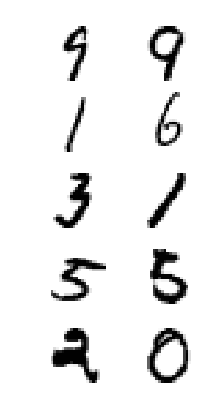

In [95]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

레이블을 확인해 보겠습니다(0은 "다른 것", 1은 "같은 것"을 의미합니다):

In [96]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

완벽하네요!

### 10.3.
_문제: 이 훈련 세트로 DNN을 훈련시키세요. 각각의 이미지 쌍에서 첫 번째 이미지는 DNN A에, 두 번째 이미지는 DNN B에 동시에 주입합니다. 전체 네트워크는 두 이미지가 같은 클래스인지 아닌지 구분하도록 점차 학습될 것입니다._

MNIST 테스트 세트에서 추출한 이미지 쌍으로 테스트 세트를 만듭니다:

In [97]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

이제 모델을 훈련시킵니다. `batch_size`가 크다는 것외에는 이 단계에 특별한 것은 없습니다. 배치 사이즈가 크지 않으면 모델이 학습을 실패하고 50% 정확도밖에 도달하지 못할 것입니다:

In [98]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "훈련 손실:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 훈련 손실: 0.6923601
0 테스트 정확도: 0.5031
1 훈련 손실: 0.6937516
2 훈련 손실: 0.68896145
3 훈련 손실: 0.6279489
4 훈련 손실: 0.52220035
5 훈련 손실: 0.53943956
5 테스트 정확도: 0.7317
6 훈련 손실: 0.540305
7 훈련 손실: 0.4539397
8 훈련 손실: 0.45064873
9 훈련 손실: 0.46825847
10 훈련 손실: 0.35033742
10 테스트 정확도: 0.8226
11 훈련 손실: 0.41334054
12 훈련 손실: 0.36943892
13 훈련 손실: 0.3761535
14 훈련 손실: 0.32001543
15 훈련 손실: 0.3276174
15 테스트 정확도: 0.8599
16 훈련 손실: 0.31543648
17 훈련 손실: 0.3408299
18 훈련 손실: 0.28993773
19 훈련 손실: 0.30727524
20 훈련 손실: 0.3542515
20 테스트 정확도: 0.8762
21 훈련 손실: 0.2317312
22 훈련 손실: 0.29069817
23 훈련 손실: 0.2473632
24 훈련 손실: 0.26694357
25 훈련 손실: 0.23917963
25 테스트 정확도: 0.8854
26 훈련 손실: 0.25618115
27 훈련 손실: 0.30616862
28 훈련 손실: 0.26199126
29 훈련 손실: 0.2588208
30 훈련 손실: 0.2660696
30 테스트 정확도: 0.8996
31 훈련 손실: 0.26256475
32 훈련 손실: 0.2385816
33 훈련 손실: 0.21879901
34 훈련 손실: 0.25663137
35 훈련 손실: 0.22745438
35 테스트 정확도: 0.9138
36 훈련 손실: 0.19570562
37 훈련 손실: 0.14133626
38 훈련 손실: 0.15163487
39 훈련 손실: 0.18004777
40 훈련 손실: 0.16298935
40 테스트 정확도: 0.

좋습니다. 숫자 비교 작업에서 97.6% 정확도를 달성했습니다. 아주 나쁘지 않네요. 이 모델은 손글씨 숫자를 비교하는 능력을 갖추었습니다!

이 지식을 일반 MNIST 분류 문제에 사용할 수 있는지 확인해 보겠습니다.

### 10.4.
_문제: 이제 DNN A의 은닉층을 동결해서 재사용하고 10개의 뉴런으로 된 소프트맥스 출력 층을 추가한 새로운 DNN을 만듭니다. 이 네트워크를 분할 #2에 대해 훈련시켜보고 클래스당 500개의 이미지만으로도 높은 성능을 얻을 수 있는지 확인해보세요._

모델을 만드는 것은 매우 간단합니다. 하위층을 동결하는 방법이 많이 있습니다. 이 예제에서는 `tf.stop_gradient()` 함수를 사용하겠습니다. 미리 학습된 DNN A를 복원하기 위해 `Saver` 객체가 필요하고 최종 모델을 저장하기 위해 다른 `Saver` 객체가 필요합니다:

In [99]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

이제 훈련입니다! 모든 변수를 초기화하고(새 출력층의 변수를 포함하여), 미리 학습된 DNN A를 복원합니다. 다음에 작은 MNIST 데이터셋(5,000개 이미지)에 이 모델을 훈련시킵니다:

In [100]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 테스트 정확도: 0.9308
10 테스트 정확도: 0.9594
20 테스트 정확도: 0.9638
30 테스트 정확도: 0.964
40 테스트 정확도: 0.9639
50 테스트 정확도: 0.9635
60 테스트 정확도: 0.9635
70 테스트 정확도: 0.9633
80 테스트 정확도: 0.9634
90 테스트 정확도: 0.9634


오 96.7% 정확도네요. 지금까지 훈련시킨 최고의 MNIST 모델은 아니지만 아주 작은 훈련 세트(숫자당 500개 이미지)를 사용한 것을 유념하세요. 전이 학습을 사용하지 않고 그냥 처음부터 학습시킨 DNN과 결과를 비교해 보겠습니다:

In [101]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [102]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 테스트 정확도: 0.8623
10 테스트 정확도: 0.9184
20 테스트 정확도: 0.9362
30 테스트 정확도: 0.9406
40 테스트 정확도: 0.9402
50 테스트 정확도: 0.9403
60 테스트 정확도: 0.9401
70 테스트 정확도: 0.9402
80 테스트 정확도: 0.9401
90 테스트 정확도: 0.9398
100 테스트 정확도: 0.9397
110 테스트 정확도: 0.9398
120 테스트 정확도: 0.9398
130 테스트 정확도: 0.9399
140 테스트 정확도: 0.94


94.8% 정확도 밖에 안되네요. 전이 학습이 에러율를 5.2%에서 3.3%로 낮추어 주었습니다(36% 이상 에러가 감소했습니다). 더군다나 전이 학습을 사용한 모델은 10번의 에포크만에 96%의 정확도에 도달했습니다.

최종 결과: 전이 학습이 항상 좋은 결과를 내지는 않습니다(연습문제 9에서 보았듯이). 하지만 그렇지 않을 땐 아주 큰 차이를 만들 수 있습니다. 그러므로 꼭 시도해 보세요!